# Quasicrystal 1D chain system

## Theory

### Redefining the Hamiltonian

Before we were considering a 1D chain where the hopping potential $(t)$ from site to site was constant throughout the entire crystal structure. We want to consider quasicrystal systems which do not have this crystal-like translational invariance in their structure. One way we can introduce quasicrystallinity is through the hopping potential. We can define two different hopping potentials $t_1$ and $t_2$ and create our system such they alternate according to some sequence. This sequence should not be random, as this would not be a quasicrystal system. Rather, it should be an aperiodic but predictable sequence. There are many ways of geenrating such a sequence.

Top implement this quasicrystalinity into our system we need to change the definition of our BdG Hamiltonian. In the crystal structure the Hamiltonian took the following form;

$$ \mathcal{H}_{BdG} = \begin{pmatrix}
        \mathcal{H}_{0} & \Delta \\
        \Delta^{\dag} & \mathcal{H}_{0}^{*}
    \end{pmatrix} $$

where $\mathcal{H}_{0} = H_{\Delta = 0}$. That is to say, the normal-state Hamiltonian with no superconducting term. This would be of the form of an $N \times N$ matrix
$$ \mathcal{H}_{0} = \begin{pmatrix}
    -\mu & -t & 0 & 0 & \dots \\
    -t & -\mu & -t & 0 & \dots \\
    0 & -t & -\mu & -t & \dots \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & 0 & -\mu
\end{pmatrix}. $$

And $\Delta$ is the pairing matrix, this is defined as
$$ \Delta = \begin{pmatrix}
    0 & \Delta & 0 & 0 & \dots \\
    -\Delta & 0 & \Delta & 0 & \dots \\
    0 & -\Delta & 0 & \Delta & \dots \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & 0 & 0
    \end{pmatrix}. $$
resulting in $\mathcal{H}_{BdG}$ being a $2N \times 2N$ matrix.

For a hopping potential varied quasicrystal system we would change $\mathcal{H}_{0}$ to the following;

$$ \mathcal{H}_{0} = \begin{pmatrix}
    -\mu & -t_1 & 0 & 0 & \dots \\
    -t_1 & -\mu & -t_2 & 0 & \dots \\
    0 & -t_2 & -\mu & -t_2 & \dots \\
    \vdots & \vdots & -t_2 & \ddots & \vdots \\
    0 & 0 & 0 & 0 & -\mu
\end{pmatrix} $$

Where the hopping between sites $1 \to 2 = t_1$ and between sites $2 \to 3 = 3 \to 4 = t_2$.

### Sequence Generation

#### Fibonacci Sequence

We can calculate the sequence of $t_1$'s and $t_2$'s using the golden ration. This will give a fibonacci quasicrystal. The golden ratio is given by $$\phi = \frac{1 + \sqrt{5}}{2} \approx 1.618$$

We can calculate a sequence using this number by finding the fractional part of $n \times \phi$ for $n \in \mathbb{Z}$ (in our case $n = 0, 1, 2, \dots, N$). If this is greater than $1/2$ then we assign $t_1$, if it is less than $1/2$ we assign $t_2$. Summarising;


## Packages

In [1]:
import FileIO
using Printf
using Statistics
using LinearAlgebra
using Plots
using PyPlot
using Clustering
using Distances
using LsqFit
using IterTools
using DataFrames
using StatsPlots
using BSON
using Measurements
using Measures

using Distributed
using ParallelDataTransfer
using SharedArrays
using BenchmarkTools



# using PyPlot;
# using StatsBase;
# using Colors;
# using BSON: @load,@save;
# using LaTeXStrings
# using CSV
# using DataFrames
# using LinearAlgebra
using ProgressMeter

## Hopping Parameter Sequence Generation

In [2]:
# # ****************************** Sec 0 ******************************
# # Functions for different sequence generation methods

function normal_crystal_gen(N::Int)
    return fill(1, N)
end

function incorrect_golden_ratio_sequence(N::Int, phi::Float64)
    """
    Generates a sequence of 1s and 2s based on the golden ratio, suitable for creating
    quasicrystal-like hopping terms in a Kitaev chain model.

    Parameters:
    N -- Length of the sequence (number of hopping terms)
    
    Returns:
    sequence -- Vector of 1s and 2s of length N
    """
    sequence = Vector{Int}(undef, N)

    for i in 1:N
        # Generate the fractional part of i * phi
        fractional_part = (i * phi) % 1
        # Assign 1 if fractional part < 0.5, otherwise assign 2
        sequence[i] = fractional_part < 0.5 ? 1 : 2
    end

    return sequence
end

function golden_ratio_sequence_gen(N::Int)
    sequence = "A"
    while length(sequence) < N
        sequence = replace(sequence, "A" => "AB", "B" => "A")
    end
    println(sequence)
    
    number_sequence = [ch == 'A' ? 1 : 2 for ch in sequence]
    
    return number_sequence
end

function silver_ratio_sequence_gen(N::Int)
    sequence = "A"
    while length(sequence) < N
        sequence = replace(sequence, "A" => "BAA", "B" => "A")
    end
    println(sequence)
    
    number_sequence = [ch == 'A' ? 1 : 2 for ch in sequence]
    
    return number_sequence
end

function check_PV_ratio(number_sequence::Vector{Int})
    count_A = count(x -> x == 1, number_sequence)
    count_B = count(x -> x == 2, number_sequence)
    
    ratio = count_A / count_B
    
    return ratio
end

function thue_morse_sequence_gen(n::Int)
    if n <= 0 || (n & (n - 1)) != 0
        throw(ArgumentError("n must be a power of 2."))
    end
    
    sequence = Int[]
    for i in 0:n-1
        num_ones = count(c -> c == '1', string(i, base=2))
        push!(sequence, num_ones % 2 + 1)
    end
    
    return sequence
end

function plastic_ratio_sequence_gen(N::Int)
    sequence = "A"
    while length(sequence) < N
        sequence = replace(sequence, "A" => "B", "B" => "AC", "C" => "A") # Van der Laan word generation
        # sequence = replace(sequence, "A" => "AB", "B" => "AC", "C" => "A") # ChatGPT
    end
    println(sequence)
    
    number_sequence = [ch == 'A' ? 1 : ch == 'B' ? 2 : 3 for ch in sequence]
    
    return number_sequence
end

function check_plastic_ratio(number_sequence::Vector{Int}, rho::Float64)
    count_A = count(x -> x == 1, number_sequence)
    count_B = count(x -> x == 2, number_sequence)
    count_C = count(x -> x == 3, number_sequence)

    ratio_AB = count_A / count_B
    ratio_BC = count_B / count_C

    return (ratio_AB, ratio_BC, rho)
end

function tribonacci_SeqGen(N::Int)
    sequence = "A"
    while length(sequence) < N
        sequence = replace(sequence, "A" => "AB", "B" => "AC", "C" => "A")
    end
    
    number_sequence = [ch == 'A' ? 1 : ch == 'B' ? 2 : 3 for ch in sequence]

    return number_sequence
end


# Create pairing parameter sequence for N sites

# Normal Crystal
N_normal = 5000
normal_sequence = normal_crystal_gen(N_normal)


# Golden Ratio
N_gold = 5000
golden_sequence = golden_ratio_sequence_gen(N_gold)
println("Golden ratio sequence: ", golden_sequence)
println("Sequence length: ", length(golden_sequence))

golden_phi = (1 + sqrt(5)) / 2
ratio = check_PV_ratio(golden_sequence)
println("Sequence ratio: ", ratio)
println("Golden ratio: ", golden_phi)
println("***********************************************************")


# Silver Ratio
N_silver = 5000
silver_sequence = silver_ratio_sequence_gen(N_silver)
println("Silver ratio sequence: ", silver_sequence)
println("Sequence length: ", length(silver_sequence))

silver_phi = 1 + sqrt(2)
ratio = check_PV_ratio(silver_sequence)
println("Sequence ratio: ", ratio)
println("Silver ratio: ", silver_phi)
println("***********************************************************")


# Thue-Morse 
N_thue_morse = 4096
thue_morse_sequence = thue_morse_sequence_gen(N_thue_morse)
thue_morse_phi = 1.0
ratio = check_PV_ratio(thue_morse_sequence)
println("Thue-Morse Sequence: ", thue_morse_sequence)
println("Sequence length: ", length(thue_morse_sequence))
println("Sequence ratio: ", ratio)
println("Thue-Morse ratio = ", thue_morse_phi)
println("***********************************************************")


# Plastic Ratio
N_plastic = 5000
plastic_sequence = plastic_ratio_sequence_gen(N_plastic)
println("Plastic Sequence: ", plastic_sequence)
println("Sequence length: ", length(plastic_sequence))
plastic_rho = 1.3247179572447460259609088
ratio_AB, ratio_BC, rho = check_plastic_ratio(plastic_sequence, plastic_rho)
println("Ratio A/B: $ratio_AB")
println("Ratio B/C: $ratio_BC")
println("Plastic Ratio: $plastic_rho")


# N_range = floor.(Int, collect(range(1,50,20)))
# inflation_lengths = []

# for N in N_range
#     golden_sequence = golden_ratio_sequence_gen(N)
#     # println("Sequence length: ", length(golden_sequence))
#     push!(inflation_lengths, length(golden_sequence))
# end

# println("Golden QC infaltion lengths: $inflation_lengths")


N_trib = 5000
trib_sequence = tribonacci_SeqGen(N_trib)
println(trib_sequence)
println(length(trib_sequence))
tribonacci_rho = 1.8392867552141611325518525
ratio_AB, ratio_BC, rho = check_plastic_ratio(trib_sequence, tribonacci_rho)
println("Ratio A/B: $ratio_AB")
println("Ratio B/C: $ratio_BC")
println("Tribonacci Ratio: $tribonacci_rho")


ABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAABABAABABAABAABABAABABAABAABABAABAAB

## Global Parameter Definition

In [3]:
"""
Global parameter definition
"""

function print_results_structure(results::Dict{Any, Any})
    println("Top-level keys and value types in 'results':")
    for (key, value) in results
        println("Key: $key => Type: $(typeof(value))")
        if isa(value, Dict)
            println("  Nested keys and types:")
            for (subkey, subvalue) in value
                println("    $subkey => $(typeof(subvalue))")
                if isa(subvalue, AbstractArray)
                    println("      Array length: $(length(subvalue))")
                end
            end
        end
    end
end

function log_range(base::Float64, start_power::Float64, end_power::Float64, length::Int)
    powers = range(start_power, stop=end_power, length=length)
    values = base .^ powers
    return values
end

function t_ranges_combinations(t_ranges::Vector{Vector{Float64}})
    t_combinations_matrix = collect(IterTools.product(t_ranges...))
    t_combinations = [collect(t) for t in vec(t_combinations_matrix)]
    return t_combinations
end

# Hamiltonian parameters
N = 100
t_list = [1.0, 2.0]#, 0.8]
Delta = 1.0 * t_list[1]
mu = t_list[1]
sequence = golden_sequence
mu_values = collect(range(0.0, stop=3.0, length=301))

# LDOS parameters
energy_min_LDOS_global = -5.0
energy_max_LDOS_global = 5.0
energy_range_LDOS_global = collect(range(energy_min_LDOS_global, energy_max_LDOS_global, length=1000))#100000))
delta = 0.01 #0.001

# Spectral function parameters
energy_min_spectral_global = -1.0
energy_max_spectral_global = 1.0
energy_range_spectral_global = collect(range(energy_min_spectral_global, energy_max_spectral_global, length=101))
eta = 0.1



0.1

## Defining the BdG Hamiltonian and Basic Solving Functions

In [4]:
"""
Functions setting up the BdG Hamiltonian and solving, checking normalisations and plotting test values (has a function for both the generalised and ungeneralised t-varying quasicrystal)
"""

# # ****************************** Sec 1 ******************************
# # Setting up the BdG matrix and solving for the eigenvalues and eigenvectors

function create_normal_hamiltonian_quasi(N::Int, t1::Float64, t2::Float64, mu::Float64, sequence::Vector{Int})
    """
    Constructs the normal-state Hamiltonian H_0 of the Kitaev chain with alternating hopping terms.

    Parameters:
    N       -- Number of lattice sites
    t1      -- First hopping term
    t2      -- Second hopping term
    mu      -- Chemical potential
    sequence -- A vector of integers (1 or 2) indicating the hopping term to use between each site
    
    Returns:
    H0 -- NxN matrix representing the normal-state Hamiltonian
    """
    H0 = ComplexF64[0.0 + 0im for _ in 1:N, _ in 1:N]

    for i in 1:N
        H0[i, i] = -mu + 0im
    end

    for i in 1:N-1
        hopping_term = sequence[i] == 1 ? t1 : t2  # Select t1 or t2 based on sequence
        H0[i, i+1] = -hopping_term
        H0[i+1, i] = -hopping_term
    end

    return H0
end

function flip_diagonal(matrix::AbstractMatrix{<:Complex})
    # Get the diagonal elements
    diag_elements = diag(matrix)
    
    # Reverse the diagonal elements
    reversed_diag = reverse(diag_elements)

    # Replace the diagonal with the reversed diagonal
    flipped_matrix = copy(matrix)
    for i in 1:min(size(matrix)...)
        flipped_matrix[i, i] = reversed_diag[i]
    end

    return flipped_matrix
end

function add_linear_diagonal_factor(matrix::AbstractMatrix{<:Complex}, sigma::Float64)
    N, M = size(matrix)
    if N != M
        throw(ArgumentError("The input matrix must be square."))
    end

    modified_matrix = copy(matrix)

    for i in 1:N
        modified_matrix[i,i] += (i * sigma)
    end

    return modified_matrix
end

function add_linear_diagonal_factor_BdG(matrix::AbstractMatrix{<:Complex}, sigma::Float64)
    N, M = size(matrix)
    if N != M
        throw(ArgumentError("The input matrix must be square."))
    end

    n = N ÷ 2

    perturbation = range(-sigma, sigma, length=n)

    modified_matrix = copy(matrix)

    for i in 1:n
        modified_matrix[i,i] += perturbation[i] #(i * sigma)
        modified_matrix[n+i, n+i] -= perturbation[i] #((n+i) * sigma)
    end

    return modified_matrix
end

function create_normal_hamiltonian_quasi_tn_generalised(N::Int, t_n::Vector{Float64}, mu::Float64, sequence::Vector{Int})
    """
    Constructs the normal-state Hamiltonian H_0 of the Kitaev chain with hopping terms defined by t_n.

    Parameters:
    N         -- Number of lattice sites
    t_n       -- Vector of hopping terms
    mu        -- Chemical potential
    sequence  -- A vector of integers (indices) indicating which hopping term in t_n to use between each site

    Returns:
    H0 -- NxN matrix representing the normal-state Hamiltonian
    """
    H0 = ComplexF64[0.0 + 0im for _ in 1:N, _ in 1:N]

    sigma = 1e-16

    for i in 1:N
        H0[i, i] = -mu + (i * sigma)
    end

    for i in 1:N-1
        hopping_index = sequence[i]
        hopping_term = t_n[hopping_index]
        H0[i, i+1] = -hopping_term + 0im
        H0[i+1, i] = -hopping_term + 0im
    end

    return H0
end

function create_pairing_matrix(N::Int, Delta::Float64)
    """
    Constructs the pairing matrix Delta for the Kitaev chain.

    Parameters:
    N  -- Number of lattice sites
    Delta  -- Superconducting pairing term
    
    Returns:
    pairing_matrix -- NxN matrix representing the pairing interactions
    """
    pairing_matrix = ComplexF64[0.0 + 0im for _ in 1:N, _ in 1:N]

    for i in 1:N-1
        pairing_matrix[i, i+1] = Delta + 0im
        pairing_matrix[i+1, i] = -Delta + 0im
    end

    return pairing_matrix
end

function create_bdg_hamiltonian(N::Int, H0::Matrix{ComplexF64}, Delta::Matrix{ComplexF64})
    """
    Constructs the 2N x 2N BdG Hamiltonian matrix using H_0 and Delta.

    Parameters:
    N  -- Number of lattice sites
    H0 -- NxN normal-state Hamiltonian matrix (hopping and chemical potential)
    Delta  -- NxN pairing matrix
    
    Returns:
    BdG Hamiltonian -- 2Nx2N matrix representing the BdG Hamiltonian
    """
    BdG = ComplexF64[0.0 + 0im for _ in 1:2*N, _ in 1:2*N]

    H0_diag_flipped = flip_diagonal(Matrix(H0))

    BdG[1:N, 1:N] = H0
    BdG[N+1:end, N+1:end] = -conj(H0_diag_flipped)
    BdG[1:N, N+1:end] = Delta
    BdG[N+1:end, 1:N] = Delta'

    # sigma = 1e-10

    # modified_BdG = add_linear_diagonal_factor_BdG(BdG, sigma)

    return BdG
end

function solve_bdg_hamiltonian(BdG::Matrix{ComplexF64})
    """
    Returns the BdG Hamiltonian eigenvalues and eigenvectors.

    Parameters:
    BdG -- 2Nx2N BdG Hamiltonian matrix
    
    Returns:
    eigenvalues -- Vector of eigenvalues
    eigenvectors -- Matrix of eigenvectors
    """
    eigenvalues, eigenvectors = eigen(BdG)
    return eigenvalues, eigenvectors
end

function check_eigenvectors_normalisation(eigenvectors::Matrix{ComplexF64}, tolerance::Float64)
    """
    Checks if the eigenvectors are normalized, i.e., each eigenvector should have a norm of 1.

    Parameters:
    eigenvectors -- Matrix of eigenvectors (2N x 2N)
    tolerance -- Float value for allowed tolerance in the normalization check
    
    Returns:
    A summary message indicating whether all eigenvectors are normalized,
    and details of any that are not normalized.
    """
    N = size(eigenvectors, 1)  # Number of eigenvectors
    results = []

    for i in 1:N
        norm_value = norm(eigenvectors[:, i])
        # # print the values of eigenvector norms if you want
        # println("Energy levels: $(i) has norm: $norm_value")

        if abs(norm_value - 1) > tolerance
            push!(results, (i, norm_value))
        end
    end

    println("Checking normalisation of eigenvectors:")
    if isempty(results)
        println("All probabilities are correctly normalized within the tolerance of $tolerance.")
    else
        println("The following eigenvectors are not normalized:")
        for (index, norm_val) in results
            println("Eigenvector $index: Norm = $norm_val")
        end
    end
end

# # ****************************** Sec 2 ******************************
# # Calculating probability distributions over sites and checking normalisation

function calculate_probability_distributions_bdg(eigenvectors::Matrix{ComplexF64})
    """
    Calculates the probability distributions of site occupancy from the eigenvectors using the BdG formalism.

    Returns:
    probabilities -- 2D array where each row corresponds to a site and each column corresponds to an energy level
    """
    N = size(eigenvectors, 1) ÷ 2  # Number of sites
    probabilities = zeros(Float64, N, size(eigenvectors, 2))

    for i in 1:size(eigenvectors, 2)  # Iterate over energy levels
        for n in 1:N  # Iterate over sites
            u_n_i = eigenvectors[n, i]  # Particle component
            v_n_i = eigenvectors[n+N, i]  # Hole component
            probabilities[n, i] = 0.5 * (abs(u_n_i)^2 + abs(v_n_i)^2)
        end
    end
    return probabilities
end

function check_probability_normalisation(probabilities::Matrix{Float64}, N::Int, tolerance::Float64)
    """
    Checks if the probabilities are correctly normalized for each energy level
    within a specified tolerance.
    
    Parameters:
    probabilities -- Nx(2N) matrix of probabilities
    N -- Number of lattice sites
    tolerance -- Float value representing the acceptable deviation from 1.0
    
    Returns:
    nothing; prints the result of the normalization check.
    """
    unnormalized_pairs = []

    for n in 0:(N-1) 
        total_probability = sum(probabilities[:, N - n] + probabilities[:, N + 1 + n])
        # # print the values of probability sums if you want
        # println("Energy levels: $(N - n) and $(N + 1 + n) -> Sum: $total_probability")
        
        if abs(total_probability - 1.0) > tolerance
            push!(unnormalized_pairs, (N - n, N + 1 + n))
        end
    end

    println("Checking normalisation of probabilities:")
    if isempty(unnormalized_pairs)
        println("All probabilities are correctly normalized within the tolerance of $tolerance.")
    else
        println("The following pairs do not sum to 1 within the tolerance of $tolerance:")
        for (i, j) in unnormalized_pairs
            println("Energy levels: $i and $j")
        end
    end
end



# # ****************************** Sec 3 ******************************
# # Plotting the probability distributions of one eigenstate for a single parameter set

function plot_probability_distribution(probabilities::Matrix{Float64}, energy_level::Int, N::Int)
    """
    Plots the probability distribution of all N sites for a specified energy level.
    """
    if energy_level < 1 || energy_level > 2*N
        error("Energy level must be between 1 and $(2*N).")
    end

    sites = 1:N
    close()
        # plot(sites, probabilities[:, energy_level], lw=3)
        PyPlot.bar(sites, probabilities[:, energy_level], alpha=0.7)
    title("Probability Distribution for Energy Level $energy_level")
    xlabel("Site Index")
    ylabel("Probability")
    
    display(gcf())

end

function plot_paired_probability_distributions(probabilities::Matrix{Float64}, N::Int)
    
    sites = 1:N
    close()
        # Plotting Majorana modes
        PyPlot.plot(sites, probabilities[:, N] + probabilities[:, N + 1], label="Majoranas", lw=2)
        # println("Total probability of Majoranas: $(sum(probabilities[:, N] + probabilities[:, N + 1]))")

        # Plotting first excited state
        PyPlot.plot(sites, probabilities[:, N - 1] + probabilities[:, N + 2], label="1st Excited State", linestyle=":", lw=3)
        # println("Total probability of first excited state: $(sum(probabilities[:, N - 1] + probabilities[:, N + 2]))")

        xlabel("Site")
        ylabel("Probability")
        legend()
    display(gcf())
end




# #****************************** Sec 4 ******************************
# # Example usage code for functions in Sec 1-3

# Parameters
N_cell1 = 2
t_list_cell1 = [1.0]
mu_cell1 = 0.0
Delta_cell1 = 1.0

sequence_cell1 = normal_sequence


# Create matrices and find eigenvalues/eigenvectors
# H0 = create_normal_hamiltonian_quasi(N, t1, t2, mu, sequence)
H0 = create_normal_hamiltonian_quasi_tn_generalised(N_cell1, t_list_cell1, mu_cell1, sequence_cell1)

Delta_matrix = create_pairing_matrix(N_cell1, Delta_cell1)
BdG = create_bdg_hamiltonian(N_cell1, H0, Delta_matrix)

# Solve the Hamiltonian and find probabiltiies
eigenvalues, eigenvectors = solve_bdg_hamiltonian(BdG)
probabilities = calculate_probability_distributions_bdg(eigenvectors)


println("BDG matrix:, ", BdG)
println(size(BdG))

println("eigenvectors: ", eigenvectors)
println(size(eigenvectors))

n = div(size(eigenvectors, 2), 2)  # Calculate n based on the matrix size
println("n-th column: ", eigenvectors[:, n])
println("(n+1)-th column: ", eigenvectors[:, n+1])

# # Check normalisations
# check_eigenvectors_normalisation(eigenvectors, 1e-15)
# check_probability_normalisation(probabilities, N, 1e-15)

# # Plot single half-energy level distribution
# plot_probability_distribution(probabilities, 1, N_cell1)
# plot_paired_probability_distributions(probabilities, N_cell1)

BDG matrix:, ComplexF64[1.0e-16 + 0.0im -1.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im; -1.0 + 0.0im 2.0e-16 + 0.0im -1.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.0im -1.0 - 0.0im -2.0e-16 + 0.0im 1.0 + 0.0im; 1.0 - 0.0im 0.0 - 0.0im 1.0 + 0.0im -1.0e-16 + 0.0im]
(4, 4)
eigenvectors: ComplexF64[-0.49999999999999994 + 0.0im 0.7071067811865476 + 0.0im -5.240607461941231e-16 + 0.0im 0.4999999999999999 + 0.0im; -0.5000000000000007 + 0.0im 1.0606601717798208e-16 + 0.0im 0.7071067811865469 + 0.0im -0.5000000000000001 + 0.0im; -0.4999999999999999 + 0.0im -0.7071067811865475 + 0.0im -4.179947290161409e-16 + 0.0im 0.49999999999999967 + 0.0im; 0.4999999999999992 - 0.0im 0.0 + 0.0im 0.7071067811865482 + 0.0im 0.49999999999999994 + 0.0im]
(4, 4)
n-th column: ComplexF64[0.7071067811865476 + 0.0im, 1.0606601717798208e-16 + 0.0im, -0.7071067811865475 + 0.0im, 0.0 + 0.0im]
(n+1)-th column: ComplexF64[-5.240607461941231e-16 + 0.0im, 0.7071067811865469 + 0.0im, -4.179947290161409e-16 + 0.0im, 0.7071067811865482 + 0.0im]


## Pfaffian
and topological invariants

The Pfaffian is a quantity that can be derived from an anti-symmetric matrix (a matrix, $M$, that satisfies $M = -M^{T}$). The square of the Pfaffian is equal to the determinant of the anti-symmetric matrix:

\begin{equation}
    Pf(M)^2 = det(M)
\end{equation}

Since the Pfaffian is only defined on anti-symmetric matrices, we must first convert any non-anti-symmetric matrices into antisymmetric form. This is easy to do as it turns out $H_{BDG}$ can be written as an anti-symmetric form, $\tilde{H}_{BDG}$, by multiplying either side with an unitary matrix:

\begin{equation}
    \tilde{H}_{BDG} = \frac{1}{2} \begin{bmatrix} 1 & 1 \\ i & -i \\ \end{bmatrix} H_{BDG} \begin{bmatrix} 1 & -i \\ 1 & i \\ \end{bmatrix}
\end{equation}

The topological invariant, $Q$, is a quantity that determines whether we are working in the same topological regime and defines what counts as a topological phase transition (i.e. the difference between continuous and discountinous transformations). In condensed matter, one type of topological invariant can be the number of energy levels above or below zero energy for a given Hamiltonian. Another kind of topological invariant can be defined from the Pfaffian:

\begin{equation}
Q = sign(Pf[i\tilde{H}_{BDG}(0)]Pf[i\tilde{H}_{BDG}(\pi)])
\end{equation}

When Q is negative we are in the topological region and when Q is positive we are in the trivial region.


In [5]:
# using PyCall
# @pyimport imp
# path = dirname("pfapack/python/pfaffian.py")
# name = basename("pfapack/python/pfaffian.py")
# (file, filename, data) = imp.find_module("pfaffian", [path]);
# pfaffian = imp.load_module(name, file, filename, data)

function Householder(x::Vector{Float64})::Tuple{Vector{Float64}, Float64, Float64}
    @assert length(x) > 0

    sigma = dot(x[2:end], x[2:end])

    if sigma == 0
        return (zeros(Float64, length(x)), 0., x[1])
    else
        norm_x = sqrt(x[1]^2 + sigma)
        v = copy(x)
        if x[1] <= 0
            v[1] -= norm_x
            alpha = +norm_x
        else
            v[1] += norm_x
            alpha = -norm_x
        end
        normalize!(v)
        return v, 2., alpha
    end
end

Householder(x::Vector{Int}) = Householder(convert(Vector{Float64}, x))

function Householder(x::Vector{ComplexF64})::Tuple{Vector{ComplexF64}, Float64, ComplexF64}
    @assert length(x) > 1

    sigma = dot(x[2:end], x[2:end])

    if sigma == 0
        return (zeros(Complex128, length(x)), 0., x[1])
    else
        norm_x = sqrt(abs2(x[1]) + sigma)
        v = copy(x)
        phase = exp(im * atan2(imag(x[1]), real(x[1])))
        v[1] += phase * norm_x
        normalize!(v)
        return (v, 2., -phase * norm_x)
    end
end

function skew_tridiagonalize(A::Matrix{T}; overwrite_A=false, calc_Q=true) where {T <: Number}
    @assert size(A)[1] == size(A)[2] > 0
    @assert maximum(abs, A + A') < 1e-12

    n = size(A)[1]

    # FIXME: not very Julian...
    if !overwrite_A
        A = copy(A)
    end

    if calc_Q
        Q = eye(T, n)
    end

    for i in 1:n-2
        v::Vector{T}, tau::Float64, alpha::T = Householder(A[i+1:end, i])
        @inbounds begin
            A[i+1, i] = alpha
            A[i, i+1] = -alpha
            A[i+2:end, i] = 0.
            A[i, i+2:end] = 0.
        end

        @inbounds w = @view(A[i+1:end, i+1:end]) * conj(v)

        # A[i+1:end, i+1:end] += v * w.' - w * v.' # most natural way == turtle
        # A[i+1:end, i+1:end] .+= v .* w.' .- w .* v.' # new dot syntax == useless
        # optimize outer product computation with BLAS
        # (see https://www.reddit.com/r/Julia/comments/32qad9/how_to_calculate_an_outer_product_efficiently/)
        @inbounds BLAS.ger!(T(tau), v, conj(w), @view(A[i+1:end, i+1:end]))
        @inbounds BLAS.ger!(T(-tau), w, conj(v), @view(A[i+1:end, i+1:end]))

        if calc_Q
            @inbounds y = @view(Q[:, i+1:end]) * v
            @inbounds BLAS.ger!(T(-tau), y, v, @view(Q[:, i+1:end]))
        end
    end

    if calc_Q
        return A, Q
    else
        return A
    end
end

function skew_tridiagonalize(A::Matrix{Int}; overwrite_A=false, calc_Q=true)
    return skew_tridiagonalize(convert(Matrix{Float64}, A), overwrite_A=overwrite_A, calc_Q=calc_Q)
end

function Pfaffian_LTL(A::Union{Matrix{Float64}, Matrix{ComplexF64}}; overwrite_A=false, skewsymtol=1e-6)::Union{Float64, ComplexF64}
    @assert size(A)[1] == size(A)[2] > 0
    @assert maximum(abs, A + A') < skewsymtol

    T = eltype(A)
    n = size(A)[1]

    if n%2 == 1
        return T(0.)
    end

    # FIXME: not very Julian...
    if !overwrite_A
        A = copy(A)
    end

    pf_val = T(1.)

    for k in 1:2:n-1
        kp = k + argmax(abs.(A[k+1:end, k]))

        if kp != k+1
            temp = copy(A[k+1, k:end])
            A[k+1, k:end] = @view(A[kp, k:end])
            A[kp, k:end] = temp

            temp = copy(A[k:end, k+1])
            A[k:end, k+1] = @view(A[k:end, kp])
            A[k:end, kp] = temp

            pf_val *= -1.
        end

        if A[k+1, k] != 0.
            tau = copy(A[k, k+2:end])
            tau /= A[k, k+1]

            pf_val *= A[k, k+1]

            if k+2 <= n
                BLAS.ger!(T(1.), tau, conj(@view(A[k+2:end, k+1])), @view(A[k+2:end, k+2:end]))
                BLAS.ger!(T(-1.), @view(A[k+2:end, k+1]), conj(tau), @view(A[k+2:end, k+2:end]))
            end
        else
            return T(0.)
        end
    end

    return pf_val
end

function Pfaffian_LTL(A::Matrix{Int}; overwrite_A=false, skewsymtol=1e-6)::Float64
    return Pfaffian_LTL(convert(Matrix{Float64}, A), overwrite_A=overwrite_A, skewsymtol=skewsymtol)
end

function Pfaffian_Householder(A::Union{Matrix{Float64}, Matrix{ComplexF64}}; overwrite_A=false, skewsymtol=1e-6)::Union{Float64, ComplexF64}
    @assert size(A)[1] == size(A)[2] > 0
    @assert maximum(abs, A + A') < skewsymtol

    T = eltype(A)
    n = size(A)[1]

    if n%2 == 1
        return T(0.)
    end

    # FIXME: not very Julian...
    if !overwrite_A
        A = copy(A)
    end

    pf_val = T(1.)

    for i in 1:n-2
        v, tau, alpha = Householder(A[i+1:end, i])
        A[i+1, i] = alpha
        A[i, i+1] = -alpha
        A[i+2:end, i] = 0.
        A[i, i+2:end] = 0.

        w = @view(A[i+1:end, i+1:end]) * conj(v)
        BLAS.ger!(T(tau), v, conj(w), @view(A[i+1:end, i+1:end]))
        BLAS.ger!(T(-tau), w, conj(v), @view(A[i+1:end, i+1:end]))

        if tau != 0
            pf_val *= 1. - tau
        end
        if i%2 == 1
            pf_val *= -alpha
        end
    end

    pf_val *= A[n-1, n]

    return pf_val
end

function Pfaffian_Householder(A::Matrix{Int}; overwrite_A=false, skewsymtol=1e-6)::Float64
    return Pfaffian_Householder(convert(Matrix{Float64}, A), overwrite_A=overwrite_A, skewsymtol=skewsymtol)
end

# default to LTL for speed
Pfaffian(A::Matrix; overwrite_A=false, skewsymtol=1e-6)::Union{Float64, ComplexF64} = Pfaffian_LTL(A, overwrite_A=overwrite_A, skewsymtol=skewsymtol)
# Pfaffian(A::Matrix; overwrite_A=false, skewsymtol=1e-6)::Union{Float64, Complex128} = Pfaffian_Householder(A, overwrite_A=overwrite_A, skewsymtol=skewsymtol)

# Wimmer's version
# Pfaffian(A::Matrix; overwrite_A=false, skewsymtol=1e-6)::Union{Float64, Complex128} = pfaffian[:pfaffian](A, overwrite_a=overwrite_A, method="P")

Pfaffian (generic function with 1 method)

In [6]:
function create_majorana_hamiltonian(N::Int, mu::Float64, t::Float64, Delta::Float64)
    # Initialize the Hamiltonian matrix
    H = zeros(ComplexF64, 2N, 2N)

    for n in 1:N
        # Indices for Majorana operators
        gamma1 = 2n - 1
        gamma2 = 2n
        gamma3 = mod(gamma2 + 1 - 1, 2N) + 1 # Wrap around for periodic boundary conditions
        gamma4 = mod(gamma1 + 2 - 1, 2N) + 1 # Wrap around for periodic boundary conditions

        H[gamma1, gamma2] -= mu / 2
        H[gamma2, gamma1] += mu / 2

        H[gamma2, gamma3] += (t + Delta) / 2
        H[gamma3, gamma2] -= (t + Delta) / 2

        H[gamma1, gamma4] += (-t + Delta) / 2
        H[gamma4, gamma1] -= (-t + Delta) / 2
    end

    return H
end

function create_majorana_hamiltonian_generalised_PBC(N::Int, t_n::Vector{Float64}, mu::Float64, Delta::Float64, sequence::Vector{Int})
    """
    Constructs the Majorana Hamiltonian of the Kitaev chain with aperiodic hopping terms.

    Parameters:
    N         -- Number of lattice sites
    t_n       -- Vector of hopping terms
    mu        -- Chemical potential
    Delta     -- Superconducting pairing term
    sequence  -- A vector of integers (indices) indicating which hopping term in t_n to use between each site

    Returns:
    H -- (2N)x(2N) matrix representing the Majorana Hamiltonian
    """
    # Initialize the Hamiltonian matrix
    H = zeros(ComplexF64, 2N, 2N)

    for n in 1:N
        # Indices for Majorana operators
        gamma1 = 2n - 1
        gamma2 = 2n
        gamma3 = mod(gamma2 + 1 - 1, 2N) + 1 # Wrap around for periodic boundary conditions
        gamma4 = mod(gamma1 + 2 - 1, 2N) + 1 # Wrap around for periodic boundary conditions

        # Chemical potential term
        H[gamma1, gamma2] -= mu / 2
        H[gamma2, gamma1] += mu / 2

        # Hopping and pairing terms
        hopping_index = sequence[n]
        t = t_n[hopping_index]

        if n < N
            H[gamma2, gamma3] += (t + Delta) / 2
            H[gamma3, gamma2] -= (t + Delta) / 2

            H[gamma1, gamma4] += (-t + Delta) / 2
            H[gamma4, gamma1] -= (-t + Delta) / 2
        else
            # For periodic boundary conditions at the last site
            H[gamma2, gamma3] += (t + Delta) / 2
            H[gamma3, gamma2] -= (t + Delta) / 2

            H[gamma1, gamma4] += (-t + Delta) / 2
            H[gamma4, gamma1] -= (-t + Delta) / 2
        end
    end

    return H
end


function create_majorana_hamiltonian_generalised_OBC(N::Int, t_n::Vector{Float64}, mu::Float64, Delta::Float64, sequence::Vector{Int})
    """
    Constructs the Majorana Hamiltonian of the Kitaev chain with aperiodic hopping terms and open boundary conditions.

    Parameters:
    N         -- Number of lattice sites
    t_n       -- Vector of hopping terms
    mu        -- Chemical potential
    Delta     -- Superconducting pairing term
    sequence  -- A vector of integers (indices) indicating which hopping term in t_n to use between each site

    Returns:
    H -- (2N)x(2N) matrix representing the Majorana Hamiltonian
    """
    # Initialize the Hamiltonian matrix
    H = zeros(ComplexF64, 2N, 2N)

    for n in 1:N
        # Indices for Majorana operators
        gamma1 = 2n - 1
        gamma2 = 2n

        # Chemical potential term
        H[gamma1, gamma2] -= mu / 2
        H[gamma2, gamma1] += mu / 2

        # Hopping and pairing terms (no wrap-around)
        if n < N
            gamma3 = 2n + 1  # gamma2 of the next site
            gamma4 = 2n + 2  # gamma1 of the next site
            hopping_index = sequence[n]
            t = t_n[hopping_index]

            H[gamma2, gamma3] += (t + Delta) / 2
            H[gamma3, gamma2] -= (t + Delta) / 2

            H[gamma1, gamma4] += (-t + Delta) / 2
            H[gamma4, gamma1] -= (-t + Delta) / 2
        end
    end

    return H
end


function real_space_pfaffian_invariant(N::Int, t_n::Vector{Float64}, sequence::Vector{Int}, mu_values::Vector{Float64}, Delta::Float64, imag_tolerance::Float64 = 1e-2)
    
    pfaff_invariant_values = Float64[]

    for mu in mu_values

        # H0 = create_normal_hamiltonian_quasi_tn_generalised(N, t_n, mu, sequence)
        # pairing_matrix = create_pairing_matrix(N, Delta)
        # BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)
        
        H = create_majorana_hamiltonian_generalised_PBC(N, t_n, mu, Delta, sequence)

        S = schur(H)
        T = S.T
        U = S.Z

        h = U * T * U'

        # main_diag = diag(T)
        # off_diag = diag(T, 1)

        # D = Tridiagonal(zeros(eltype(T), length(main_diag)), off_diag, -off_diag)
        # D = Tridiagonal(off_diag, main_diag, -off_diag)

        Pf_H = Pfaffian(H, overwrite_A=false, skewsymtol=1e-2)

        # Pf_T = Pfaffian(T, overwrite_A=false, skewsymtol=1e-2)
        # det_U = det(U)

        # println(Pf_T)
        # println(det_U)

        # M = sign(det(U)*Pf_T)
        # push!(pfaff_invariant_values, M)

        if abs(imag(Pf_H)) < imag_tolerance
            M = sign(real(Pf_H))
            push!(pfaff_invariant_values, M)
        else
            error("Pfaffian has a non-zero imaginary part: $(imag(Pf_H)). Check Hamiltonian construction. (Tolerance=$imag_tolerance)")
        end
    end

    return pfaff_invariant_values
end

# Parameters
N_pfaff = 10
t_list_pfaff = [1.0]
mu_pfaff = collect(range(0.0, 5.0, 100))
Delta_pfaff = 1.0
sequence_pfaff = normal_sequence

imag_tol = 1e-2

real_space_pfaff_invariant_values = real_space_pfaffian_invariant(N_pfaff, t_list_pfaff, sequence_pfaff, mu_pfaff, Delta_pfaff, imag_tol)

# H = create_majorana_hamiltonian_generalised_OBC(N_pfaff, t_list_pfaff, mu_pfaff, Delta_pfaff, sequence_pfaff)

# Pf_H = Pfaffian(H, overwrite_A=false, skewsymtol=1e-2)
# println(Pf_H)


100-element Vector{Float64}:
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

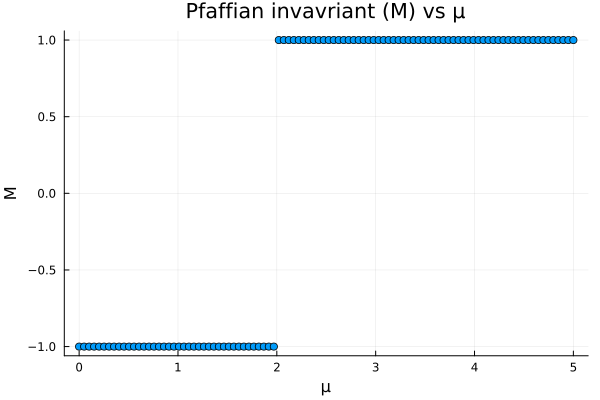

In [7]:
function calc_pfaff_invariant(N::Int, t_n::Vector{Float64}, mu_values::Vector{Float64}, Delta::Float64, sequence::Vector{Int})
    
    pfaff_invariant_values = Float64[]

    for mu in mu_values
        H = create_majorana_hamiltonian_generalised_OBC(N, t_n, mu, Delta, sequence)
        Pf_H = Pfaffian(H, overwrite_A=false, skewsymtol=1e-2)
        
        if imag(Pf_H) == 0.0
            M = sign(real(Pf_H))
            push!(pfaff_invariant_values, M)
        else
            error("Pfaffian has a non-zero imaginary part: $(imag(Pf_H)). Check Hamiltonian construction.")
        end
    end

    return pfaff_invariant_values
end

function plot_pfaff_vs_mu(pfaff_invariant_values::Vector{Float64}, mu_values::Vector{Float64})
    plt = Plots.scatter(
        mu_values, pfaff_invariant_values,
        xlabel="μ",
        ylabel="M",
        title="Pfaffian invavriant (M) vs μ",
        grid=true,
        legend=false
    )
end

pfaff_invariants = calc_pfaff_invariant(N_pfaff, t_list_pfaff, mu_pfaff, Delta_pfaff, sequence_pfaff)

plot_pfaff_vs_mu(real_space_pfaff_invariant_values, mu_pfaff)

### Skew Symmetric Measure

In [8]:
function skewsymtest(A::Matrix{ComplexF64}, tolerance::Float64)
    test = A + transpose(A)

    if all(abs.(test) .< tolerance)
        return true
    else
        return false
    end
end

# skewsymtest(T, 0.1)

# Matrix(transpose(U_test))

skewsymtest (generic function with 1 method)

## Eigenvalues/vectors and Spatial Probability Distribution

In [9]:
"""
Functions finding the eigenvalue and eigenstates and probabilities for the Hamiltonian (has a function for both the ungeneralised and generalised t-varying quasicrystals)
"""
function calculate_majorana_polarisation_individual(eigenvectors::Matrix{ComplexF64})
    """
    Calculates the Majorana Polarisation (MP) for each eigenvector in the eigenvector matrix.
    
    Parameters:
    eigenvectors -- Matrix of eigenvectors (columns are eigenvectors).
    
    Returns:
    overall_MP -- Overall Majorana Polarisation, calculated as MP_L * MP_R for each eigenvector.
    """
    num_cols = size(eigenvectors, 2)
    num_rows = size(eigenvectors, 1)
    N = num_rows ÷ 2

    MP_L = zeros(Complex{Float64}, num_cols)
    MP_R = zeros(Complex{Float64}, num_cols)

    tau = 0.0 #1e-9im
    
    for n in 1:num_cols
        u = eigenvectors[1:N, n]
        v = eigenvectors[(N+1):2N, n]

        # println("u's: ", u)
        # println("v's: ", v)
        
        # MP_L: sum over left half of the chain
        numerator_L = sum(u[i] * conj(v[i]) + v[i] * conj(u[i]) for i in 1:(N÷2))
        denominator_L = sum(abs2(u[i]) + abs2(v[i]) for i in 1:(N÷2)) + tau
        MP_L[n] = real(numerator_L / denominator_L)
        
        # MP_R: sum over right half of the chain
        numerator_R = sum(u[i] * conj(v[i]) + v[i] * conj(u[i]) for i in ((N÷2)+1):N)
        denominator_R = sum(abs2(u[i]) + abs2(v[i]) for i in ((N÷2)+1):N) + tau
        MP_R[n] = real(numerator_R / denominator_R)

    end

    # printing_MP_L = MP_L[N]
    # printing_MP_R = MP_R[N]

    # println("MP_L, ", printing_MP_L)
    # println("MP_R, ", printing_MP_R)
    
    overall_MP = MP_L .* MP_R
    return overall_MP
end

function eigenvalue_finder_for_mu(N::Int, t1::Float64, t2::Float64, sequence::Vector{Int}, x_values::Vector{Float64}, Delta::Float64=1.0)
    """
    Computes the eigenvalues for a list of values of x = mu/t, given a fixed value of either mu or t.

    Parameters:
    N           -- Int: Number of atomic sites in the chain
    x_values    -- Vector{Float64}: List of values for the ratio mu/t (x)
    ref_value   -- Float64: Fixed reference value for either mu or t
    ref_param   -- String: The name of the parameter that is fixed: either 'mu' or 't'
    Delta       -- Float64: The value of the pairing constant (default is 1.0)

    Returns:
    results     -- Vector of dictionaries containing the results for each x
    """

    results::Vector{Dict{String, Any}} = []

    t_avg = (t1+t2) / 2

    for x in x_values

        H0 = create_normal_hamiltonian_quasi(N, t1, t2, x, sequence)
        pairing_matrix = create_pairing_matrix(N, Delta)
        BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)
        eigenvalues, eigenvectors = solve_bdg_hamiltonian(BdG)
        probabilities = calculate_probability_distributions_bdg(eigenvectors)

        # # make new versions fo these functions to integrate better into this loop
        # check_eigenvectors_normalisation(eigenvectors, 1e-15)
        # check_probability_normalisation(probabilities, N, 1e-15)
        

        push!(results, Dict(
            "mu_t_ratio" => x / t_avg,
            "mu_values" => x,
            "t1" => t1,
            "t2" => t2,
            "eigenvalues" => eigenvalues,
            "eigenvectors" => eigenvectors,
            "probabilities" => probabilities
        ))
    end

    return results
end

function eigenvalue_finder_for_mu_tn_generalised(N::Int, t_n::Vector{Float64}, sequence::Vector{Int}, x_values::Vector{Float64}, Delta::Float64=1.0)
    """
    Computes the eigenvalues for a list of values of x = mu/t, given a fixed value of either mu or t.

    Parameters:
    N           -- Number of atomic sites in the chain
    t_n         -- Vector of hopping terms
    sequence    -- Vector of integers indicating the sequence of hopping terms
    x_values    -- List of values for the ratio mu/t (x)
    Delta       -- The value of the pairing constant (default is 1.0)

    Returns:
    results     -- Vector of dictionaries containing the results for each x
    """

    results::Vector{Dict{String, Any}} = []

    @showprogress for x in x_values
        H0 = create_normal_hamiltonian_quasi_tn_generalised(N, t_n, x, sequence)
        pairing_matrix = create_pairing_matrix(N, Delta)
        BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)
        
        eigenvalues, eigenvectors = solve_bdg_hamiltonian(BdG)
        probabilities = calculate_probability_distributions_bdg(eigenvectors)
        mps = calculate_majorana_polarisation_individual(eigenvectors)

        push!(results, Dict(
            "mu_t_ratio" => x / t_n[1],
            "mu_values" => x,
            "t_n" => t_n,
            "eigenvalues" => eigenvalues,
            "E/t_1" => eigenvalues / t_n[1],
            "eigenvectors" => eigenvectors,
            "probabilities" => probabilities,
            "mps" => mps
        ))
    end

    return results
end



function calculate_paired_probabilities(results::Vector{Dict{String, Any}})
    """
    Calculates the paired probabilities for each result in the provided array.
    
    Parameters:
    results -- Array of dictionaries containing eigenvalues, eigenvectors, and probabilities
    
    Returns:
    Nothing; the results are modified in place to include paired probabilities.
    """
    for result in results
        probabilities = result["probabilities"]
        N = size(probabilities, 1)
        
        paired_probabilities = zeros(Float64, N)

        for n in 1:N
            # paired_probabilities[n] = probabilities[n, N] + probabilities[n, N + 1]
            paired_probabilities[n] = probabilities[n, N-1] + probabilities[n, N + 2]
        end
        
        result["paired_probabilities"] = paired_probabilities
        # println(paired_probabilities)
    end
end

function calculate_paired_eigenvectors(results::Vector{Dict{String, Any}})
    """
    Calculates the paired eigenvectors for each result in the provided array. The eigenvectors are paired such that
    the original 2Nx2N eigenvector matrix is reduced to an NxN matrix by pairing the rows and columns.
    
    Parameters:
    results -- Array of dictionaries containing eigenvalues, eigenvectors, and probabilities
    
    Returns:
    Nothing; the results are modified in place to include paired eigenvectors as NxN matrices.
    """
    for result in results
        eigenvectors = result["eigenvectors"]
        N = size(eigenvectors, 1) ÷ 2
        
        paired_eigenvectors = zeros(ComplexF64, N, N)

        for i in 1:N
            for j in 1:N
                paired_eigenvectors[i, j] = eigenvectors[i, j] + eigenvectors[N + i, N + j]
            end
        end

        result["paired_eigenvectors"] = paired_eigenvectors
    end
end




# Hamiltonain parameters
N_cell2 = 50
t_list_cell2 = [1.0]#, 2.0]#, 2.5]#, 2.5] #t_list
mu_values_cell2 =  [0.5, 1.8, 2.3] #collect(range(0.0, 2.0, 501))
Delta_cell2 = 1.0 #Delta
sequence_cell2 = normal_sequence


# results = eigenvalue_finder_for_mu(N, t1, t2, sequence, mu_values, Delta)
results = eigenvalue_finder_for_mu_tn_generalised(N_cell2, t_list_cell2, sequence_cell2, mu_values_cell2, Delta_cell2)
# println(results)
# println(typeof(results))

calculate_paired_probabilities(results)
# # println(results)

# calculate_paired_eigenvectors(results)

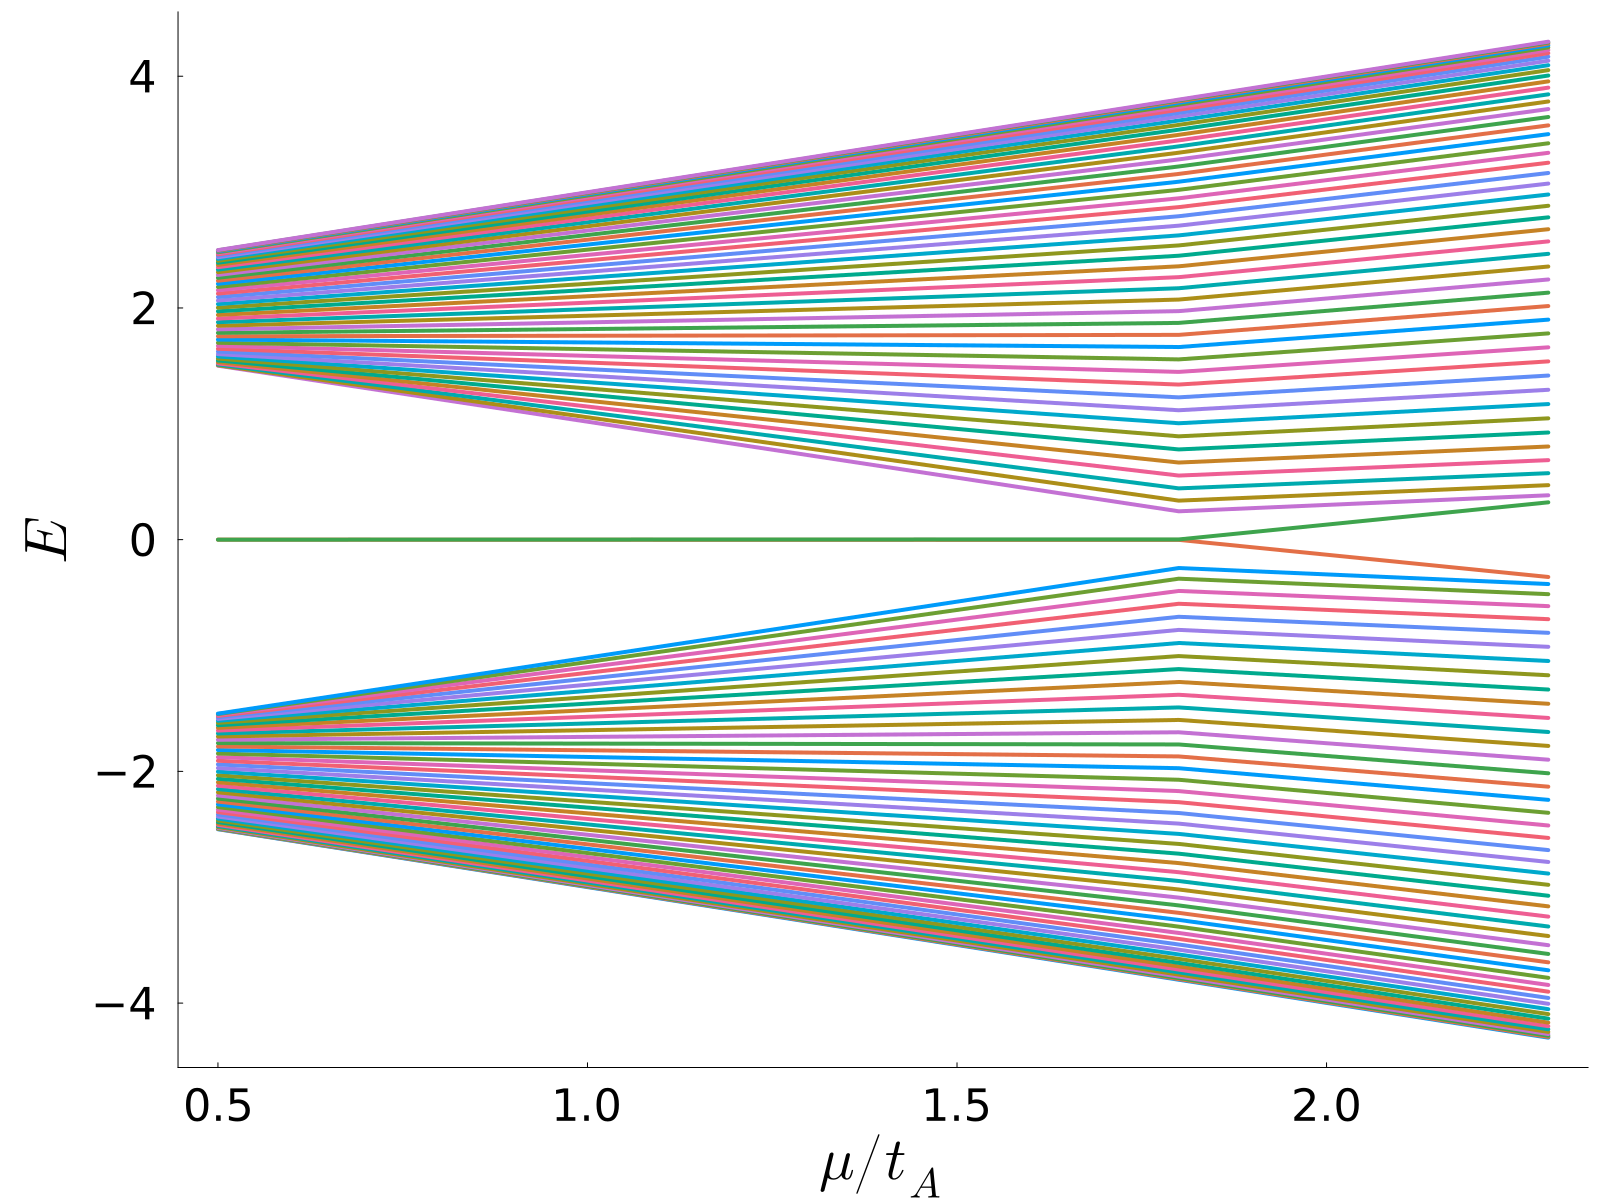

In [10]:
"""
Functions to plot the eigenvalues and spatial probability distributions of the Hamiltonian (compatible with both generalised and ungeneralised t-varying quasicrystals)
"""

function plot_eigenvalues_Plots(results::Vector{Dict{String, Any}}, fileindex::Int, N::Int, Delta::Float64, t_list::Vector{Float64}, variable::String = "mu_t_ratio", eigenvalues_column::String = "eigenvalues")
    """
    Plots eigenvalues as a function of mu.

    Parameters:
    results             -- Vector of dictionaries containing results.
    variable            -- String: The variable used for the x-axis (mu_t_ratio).
    eigenvalues_column  -- String: The column containing eigenvalues.
    """

    plt = Plots.scatter(
        legend=false, 
        xlabel=L"\mu/t_A", 
        ylabel=L"E", 
        # title="PQC, N=$N, Delta=$Delta, rho=$(t_list[2])", 
        grid=false,
        size=(1600, 1200),
        labelfontsize = 40,
        tickfontsize = 30,
        left_margin=10mm,
        bottom_margin=5mm,
        # top_margin=5mm
    )
    
    x_values = [result[variable] for result in results]
    all_eigenvalues = [result[eigenvalues_column] for result in results]
    
    num_eigenvalues = length(all_eigenvalues[1])
    
    for i in 1:num_eigenvalues
        eigenvalue_line = [eigenvalues[i] for eigenvalues in all_eigenvalues]
        
        plot!(x_values, eigenvalue_line, lw=4.0)#, marker=:circle, ms=2, alpha=0.7)
    end
    # ylims!(-4.0, 4.0)

    display(plt)

    # filename = "/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/NC_eigs_$fileindex.png"
    # Plots.savefig(plt, filename)
end

function plot_eigenvalues_PyPlot(results::Vector{Dict{String, Any}}, fileindex::Int, N::Int, Delta::Float64, t_list::Vector{Float64}, variable::String = "mu_t_ratio", eigenvalues_column::String = "eigenvalues")
    """
    Plots eigenvalues as a function of mu using PyPlot.

    Parameters:
    results             -- Vector of dictionaries containing results.
    variable            -- String: The variable used for the x-axis (mu_t_ratio).
    eigenvalues_column  -- String: The column containing eigenvalues.
    """
    
    # Set up the figure
    fig, ax = subplots(figsize=(8, 6))
    ax.set_xlabel(L"\mu / t_A", fontsize=14)
    ax.set_ylabel(L"E", fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=12)
    
    # Extract data for plotting
    x_values = [result[variable] for result in results]
    all_eigenvalues = [result[eigenvalues_column] for result in results]
    num_eigenvalues = length(all_eigenvalues[1])

    # Plot each eigenvalue line
    for i in 1:num_eigenvalues
        eigenvalue_line = [eigenvalues[i] for eigenvalues in all_eigenvalues]
        ax.plot(x_values, eigenvalue_line, linewidth=2.0)
    end
    
    # Save the plot to file
    filename = "/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/NC_eigs_$fileindex.png"
    fig.savefig(filename, bbox_inches="tight", dpi=600)

end


# # Function to plot paired probabilities for each mu value
function plot_paired_probabilities(results::Vector{Dict{String, Any}}, N::Int)
    """
    Plots paired probabilities for each mu/t_ratio on the same plot as line plots.

    Parameters:
    results -- Vector of dictionaries containing mu_values and paired_probabilities.
    N       -- Int: Number of sites in the chain.
    """  

    plt = Plots.plot(
        legend=true, 
        xlabel=L"j", 
        ylabel=L"|u_j|^2 + |v_j|^2", #L"||\gamma\rangle|^2", 
        # title="Paired Probabilities vs Site Index", 
        grid=false,
        size=(1600,1200),
        labelfontsize = 40,
        tickfontsize = 30,
        legendfontsize = 30,
        left_margin=10mm,
        bottom_margin=5mm
    )

    for (i, result) in enumerate(results)
        mu_value = result["mu_t_ratio"]
        paired_probabilities = result["paired_probabilities"]

        # s1 = L"\mu/t_A ="
        # s2 = L"$mu_value"
        # s = "$s1 $s2"
        s1 = L"\mu/t_A = 0.5"
        s2 = L"\mu/t_A = 1.8"
        s3 = L"\mu/t_A = 2.3"
        ss = [s1, s2, s3]
        plot!(1:N, paired_probabilities, label=ss[i], lw=4.0)

    end
    display(plt)

    filename = "/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/NC_prob_dist_deloc.png"
    Plots.savefig(plt, filename)
end

# # Plot eigenvalues
plot_eigenvalues_Plots(results, 6, N_cell2, Delta_cell2, t_list_cell2, "mu_t_ratio", "eigenvalues")
# plot_paired_probabilities(results, N_cell2)



Code for plotting the eigenvalues and Pfaffian together for Normal Crystal:

In [11]:
function eigs_and_pfaff(
    results::Vector{Dict{String, Any}}, 
    fileindex::Int, 
    N::Int, 
    Delta::Float64, 
    t_list::Vector{Float64}, 
    sequence_name::String, 
    variable::String, 
    eigenvalues_column::String,
    mu_pfaff::Vector{Float64}, 
    real_space_pfaff_invariant_values::Vector{Float64}
)
    """
    Plots eigenvalues as a function of μ/t on the primary y-axis and MP middle on a secondary y-axis.

    Parameters:
    results             -- Vector of dictionaries containing results.
    fileindex           -- Int: Index for saving the file.
    variable            -- String: The variable used for the x-axis (default: "mu_t_ratio").
    eigenvalues_column  -- String: The column containing eigenvalues (default: "eigenvalues").
    """

    fig, ax1 = plt.subplots(figsize=(6, 4))  # Create main figure and first axis

    # ax1.set_title("$sequence_name, N=$N, Delta=$Delta, rho=$(t_list[2])")

    x_values = [result[variable] for result in results]
    all_eigenvalues = [result[eigenvalues_column] for result in results]
    
    num_eigenvalues = length(all_eigenvalues[1])
    
    # for i in 1:num_eigenvalues
    #     eigenvalue_line = [eigenvalues[i] for eigenvalues in all_eigenvalues]
        
    #     plot!(x_values, eigenvalue_line)#, marker=:circle, ms=2, alpha=0.7)
    # end

    # Plot eigenvalues on primary y-axis
    ax1.set_xlabel(L"\mu/t_A", fontsize=10)
    ax1.set_xlim(0.0,5.0)
    ax1.set_ylabel(L"$E$", color="C0", fontsize=10)
    ax1.grid(false)
    
    # for i in 1:num_eigenvalues
    #     eigenvalue_line = [eigenvalues[i] for eigenvalues in all_eigenvalues]
    #     ax1.plot(x_values, eigenvalue_line, linewidth=1.0, color="C0")#, alpha=0.7)  # Eigenvalues in blue
    # end

    middle_indices = [Int(num_eigenvalues / 2), Int(num_eigenvalues / 2) + 1] # Indices of the middle two eigenvalues

    for i in 1:num_eigenvalues
        eigenvalue_line = [eigenvalues[i] for eigenvalues in all_eigenvalues]
        
        if i in middle_indices
            # Plot the middle two eigenvalues in red
            ax1.plot(x_values, eigenvalue_line, linewidth=1.5, color="C0")
        else
            # Plot the remaining eigenvalues in blue
            ax1.plot(x_values, eigenvalue_line, linewidth=0.7, color="C0")
        end
    end

    # Create secondary y-axis for Pfaff values
    ax2 = ax1.twinx()  
    ax2.set_ylabel(L"\mathcal{P}", color="C1", fontsize=14)
    ax2.set_ylim(-1.01, 1.01)
    ax2.plot(mu_pfaff, real_space_pfaff_invariant_values, color="C1", alpha=1.0)

    fig.tight_layout()

    # Save plot
    filename = "/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/$(sequence_name)_eigs_pfaff_$fileindex.png"
    fig.savefig(filename, dpi=1600)
    # println("Saved plot as $filename")

    # plt.show()
end


# Example usage:

eigs_and_pfaff(results, 1, N_cell2, Delta_cell2, t_list_cell2, "NC", "mu_t_ratio", "eigenvalues", mu_pfaff, real_space_pfaff_invariant_values)

# plot_eigenvalues(results, 0, N_cell2, Delta_cell2, t_list_cell2, "mu_t_ratio", "eigenvalues")



In [12]:
"""
function to create a series of eigenvalue and MP plots for varying Delta
"""

function plot_eigenvalues_mp(results::Vector{Dict{String, Any}}, fileindex::Int, N::Int, Delta::Float64, t_list::Vector{Float64}, sequence_name::String, variable::String = "mu_t_ratio", eigenvalues_column::String = "eigenvalues")
    """
    Plots eigenvalues as a function of μ/t on the primary y-axis and MP middle on a secondary y-axis.

    Parameters:
    results             -- Vector of dictionaries containing results.
    fileindex           -- Int: Index for saving the file.
    variable            -- String: The variable used for the x-axis (default: "mu_t_ratio").
    eigenvalues_column  -- String: The column containing eigenvalues (default: "eigenvalues").
    """

    fig, ax1 = plt.subplots(figsize=(8, 6))  # Create main figure and first axis

    ax1.set_title("$sequence_name, N=$N, Delta=$Delta, rho=$(t_list[2])")

    # Extract x values (μ/t ratios)
    x_values = [result[variable] for result in results]
    all_eigenvalues = [result[eigenvalues_column] for result in results]

    num_eigenvalues = length(all_eigenvalues[1])

    # Plot eigenvalues on primary y-axis
    ax1.set_xlabel("μ/t")
    ax1.set_ylabel("Eigenvalues", color="C0")
    ax1.grid(true)
    
    for i in 1:num_eigenvalues
        eigenvalue_line = [eigenvalues[i] for eigenvalues in all_eigenvalues]
        ax1.plot(x_values, eigenvalue_line, linewidth=0.7)#, color="C0", alpha=0.7)  # Eigenvalues in blue
    end

    # Extract MP middle values
    mu_t_ratios = [row["mu_t_ratio"] for row in results]
    mp_values = [row["mps"] for row in results]
    
    middle_index = div(length(mp_values[1]), 2)
    mp_middle = [real(mp[middle_index]) for mp in mp_values]

    # Create secondary y-axis for MP middle values
    ax2 = ax1.twinx()  
    ax2.set_ylabel("MP", color="C1")
    ax2.set_ylim(-1.0, 0.0)
    ax2.plot(mu_t_ratios, mp_middle, color="C1", alpha=0.7)

    fig.tight_layout()

    # Save plot
    filename = "GQC_eigs_mp_$fileindex.png"
    fig.savefig(filename)
    # println("Saved plot as $filename")

    # plt.show()
end

function series_of_plots(variable_list::Vector{Float64})

    N = 100
    t_list = [1.0, 2.0]#, 2.0] #t_list
    mu_values =  collect(range(0.0, 4.0, 401))
    sequence = golden_sequence
    sequence_name = "GQC"

    @showprogress for (i, Delta) in enumerate(variable_list)
        results = eigenvalue_finder_for_mu_tn_generalised(N, t_list, sequence, mu_values, Delta)

        # plot_eigenvalues(results, i, N, Delta, t_list, "mu_t_ratio", "eigenvalues")
        plot_eigenvalues_mp(results, i, N, Delta, t_list, sequence_name, "mu_t_ratio", "eigenvalues")
    end
end

function hp_plot_eigenvalues_mp(
    results::Dict{Any, Any}, 
    fileindex::Int, 
    N::Int, 
    Delta::Float64, 
    t_list::Vector{Float64}, 
    sequence_name::String, 
    variable::String, 
    eigenvalues_column::String,
)
    """
    Plots eigenvalues as a function of μ/t on the primary y-axis and MP middle on a secondary y-axis.

    Parameters:
    results             -- Vector of dictionaries containing results.
    fileindex           -- Int: Index for saving the file.
    variable            -- String: The variable used for the x-axis (default: "mu_t_ratio").
    eigenvalues_column  -- String: The column containing eigenvalues (default: "eigenvalues").
    """

    fig, ax1 = plt.subplots(figsize=(8, 6))  # Create main figure and first axis

    ax1.set_title("$sequence_name, N=$N, Delta=$Delta, rho=$(t_list[2])")

    mu_values = []
    overall_MP = []
    eigenvalues = []

    for (key, row) in results
        mu = key[3]  # Accessing the third element of the tuple key for mu
        push!(mu_values, mu)
        push!(overall_MP, row["overall_MP_values"])
        push!(eigenvalues, row["eigenvalues"])
    end

    println("length of mu values: $(length(mu_values))")
    println("length of MP values: $(length(overall_MP))")
    println("length of eigs list: $(length(eigenvalues))")

    # Sorting the mu values from smallest to largest, then the other quantities accordingly
    sorted_indices = sortperm(mu_values)
    sorted_mu_values = mu_values[sorted_indices]
    sorted_overall_MP = [overall_MP[i] for i in sorted_indices]
    sorted_eigenvalues = [eigenvalues[i] for i in sorted_indices]
 
    # Extract specific index for all plotted values
    middle_index = div(length(overall_MP[1]), 2)

    mid_overall_MP_values = [sorted_overall_MP[i][middle_index] for i in 1:length(sorted_mu_values)]
    # mid_eigenvalues_values = [sorted_eigenvalues[i][middle_index] for i in 1:length(sorted_mu_values)]


    num_eigenvalues = length(sorted_eigenvalues[1])
    println("num eigs: $num_eigenvalues")
    eigenvalue_lines = [ [sorted_eigenvalues[i][j] for i in 1:length(sorted_mu_values)] for j in 1:num_eigenvalues ]
    println("length of eig lines: $(length(eigenvalue_lines))")

    # Plot eigenvalues on primary y-axis
    ax1.set_xlabel("μ/t")
    ax1.set_ylabel("Eigenvalues", color="C0")
    ax1.grid(true)
    
    # for i in 1:num_eigenvalues
    #     eigenvalue_line = [eigenvalues[i] for eigenvalues in sorted_eigenvalues]
    #     ax1.plot(sorted_mu_values, eigenvalue_line, linewidth=0.7)#, color="C0", alpha=0.7)  # Eigenvalues in blue
    # end
    for line in eigenvalue_lines
        ax1.plot(sorted_mu_values, line, linewidth=0.7)#, color="C0", alpha=0.7)
    end
    
    # Create secondary y-axis for MP middle values
    ax2 = ax1.twinx()  
    ax2.set_ylabel("MP", color="C1")
    ax2.set_ylim(-1.01, 0.01)
    ax2.plot(sorted_mu_values, mid_overall_MP_values, color="C1", alpha=0.7)

    fig.tight_layout()

    # Save plot
    filename = "GQC_eigs_mp_$fileindex.png"
    fig.savefig(filename, dpi=1600)
    # println("Saved plot as $filename")

    # plt.show()
end

function hp_series_of_plots(variable_list::Vector{Float64})

    N_range = [5]
    N = N_range[1]

    t1_range = collect(range(1.0, 1.0, 1))
    t2_range = collect(range(2.0, 2.0, 1))
    t_ranges = [t1_range, t2_range]
    t_combinations = t_ranges_combinations(t_ranges)

    mu_values =  collect(range(0.0, 3.0, 2))
    sequence = golden_sequence
    sequence_name = "GQC"

    BigFloat_precision = 512

    @showprogress for (i, Delta) in enumerate(variable_list)
        Delta_range = [Delta]

        # println(typeof(Delta_range))

        here = high_precision_eigensolver(N_range, t_combinations, mu_values, Delta_range, sequence, BigFloat_precision)
        hp_results = high_precision_mp_solver(here)


        print_results_structure(hp_results)
        
        t_list = t_combinations[1]
        hp_plot_eigenvalues_mp(hp_results, i, N, Delta, t_list, sequence_name, "mu_t_ratio", "eigenvalues")
    end
end




Delta_list = [1.0] #vcat(collect(range(5.0, 3.0, 3)), collect(range(2.0, 0.1, 20)), collect(range(0.09, 0.0, 10)))
# series_of_plots(Delta_list)
println(Delta_list)

hp_series_of_plots(Delta_list)

[1.0]


UndefVarError: UndefVarError: `high_precision_eigensolver` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
function extract_eigs_for_mu(results::Vector{Dict{String, Any}}, fileindex::Int, N::Int, Delta::Float64, t_list::Vector{Float64}, variable::String = "mu_t_ratio", eigenvalues_column::String = "eigenvalues")
    """
    Plots eigenvalues as a function of mu.

    Parameters:
    results             -- Vector of dictionaries containing results.
    variable            -- String: The variable used for the x-axis (mu_t_ratio).
    eigenvalues_column  -- String: The column containing eigenvalues.
    """

    plt = Plots.scatter(
        legend=false, 
        xlabel="μ/t", 
        ylabel="E", 
        title="PQC, N=$N, Delta=$Delta, rho=$(t_list[2])", 
        grid=true,
        size=(800, 600)
    )
    
    x_values = [result[variable] for result in results]
    all_eigenvalues = [result[eigenvalues_column] for result in results]
    

Base.Meta.ParseError: ParseError:
# Error @ /Users/Will/Documents/FINAL_PROJECT/simulations/working_notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X30sZmlsZQ==.jl:22:5
    all_eigenvalues = [result[eigenvalues_column] for result in results]
    
#   └ ── Expected `end`

## LDOS and DOS

Below claculations of LDOS and DOS

The LDOS at site $i$ over energy range $E$ is given by this
\begin{equation}
    \begin{split}
        LDOS(i, E) &= \sum_{n} |\psi(x)|^2 \delta(E-E_n) \\
        &= \sum_{n} (|u_n(i)|^2 + |v_n(i)^2|)\delta(E-E_n) \\
        &\approx  \sum_{n} (|u_n(i)|^2 + |v_n(i)^2|) \text{exp} \Big( {\frac{-(E-E_n)^2}{2 \delta^2}} \Big)
    \end{split}
\end{equation}
where we need to extract the particle and hole symmetric parts of $H_{BDG}$ and take the absolute magnitudes squared separately. Also approximating the delta function to a narrow gaussian with parameter $\delta$.

In theory the approximation should become exact in this limit
\begin{equation}
    \begin{split}
        \delta(E-E_n) = \lim_{\delta \to 0} \frac{1}{ \sqrt{2 \pi \delta^2}} \text{exp}\Big ({\frac{-(E-E_n)^2}{2 \delta^2}} \Big)
    \end{split}
\end{equation}

In [14]:
"""
Function for calculating the LDOS and DOS. Compatible with both generalised and ungeneralised t-varying quasicrystals.
calculate_ldos_and_total_dos! function updates an input results dictionary, choose this to eoither be the global dictionary <results>
or a new local dictionary <results_LDOS> for different parameters
"""

function calculate_ldos_and_total_dos!(results::Vector{Dict{String, Any}}, N::Int, energy_range::Vector{Float64}, delta::Float64=0.01)
    """
    Calculate the Local Density of States (LDOS) for each site and the total DOS across all sites
    for all entries in the results object. Updates the `results` structure in-place by adding `ldos`
    and `total_dos` as new columns.

    Args:
        results: Array of dictionaries containing eigenvalues, paired_eigenvectors, and probabilities.
        N: Total number of sites in the chain.
        energy_range: Array of energies at which to calculate LDOS (1D array).
        delta: Width of the Gaussian used to approximate the delta function (default is 0.01).

    Modifies:
        Adds `ldos` (N x length(energy_range) arrays) and `total_dos` (1D arrays) to each dictionary in `results`.
    """
    for result in results
        eigenvalues = result["eigenvalues"]
        eigenvectors = result["eigenvectors"]

        num_cols = size(eigenvectors, 2)
        has_particle_hole = (num_cols == 2 * N)
        
        ldos_matrix = zeros(Float64, N, length(energy_range))
        
        for n in 1:length(eigenvalues)
            energy = eigenvalues[n]
            for site_index in 1:N
                u_i = eigenvectors[n, site_index]
                v_i = has_particle_hole && site_index <= N ? eigenvectors[n, N + site_index] : 0
                ldos_matrix[site_index, :] .+= (abs(u_i)^2 + abs(v_i)^2) * exp.(-(energy_range .- energy).^2 / (2 * delta^2))
            end
        end

        # Calculate total DOS and store results in the dictionary
        total_dos = sum(ldos_matrix, dims=1)[:]
        result["ldos"] = ldos_matrix
        result["total_dos"] = total_dos

        normalised_total_dos = atan.(total_dos ./ N)
        result["normalised_total_dos"] = normalised_total_dos
    end
end


# # # Hamiltonian parameters
# N_LDOS = N
# t_list_LDOS = t_list
# mu_values_LDOS = collect(range(0.0, stop=2.7, length=10)) #mu_values
# Delta_LDOS = Delta
# sequence_LDOS = sequence

# # # LDOS parameters
# energy_min_LDOS = energy_min_LDOS_global
# energy_max_LDOS = energy_max_LDOS_global
# energy_range_LDOS = collect(range(-5.0, 5.0, 5000)) #energy_range_LDOS_global
# delta_LDOS = 0.01 #delta

# # # Choose to use the global results dict or create a new one with different Hamiltonian parameters
# results_LDOS = eigenvalue_finder_for_mu_tn_generalised(N_LDOS, t_list_LDOS, sequence_LDOS, mu_values_LDOS, Delta_LDOS)
# # pre_results_LDOS = results

# calculate_ldos_and_total_dos!(results_LDOS, N_LDOS, energy_range_LDOS, delta_LDOS)

calculate_ldos_and_total_dos! (generic function with 2 methods)

In [15]:
"""
Plotting fucntions for total DOS from the updated results dict
"""

function plot_total_dos_separately(energy_range::Vector{Float64}, results::Vector{Dict{String, Any}})
    """
    Plot and save the total DOS for each entry in the results object, using the `total_dos` values
    stored in each result's dictionary.

    Args:
        energy_range: Array of energies at which the total DOS is calculated (1D array).
        results: Array of dictionaries with information about each result entry, including `total_dos`.
    """
    for (i, result) in enumerate(results)
        
        total_dos = result["total_dos"]
        formatted_mu_t_ratio = @sprintf("%.2f", result["mu_t_ratio"])
        
        plt = Plots.plot(
            energy_range,
            total_dos,
            xlabel="Energy", 
            ylabel="Total DOS", 
            title="Total Density of States (mu/t = $(formatted_mu_t_ratio))", 
            legend=false, 
            grid=true
        )
        
        # Save plot (uncomment to save as PNG)
        # filename = "total_dos_mut$formatted_mu_t_ratio.png"
        # savefig(plt, filename)
        
        display(plt)
    end
end

function plot_total_dos_superplot(energy_range::Vector{Float64}, results::Vector{Dict{String, Any}})
    """
    Plot all total DOS entries in a superplot grid layout, using the `total_dos` values stored
    in each result's dictionary.

    Args:
        energy_range: Array of energies at which the total DOS is calculated (1D array).
        results: Array of dictionaries with information about each result entry, including `total_dos`.
    """
    n_plots = length(results)
    
    # Set layout for the grid of subplots
    n_cols = ceil(2)#Int, sqrt(n_plots))
    n_rows = ceil(Int, n_plots / n_cols)
    
    plot_list = []

    for (i, result) in enumerate(results)
        if !haskey(result, "total_dos")
            println("Warning: `total_dos` not found for result entry $i. Skipping.")
            continue
        end
        
        total_dos = result["total_dos"]
        formatted_mu_t_ratio = @sprintf("%.2f", result["mu_t_ratio"])
        
        plt = Plots.plot(
            energy_range, 
            total_dos, 
            xlabel="Energy", 
            ylabel="Total DOS", 
            title="Total DOS (mu/t = $(formatted_mu_t_ratio))", 
            legend=false, 
            grid=true
        )
        
        push!(plot_list, plt)
    end

    if !isempty(plot_list)
        superplot = Plots.plot(
            plot_list...,
            layout=(n_rows, n_cols),
            size=(900, 1750),
            colorbar=true,
            colorbar_stretch=:vertical
        )
        
        # Plots.savefig(superplot, "dos_superplot.png")
        display(superplot)
    else
        println("No valid `total_dos` entries to plot.")
    end
end

# # Plot total DOS for mu/t values
# plot_total_dos_separately(energy_range_LDOS, results_LDOS)
plot_total_dos_superplot(energy_range_LDOS, results_LDOS)

UndefVarError: UndefVarError: `energy_range_LDOS` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Fractal Dimension

There is a lot in here on implementing and benchmarkign two different fractal dimension calcs: the standard box-counting method and the derivative box-counting method (derived form Fraxanet paper).

Goes on to implement VAR method from "Evaluating the fractal dimension of profiles" paper referenced in Fraxnet (note they misreferenced here, the paper suggested above two methods are bad and VAR is improved method)

In [16]:
function linear_function(x::Vector{Float64}, p::Vector{Float64})
    return p[1] .+ (p[2] .* x)
end

function linear_fit(x_values::Vector{Float64}, y_values::Vector{Float64})
    # Design matrix with an intercept term
    A = hcat(ones(length(x_values)), x_values)

    # Perform the least-squares solution
    coeffs = A \ y_values

    # coeffs[1] is the intercept, coeffs[2] is the slope
    return coeffs
end

function eigenvalue_finder_for_N_tn_generalised(N_values::Vector{Int}, t_n::Vector{Float64}, mu::Float64, sequence::Vector{Int}, Delta::Float64=1.0)
    """
    Computes the eigenvalues for a range of N values, keeping other parameters fixed.

    Parameters:
    N_values    -- Vector of N values (number of sites in the chain).
    t_n         -- Vector of hopping terms.
    sequence    -- Vector of integers indicating the sequence of hopping terms.
    Delta       -- The value of the pairing constant (default is 1.0).

    Returns:
    results -- Vector of dictionaries containing the results for each N.
    """
    results = Vector{Dict{String, Any}}()

    for N in N_values
        H0 = create_normal_hamiltonian_quasi_tn_generalised(N, t_n, mu, sequence)
        pairing_matrix = create_pairing_matrix(N, Delta)
        BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)
        
        eigenvalues, eigenvectors = solve_bdg_hamiltonian(BdG)

        push!(results, Dict(
            "N" => N,
            "eigenvalues" => eigenvalues,
            "eigenvectors" => eigenvectors
        ))
    end

    return results
end

function calculate_ldos_and_total_dos_N!(results::Vector{Dict{String, Any}}, N_list::Vector{Int}, energy_range::Vector{Float64}, delta::Float64)
    """
    Calculate the Local Density of States (LDOS) for each site and the normalised total DOS across all sites
    for all entries in the results object. Updates the `results` structure in-place by adding `ldos`
    and `total_dos` as new columns.

    Args:
        results: Array of dictionaries containing eigenvalues, paired_eigenvectors, and probabilities.
        N_list: List of total number of states (chain lengths) for each entry in the results object.
        energy_range: Array of energies at which to calculate LDOS (1D array).
        delta: Width of the Gaussian used to approximate the delta function (default is 0.01).

    Modifies:
        Adds `ldos` (N x length(energy_range) arrays) and `total_dos` (1D arrays) to each dictionary in `results`.
    """
    for (i, result) in enumerate(results)

        N = N_list[i]

        eigenvalues = result["eigenvalues"]
        eigenvectors = result["eigenvectors"]

        num_cols = size(eigenvectors, 2)
        has_particle_hole = (num_cols == 2 * N)

        ldos_matrix = zeros(Float64, N, length(energy_range))

        for n in 1:length(eigenvalues)
            energy = eigenvalues[n]
            for site_index in 1:N
                u_i = eigenvectors[n, site_index]
                v_i = has_particle_hole && site_index <= N ? eigenvectors[n, N + site_index] : 0
                ldos_matrix[site_index, :] .+= (abs(u_i)^2 + abs(v_i)^2) * exp.(-(energy_range .- energy).^2 / (2 * delta^2))
            end
        end

        total_dos = sum(ldos_matrix, dims=1)[:]

        normalised_total_dos = atan.(total_dos ./ N)

        # println("N = $N")
        # println("DOS = $total_dos")
        # println("normalised DOS = $normalised_total_dos")
        # println("-----------------------------------")

        result["ldos"] = ldos_matrix
        result["total_dos"] = total_dos
        result["normalised_total_dos"] = normalised_total_dos
    end
end

function derivative_box_counting(x::Vector{Float64}, f::Vector{Float64}, resolutions::Vector{Int})
    """
    Calculate the fractal dimension of the DOS curve for a single row of results.

    Args:
        energy_range: Array of energies at which the DOS is calculated (1D array).
        total_dos: Array of total DOS values corresponding to the energy range (1D array).
        resolutions: Array of integer resolutions to use for box-counting.

    Returns:
        D: Fractal dimension of the DOS curve.
        log_rk: Logarithm of the box size (log(L/rk)).
        log_N: Logarithm of the number of boxes needed to cover the curve.
    """

    x_normalised = x#(x .- minimum(x)) ./ (maximum(x) - minimum(x))
    f_normalised = f#(f .- minimum(f)) ./ (maximum(f) - minimum(f))

    # Calculate the cumulative arc length
    arc_length = [0.0]
    for i in 2:length(x_normalised)
        dx = x_normalised[i] - x_normalised[i-1]
        dy = f_normalised[i] - f_normalised[i-1]
        arc_length = [arc_length; arc_length[end] + sqrt(dx^2 + dy^2)]
    end

    # # Calculate DOS' using the central difference method
    # dos_derivative = zeros(Float64, length(total_dos))
    # for i in 2:length(total_dos) - 1
    #     dos_derivative[i] = (total_dos[i + 1] - total_dos[i - 1]) / (energy_range[i + 1] - energy_range[i - 1])
    # end
    # # Handle endpoints
    # dos_derivative[1] = (total_dos[2] - total_dos[1]) / (energy_range[2] - energy_range[1])
    # dos_derivative[end] = (total_dos[end] - total_dos[end - 1]) / (energy_range[end] - energy_range[end - 1])

    # # calculate total_dos length
    x_step = (maximum(x_normalised) - minimum(x_normalised)) / (length(f_normalised) - 1)
    L = sum(sqrt(x_step^2 + (f_normalised[i + 1] - f_normalised[i])^2) for i in 1:length(f_normalised) - 1)
    # L = maximum(x_normalised) - minimum(x_normalised)

    # println("Length: Arclength = $(arc_length[end]), Difference length = $L")

    log_eps = Float64[]
    log_N = Float64[]
    
    for resolution in resolutions

        # epsilon = L / resolution
        epsilon = arc_length[end] / resolution
        N_count = 0.0
        
        # indices = collect(1:div(length(energy_range), resolution):length(energy_range))
        # energy_sampled = energy_range[indices]
        # dos_sampled = total_dos[indices]
        # dos_derivative_sampled = dos_derivative[indices]
        
        # # ddos_denergy = diff(dos_sampled) ./ diff(energy_sampled) # need to sample points from DOS and from DOS' (semi-continuous) to get derivative properly
        # # N_X_rk = sum(abs.(ddos_denergy))

        # N_X = sum(abs.(dos_sampled)) + sum(abs.(dos_derivative_sampled))




        # for i in 1:(resolution-1)
        #     x1 = (i - 1) * epsilon
        #     x2 = i * epsilon

        #     # Find the closest points in the x data
        #     idx1 = findall(x_normalised .>= x1)[1]
        #     idx2 = findall(x_normalised .>= x2)[1]

        #     if idx1 > length(f_normalised) || idx2 > length(f_normalised)
        #         continue
        #     end

        #     # Compute the derivative
        #     dx = x_normalised[idx2] - x_normalised[idx1]
        #     dy = f_normalised[idx2] - f_normalised[idx1]
        #     if dx != 0
        #         derivative = abs(dy / dx)
        #         N_count += derivative
        #     end
        # end


        # Sample equally spaced points along the arc length
        sampled_points = [0]
        while sampled_points[end] < arc_length[end]
            sampled_points = [sampled_points; sampled_points[end] + epsilon]
        end

        # Calculate derivatives at these equally spaced points
        for i in 1:(length(sampled_points) - 1)
            idx1 = findall(arc_length .<= sampled_points[i])[end]
            idx2 = findall(arc_length .<= sampled_points[i+1])[end]

            if idx1 > length(f_normalised) || idx2 > length(f_normalised)
                continue
            end

            # Compute the derivative
            dx = x_normalised[idx2] - x_normalised[idx1]
            dy = f_normalised[idx2] - f_normalised[idx1]
            if dx != 0
                derivative = abs(dy / dx)
                N_count += derivative
            end
        end
        
        push!(log_eps, log(epsilon))
        push!(log_N, log(N_count))
    end
    
    # # linear regression
    # A = hcat(ones(length(log_eps)), log_eps)
    # coeffs = A \ log_N
    # m = coeffs[2]

    fit = linear_fit(log_eps, log_N)
    m = fit[2]

    D = - m
    return D, fit, log_eps, log_N
end

function standard_box_counting(x::Vector{Float64}, f::Vector{Float64}, resolutions::Vector{Int})
    """
    Calculate the fractal dimension of a 1D curve using the box-counting method.

    Args:
        x: The x-axis values (1D array).
        f: The y-axis values corresponding to x (1D array).
        resolutions: Array of resolutions (number of boxes) to test.

    Returns:
        fractal_dimension: The estimated fractal dimension.
    """

    x_normalised = (x .- minimum(x)) ./ (maximum(x) - minimum(x))
    f_normalised = (f .- minimum(f)) ./ (maximum(f) - minimum(f))

    log_eps = Float64[]
    log_N = Float64[]
    
    # x_step = (maximum(x_normalised) - minimum(x_normalised)) / (length(f_normalised) - 1)
    # L = sum(sqrt(x_step^2 + (f_normalised[i + 1] - f_normalised[i])^2) for i in 1:length(f_normalised) - 1)
    L = maximum(x_normalised) - minimum(x_normalised)
    # println("curve length = $L")

    for resolution in resolutions

        epsilon = L / resolution

        box_counts = 0
        for i in 0:resolution-1

            x_min = i * epsilon
            x_max = (i + 1) * epsilon

            intersects = any((x_min .<= x_normalised) .& (x_normalised .< x_max) .& (f_normalised .> 0))

            if intersects
                box_counts += 1
            end
        end

        push!(log_eps, log(1 /epsilon))
        push!(log_N, log(box_counts))
    end

    fit = linear_fit(log_eps, log_N)
    # println("fit parameters: ", fit)

    # Fractal dimension (1 - slope)
    fractal_dimension = fit[2]

    return fractal_dimension, fit, log_eps, log_N
end

function calculate_dos_fractal_dimension!(energy_range::Vector{Float64}, results::Vector{Dict{String, Any}}, resolutions::Vector{Int}, variable_name::String, independent_variable)
    """
    Calculate and display the fractal dimension for the DOS of each mu/t parameter value.

    Args:
        energy_range: Array of energies at which the DOS is calculated (1D array).
        results: Array of dictionaries with information about each result entry, including `total_dos`.
        resolutions: Array of integer resolutions to use for box-counting.
    """
    for (i, result) in enumerate(results)
        total_dos = result["total_dos"]
        normalised_total_dos = result["normalised_total_dos"]
        
        # Calculate fractal dimension
        (D, fit_params, log_eps, log_N) = derivative_box_counting(energy_range, total_dos, resolutions)
        (D_norm, log_eps_norm, log_N_norm) = derivative_box_counting(energy_range, normalised_total_dos, resolutions)
        
        println("Fractal Dimension for $variable_name = $(independent_variable[i]): ", D)
        
        result["D"] = D
        result["log_eps"] = log_eps
        result["log_N"] = log_N

        result["D_norm"] = D_norm
        result["log_eps_norm"] = log_eps_norm
        result["log_N_norm"] = log_N_norm    
        
        plt = Plots.scatter(
            log_eps, log_N,
            xlabel = "log_eps",
            ylabel = "log_N",
            legend = true
        )
        fit_x_values = collect(range(minimum(log_eps), maximum(log_eps), 100))
        fitted_line = linear_function(fit_x_values, fit_params)

        Plots.plot!(
            plt, fit_x_values, fitted_line,
            label = "Dimension = $D"
        )
        Plots.savefig(plt, "D_calc_plot_for$(variable_name)$(independent_variable[i])")
        # display(plt)
    end
end

function create_gaussian_dos(energy_range::Vector{Float64}, center::Float64, width::Float64, amplitude::Float64=1.0)
    total_dos = amplitude .* exp.(-((energy_range .- center).^2) ./ (2 * width^2))
    return total_dos
end

function create_weierstrass_curve(energy_range::Vector{Float64}, a::Float64, b::Int, n_terms::Int)
    """
    Generate a Weierstrass function for given parameters.

    Args:
        energy_range: The x-axis values (1D array).
        a: The coefficient (0 < a < 1).
        b: The base of exponents (positive odd integer).
        n_terms: The number of terms in the series.

    Returns:
        weierstrass_curve: The generated Weierstrass function values (1D array).
    """
    weierstrass_curve = zeros(length(energy_range))

    for i in 1:length(energy_range)
        x = energy_range[i]
        for n in 0:n_terms
            weierstrass_curve[i] += a^n * cos(b^n * π * x)
        end
    end

    return weierstrass_curve
end




# # Hamiltonian parameters
N_values_LDOS_N = floor.(Int, collect(range(20,200,10)))
mu_LDOS_N = 1.0
t_list_LDOS_N = [1.0]#, 2.0]
Delta_LDOS_N = 1.0
sequence_LDOS_N = normal_sequence

test_energy_range = collect(range(-5.0, 5.0, 10000))
test_delta = 0.01

resolutions = floor.(Int, log_range(2.0, 5.0, 11.0, 7)) #collect(500:5:1000)
println("resolutions: $resolutions")

# results_LDOS_N = eigenvalue_finder_for_N_tn_generalised(N_values_LDOS_N, t_list_LDOS_N, mu_LDOS_N, sequence_LDOS_N, Delta_LDOS_N)

# calculate_ldos_and_total_dos_N!(results_LDOS_N, N_values_LDOS_N, test_energy_range, test_delta)

# # Calculate and display fractal dimensions
# variable_name = "N"
# calculate_dos_fractal_dimension!(energy_range_LDOS, results_LDOS_N, resolutions, variable_name, N_values_LDOS_N)




gaussian_resolution = 5000
gaussian_energy_range = collect(range(-5.0, 5.0, gaussian_resolution))
center = 0.0
width = 1.0
amplitude = 3.0
gaussian_total_dos = create_gaussian_dos(gaussian_energy_range, center, width, amplitude)

# weier_resolution = 5000
# weierstrass_energy_range = collect(range(-5.0, 5.0, weier_resolution))
# weier_amplitude = 0.4
# weier_b = 10
# n_terms = 10

# weierstrass_total_dos = create_weierstrass_curve(weierstrass_energy_range, weier_amplitude, weier_b, n_terms)

# estimated_weierstrass_D = 2 + (log(weier_amplitude) / log(weier_b))


# dos_results = []
# for (i, result) in enumerate(results_LDOS_N)
#     dos_result = result["total_dos"]
#     push!(dos_results, dos_result)
# end
# dos_result = dos_results[1]


(D, fit_params, log_eps, log_N) = derivative_box_counting(gaussian_energy_range, gaussian_total_dos, resolutions)
# (D, fit_params, log_eps, log_N) = derivative_box_counting(weierstrass_energy_range, weierstrass_total_dos, resolutions)
# (D, fit_params, log_eps, log_N) = derivative_box_counting(energy_range_LDOS, dos_result, resolutions)

println("fit_params: $fit_params")

# println("log_eps data: $log_eps")
# println("length of log_eps data: $(length(log_eps))")
# println("log_N data: $log_N")
# println("length of log_N data: $(length(log_N))")

println("Gaussian DOS benchmark: Fractal dimension = $D")
# println("Weierstrass DOS benchmark: Fractal dimension = $D")
# # println("NC DOS benchmark: Fractal dimension = $D")

# println("Weierstrass theoretical fractal dimension = $estimated_weierstrass_D (for a=$weier_amplitude, b=$weier_b)")

# function plot_benchmark_function(x::Vector{Float64}, y::Vector{Float64}, filename::String)
#     plt = Plots.plot(
#         x, y,
#         xlabel = "Mock Energy Range",
#         ylabel = "Test Function",
#         legend = false
#     )

#     Plots.savefig(plt, filename)
# end

# # filename = "Gaussian_res$gaussian_resolution"
# # plot_benchmark_function(gaussian_energy_range, gaussian_total_dos, filename)
# filename = "Weierstrass_res$(weier_resolution)"
# plot_benchmark_function(weierstrass_energy_range, weierstrass_total_dos, filename)



plt = Plots.scatter(
    log_eps, log_N,
    xlabel = "log_eps",
    ylabel = "log_N",
    legend = true
)
fit_x_values = collect(range(minimum(log_eps), maximum(log_eps), 100))
fitted_line = linear_function(fit_x_values, fit_params)

Plots.plot!(
    plt, fit_x_values, fitted_line,
    label = "Dimension = $D"
)

display(plt)


resolutions: [32, 64, 128, 256, 512, 1024, 2048]
fit_params: [2.318117792688832, -1.0008162150884006]
Gaussian DOS benchmark: Fractal dimension = 1.0008162150884006


ErrorException: cannot assign a value to imported variable PyPlot.plt from module Main

### Benchmarking and Statistics against Weierstrass

In [17]:
function fractal_dimension_calc_vs_theoretical(resolutions::Vector{Int}, a_list::Vector{Float64}, b_list::Vector{Int}, n_list::Vector{Int})
    
    function_resolution = 50000
    f_range = collect(range(-5.0, 5.0, function_resolution))

    results = Dict(
        "a" => Float64[],
        "b" => Int[],
        "n" => Int[],
        "D_theoretical" => Float64[],
        "D_calced" => Float64[],
        "difference" => Float64[]
    )

    @showprogress for a in a_list
        for b in b_list
            for n in n_list
                f = create_weierstrass_curve(f_range, a, b, n)

                e = 0.0
                D_theory = 2 + (log(a+e) / (log(b+e) + e))
                # (D_calc, fit_params, log_eps, log_N) = derivative_box_counting(f_range, f, resolutions)

                D_calc, log_scales, log_variances, fit_params = fractal_dimension_VAR(f, resolutions)

                difference = D_theory - D_calc

                push!(results["a"], a)
                push!(results["b"], b)
                push!(results["n"], n)
                push!(results["D_theoretical"], D_theory)
                push!(results["D_calced"], D_calc)
                push!(results["difference"], difference)
            end
        end
    end
    
    return results
end

resolutions = floor.(Int, log_range(2.0, 4.0, 10.0, 10))
a_list = collect(range(0.1, 1.0, 10))
b_list = floor.(Int, collect(range(3.0, 10.0, 8)))
n_list = floor.(Int, collect(range(5.0, 5.0, 1)))
              
benchmarking_results = fractal_dimension_calc_vs_theoretical(resolutions, a_list, b_list, n_list)


UndefVarError: UndefVarError: `fractal_dimension_VAR` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [18]:
function plot_single_variable_comparison(results::Dict{String, Vector}, vriable::String, fixed1::String, fixed1_value, fixed2::String, fixed2_value)

    indices = [i for i in 1:length(results[fixed1]) if results[fixed1][i] == fixed1_value && results[fixed2][i] == fixed2_value]
    
    x = [results[variable][i] for i in indices]
    y1 = [results["D_theoretical"][i] for i in indices]
    y2 = [results["D_calced"][i] for i in indices]

    plt = Plots.scatter(
        x, y1,
        xlabel = variable,
        ylabel = "Fractal Dimension",
        label = "theoretical",
        legend = true,
        title = "Varying $variable whilst fixing $fixed1 = $fixed1_value, $fixed2 = $fixed2_value"
    )

    Plots.scatter!(
        x, y2,
        label = "calculated"
    )

    display(plt)
end

function plot_two_variabe_heatmap(results::Dict{String, Vector}, variable1::String, variable2::String, fixed_variable::String, fixed_value)

    indices = [i for i in 1:length(results[fixed_variable]) if results[fixed_variable][i] == fixed_value]
    
    # Extract the values for the two variables and the "difference"
    x = [results[variable1][i] for i in indices]
    y = [results[variable2][i] for i in indices]
    z = [results["difference"][i] for i in indices]
    
    # Create a grid for the heatmap
    x_unique = unique(x)
    y_unique = unique(y)
    z_matrix = reshape(z, length(x_unique), length(y_unique))

    # Plot the heatmap
    heatmap(
        x_unique, y_unique, z_matrix',
        xlabel = variable1,
        ylabel = variable2,
        title = "Heatmap of Difference with $fixed_variable = $fixed_value",
        color = :viridis
    )
end

function calculate_statistics(results::Dict{String, Vector})
    """
    Calculate the average of the "difference" values and the average percentage error.
    Args:
        results: The dictionary containing the results.
    Returns:
        average_difference: The average of the "difference" values.
        average_percentage_error: The average percentage error between the theoretical and calculated values.
    """
    differences = results["difference"]
    D_theoretical = results["D_theoretical"]
    D_calced = results["D_calced"]

    average_difference = mean(abs.(differences))

    # Mean Absolute Percentage Error (MAPE)
    mape = mean([abs((D_theoretical[i] - D_calced[i]) / D_theoretical[i] * 100) for i in 1:length(D_theoretical)])

    # Root Mean Squared Error (RMSE)
    rmse = sqrt(mean([(D_theoretical[i] - D_calced[i])^2 for i in 1:length(D_theoretical)]))

    # Coefficient of Determination (R²)
    ss_tot = sum((D_theoretical .- mean(D_theoretical)).^2)
    ss_res = sum((D_theoretical .- D_calced).^2)
    r_squared = 1 - (ss_res / ss_tot)

    stats = Dict(
        "Avg_diff" => average_difference,
        "MAPE (%)" => mape,
        "RMSE" => rmse,
        "R_squared" => r_squared
    )
    return stats
end

stats = calculate_statistics(benchmarking_results)
println("Statistics on comparison between theoretical and calculated:")
for (stat, value) in stats
    println("$stat: $value")
end


# # single variable comparison plot usage
# variable = "a"
# fixed1 = "b"
# fixed1_value = 3
# fixed2 = "n"
# fixed2_value = 5
# plot_single_variable_comparison(benchmarking_results, variable, fixed1, fixed1_value, fixed2, fixed2_value)


# two variabel comparison plot usage
variable1 = "a"
variable2 = "b"
fixed_variable = "n"
fixed_variable_value = 5.0
plot_two_variabe_heatmap(benchmarking_results, variable1, variable2, fixed_variable, fixed_variable_value)


UndefVarError: UndefVarError: `benchmarking_results` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [19]:

function plot_fractal_dimension_vs_N(results::Vector{Dict{String, Any}}, N_list::Vector{Int})
    """
    Plot the fractal dimension D as a function of system size N.

    Args:
        results: Array of dictionaries with calculated `D` values.
        N_list: Array of system sizes corresponding to each result.
    """
    # Extract D and N values
    D_values = [result["D"] for result in results]
    D_values_norm = [result["D_norm"] for result in results]
    
    # Plot
    plt = Plots.plot(
        N_list, D_values,
        xlabel="System Size (N)",
        ylabel="Fractal Dimension (D)",
        title="Fractal Dimension vs System Size",
        label = "unnormalised D",
        legend=true,
        grid=true,
        marker=:circle,
        color=:blue
    )

    Plots.plot!(
        N_list, D_values_norm,
        label = "normalised D"
    )
    display(plt)
    # Plots.savefig(plt, "Fractal_dim_vs_N_low_res_DOS_delta1e-1")
end


plot_fractal_dimension_vs_N(results_LDOS_N, N_values_LDOS_N)

UndefVarError: UndefVarError: `results_LDOS_N` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [20]:
function plot_log_rk_vs_log_N(results::Vector{Dict{String, Any}})
    
    log_rk_values = [result["log_rk"] for result in results]
    log_N_values = [result["log_N"] for result in results]

    plt = Plots.plot(log_rk_values, log_N_values,
            xlabel="log(L/rk)", 
            ylabel="log(N(X, rk))"
    )
    display(plt)
end

plot_log_rk_vs_log_N(results_LDOS_N)

UndefVarError: UndefVarError: `results_LDOS_N` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [21]:
variable_name = "mu"
calculate_dos_fractal_dimension!(energy_range_LDOS, results_LDOS, resolutions, variable_name, mu_values_LDOS)

UndefVarError: UndefVarError: `energy_range_LDOS` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [22]:
function plot_fractal_dimension_vs_N(results::Vector{Dict{String, Any}}, mu_values::Vector{Float64})
    """
    Plot the fractal dimension D as a function of system size N.

    Args:
        results: Array of dictionaries with calculated `D` values.
        N_list: Array of system sizes corresponding to each result.
    """
    # Extract D and N values
    D_values = [result["D"] for result in results]
    D_values_norm = [result["D_norm"] for result in results]
    
    # Plot
    plt = Plots.plot(
        mu_values, D_values,
        xlabel="mu",
        ylabel="Fractal Dimension (D)",
        title="Fractal Dimension vs System Size",
        legend=false,
        grid=true,
        marker=:circle,
        color=:blue
    )

    Plots.plot!(
        mu_values, D_values_norm
    )
    display(plt)
end




plot_fractal_dimension_vs_N(results_LDOS, mu_values_LDOS)


UndefVarError: UndefVarError: `results_LDOS` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [23]:
input_range = collect(range(0.0, 1.0, 100))
output_values = atan.(input_range)

plt = Plots.plot(
    input_range, output_values,
    xlabel = "x",
    ylabel = "arctan(x)",
    title = "Checking linearity of arctan over input range, x",
    legend=false
)

display(plt)

ErrorException: cannot assign a value to imported variable PyPlot.plt from module Main

### VAR Calc

In [24]:
# Variance method to estimate the fractal dimension
function fractal_dimension_VAR(series::Vector{Float64}, scales::Vector{Int})
    variances = Float64[]
    
    for s in scales
        segments = reshape(series[1:(length(series) ÷ s) * s], s, :)
        local_means = mean(segments, dims=1)
        variance = mean((segments .- local_means).^2)
        push!(variances, variance)
    end
    
    log_scales = log.(scales)
    log_variances = log.(variances)
    
    slope, intercept = regress(log_scales, log_variances)
    fit_params = Float64[intercept, slope]
    fractal_dim = 2 - slope/2 
    
    return fractal_dim, log_scales, log_variances, fit_params
end


function regress(x::Vector{Float64}, y::Vector{Float64})
    X = [ones(length(x)) x]
    coeffs = X \ y 
    return coeffs[2], coeffs[1] # slope, intercept
end

function linear_fit(x_values::Vector{Float64}, y_values::Vector{Float64})
    A = hcat(ones(length(x_values)), x_values)
    coeffs = A \ y_values
    return coeffs
end

function linear_function(x::Vector{Float64}, p::Vector{Float64})
    return p[1] .+ (p[2] .* x)
end



function create_gaussian_dos(energy_range::Vector{Float64}, center::Float64, width::Float64, amplitude::Float64=1.0)
    total_dos = amplitude .* exp.(-((energy_range .- center).^2) ./ (2 * width^2))
    return total_dos
end

function create_weierstrass_curve(energy_range::Vector{Float64}, a::Float64, b::Int, n_terms::Int)
    """
    Generate a Weierstrass function for given parameters.

    Args:
        energy_range: The x-axis values (1D array).
        a: The coefficient (0 < a < 1).
        b: The base of exponents (positive odd integer).
        n_terms: The number of terms in the series.

    Returns:
        weierstrass_curve: The generated Weierstrass function values (1D array).
    """
    weierstrass_curve = zeros(length(energy_range))

    for i in 1:length(energy_range)
        x = energy_range[i]
        for n in 0:n_terms
            weierstrass_curve[i] += a^n * cos(b^n * π * x)
        end
    end

    return weierstrass_curve
end

function log_range(base::Float64, start_power::Float64, end_power::Float64, length::Int)
    powers = range(start_power, stop=end_power, length=length)
    values = base .^ powers
    return values
end


gaussian_resolution = 50000
gaussian_energy_range = collect(range(-5.0, 5.0, gaussian_resolution))
center = 0.0
width = 1.0
amplitude = 3.0
gaussian_total_dos = create_gaussian_dos(gaussian_energy_range, center, width, amplitude)

weier_resolution = 50000
weierstrass_energy_range = collect(range(-5.0, 5.0, weier_resolution))
weier_amplitude = 0.4
weier_b = 10
n_terms = 10
weierstrass_total_dos = create_weierstrass_curve(weierstrass_energy_range, weier_amplitude, weier_b, n_terms)

estimated_weierstrass_D = 2 + (log(weier_amplitude) / log(weier_b))
println("Theoretical Weierstrass Dimension: $estimated_weierstrass_D")


# Hamiltonian parameters
N_values_LDOS_N = floor.(Int, collect(range(20,200,10)))
mu_LDOS_N = 1.0
t_list_LDOS_N = [1.0]#, 2.0]
Delta_LDOS_N = 0.1
sequence_LDOS_N = normal_sequence

test_energy_range = collect(range(-5.0, 5.0, 5000))
test_delta = 0.15

resolutions = floor.(Int, log_range(2.0, 3.0, 14.0, 20)) #collect(5:5:2000)
println("resolutions: $resolutions")

# results_LDOS_N = eigenvalue_finder_for_N_tn_generalised(N_values_LDOS_N, t_list_LDOS_N, mu_LDOS_N, sequence_LDOS_N, Delta_LDOS_N)

# calculate_ldos_and_total_dos_N!(results_LDOS_N, N_values_LDOS_N, test_energy_range, test_delta)


dos_results = []
for (i, result) in enumerate(results_LDOS_N)
    dos_result = result["total_dos"]
    push!(dos_results, dos_result)
end
dos_result = dos_results[1]


# f = gaussian_total_dos
f = weierstrass_total_dos
# f = dos_result

# Compute fractal dimension
fractal_dim, log_scales, log_variances, fit_params = fractal_dimension_VAR(f, resolutions)
println("Estimated Fractal Dimension: ", fractal_dim)

# Plot log-log graph
plt = Plots.scatter(log_scales, log_variances, seriestype=:scatter, label="Data")

fit_x_values = collect(range(minimum(log_scales), maximum(log_scales), 1000))
fitted_line = linear_function(fit_x_values, fit_params)

Plots.plot!(
    plt, fit_x_values, fitted_line,
    label = "Dimension = $fractal_dim"
)
title!("Fractal Dimension Estimation (VAR Method)")
xlabel!("log(Scale)")
ylabel!("log(Variance)")
display(plt)








Theoretical Weierstrass Dimension: 1.6020599913279625
resolutions: [8, 11, 17, 26, 39, 59, 88, 132, 198, 296, 442, 660, 987, 1474, 2203, 3290, 4915, 7342, 10968, 16384]


UndefVarError: UndefVarError: `results_LDOS_N` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Spectral Function
reen's functions and spectral functions

Suppose we have a linear operator, $\hat{L}$, that represents a differential equation for example:

\begin{equation}
\hat{L}[y(x)] = y''(x) + y'(x) + y(x) = f(x)
\end{equation}

We can construct a Green's function, $G(x,x')$, for $\hat{L}$ which is defined as:

\begin{equation}
\hat{L}[G(x,x')] = G''(x,x') + G'(x,x') + G(x,x') = \delta(x-x')
\end{equation}

What is interesting about the Green's function is that it can be used to solve for any non-homogeneous equation (i.e. for finding a $y(x)$ that satisfies $\hat{L}[y(x)] = f(x)$) by evaluating the following integral:

\begin{equation}
y(x) = \int_{-\infty}^{\infty} G(x,x')f(x') \, dx'
\end{equation}

The above equation (3) can be checked by multiplying the left-hand and right-hand sides of equation (2) by $f(x')dx'$ (evaluating the integral on the right-hand side yields $f(x)$ and on the left-hand side $f(x')dx'$ can be brought into the operator $\hat{L}$ since the operator only acts on x and not on x' comparing the argument of the operator with equation (1) yields equation (3) as above). In quantum mechanics and in condensed matter the differential equation we are interested in solving is, of course, Schrodinger's equation. In condensed matter systems, the linear operator we are going to work with is actually a modified version of the Hamiltonian, $\hat{H} - E$. Evaluating $\hat{H} - E$ on $\psi(x)$ for the time-independent case yields:

\begin{equation}
(\hat{H} - E)[\psi(x)] = 0
\end{equation}

Applying the Hamiltonian to the Green's function and the corresponding integral to find $\psi(x)$:

\begin{gather}
(\hat{H} - E)[G(x,x')] = \delta(x-x') \\
\psi(x) = \int_{-\infty}^{\infty} G(x,x')\psi(x') \, dx'
\end{gather}

The above equation is known as the "single particle propogator" for the time-independent case of the Schrodinger equation. The reason we use $\hat{H} - E$ as opposed the just $\hat{H}$ is because, when we define the operator this way, we can very easily relate the imaginary part of the (retarded) Green's function to the spectral function, $A(\omega)$. Namely:

\begin{equation}
A({\omega}) = -\frac{1}{\pi}Im[G(\omega)]
\end{equation}

Here $G(\omega)$ represnts the (retarded) Green's function in momentum space i.e it is the Fourier transform of $G(x,x')$. The spectral function provides information about the density of states and can be interpreted as the probability of finding a particle with a given energy $\omega$.



In [25]:
"""
Ungeneralised Spectral function calculations (only for PV number quasicrystals with 2 hopping potentials, t1 & t2)
"""

function compute_spectral_function(N::Int, t1::Float64, t2::Float64, sequence::Vector{Int}, mu::Float64, delta::Float64, eta::Float64, omega_range::Vector{Float64})

    H0 = create_normal_hamiltonian_quasi(N, t1, t2, mu, sequence)
    pairing_matrix = create_pairing_matrix(N, Delta)
    BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)
    # eigenvalues, eigenvectors = solve_bdg_hamiltonian(BdG)
    # probabilities = calculate_probability_distributions_bdg(eigenvectors)

    spectral_values = zeros(N, length(omega_range))

    for j in 1:length(omega_range)
        omega = omega_range[j]

        G = inv((omega + im * eta) * I - BdG)

        # Separate particle and hole contributions
        for i in 1:N
            particle_contribution = -imag(G[i, i]) / π
            hole_contribution = -imag(G[N + i, N + i]) / π
            spectral_values[i, j] = particle_contribution + hole_contribution
        end
    end

    return spectral_values
end

function compute_spectral_function_for_mu_t_ratio(N::Int, t1::Float64, t2::Float64, sequence::Vector{Int}, delta::Float64, eta::Float64, omega_range::Vector{Float64}, mu_t_range::Vector{Float64})
    results = Dict{Float64, Matrix{Float64}}()

    t_avg = (t1 + t2) / 2

    for mu_t in mu_t_range
        mu = mu_t * t_avg
        spectral_values = compute_spectral_function(N, t1, t2, sequence, mu, delta, eta, omega_range)
        results[mu_t] = spectral_values
    end

    return results
end

# # # Usage
# eta = 0.1
# omega_range = collect(range(-0.5, 0.5, length=101))
# mu_t_range = collect(range(0.0, 3.0, length=11))
# t1 = 1.0
# t2 = 0.0
# sequence = golden_sequence
# Delta = 2.0

# # Compute the spectral function over sites for each mu/t ratio
# spectral_results = compute_spectral_function_for_mu_t_ratio(N, t1, t2, sequence, Delta, eta, omega_range, mu_t_range)
# # println(spectral_results_1)


compute_spectral_function_for_mu_t_ratio (generic function with 1 method)

In [26]:
"""
Generalised spectral function calculation for any t-varying quasicrystal
"""

function compute_spectral_function_tn_generalised(N::Int, t_n::Vector{Float64}, sequence::Vector{Int}, mu::Float64, delta::Float64, eta::Float64, omega_range::Vector{Float64})
    """
    Computes the spectral function for each site index across a range of energies.

    Parameters:
    N           -- Number of lattice sites
    t_n         -- Vector of hopping terms
    sequence    -- Vector of indices indicating the order of hopping terms
    mu          -- Chemical potential
    delta       -- Pairing term
    eta         -- Small imaginary value for Green's function calculation
    omega_range -- Vector of energy values to evaluate the spectral function

    Returns:
    spectral_values -- NxM matrix of spectral function values for each site and energy
    """
    H0 = create_normal_hamiltonian_quasi_tn_generalised(N, t_n, mu, sequence)
    pairing_matrix = create_pairing_matrix(N, delta)
    BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)

    spectral_values = zeros(N, length(omega_range))

    @showprogress for j in 1:length(omega_range)
        omega = omega_range[j]
        G = inv((omega + im * eta) * I - BdG)

        for i in 1:N
            particle_contribution = -imag(G[i, i]) / π
            hole_contribution = -imag(G[N + i, N + i]) / π
            spectral_values[i, j] = (particle_contribution + hole_contribution) / 2
        end
    end

    return spectral_values
end

function compute_spectral_function_for_mu_t_ratio_tn_generalised(N::Int, t_n::Vector{Float64}, sequence::Vector{Int}, delta::Float64, eta::Float64, omega_range::Vector{Float64}, mu_t_range::Vector{Float64})
    """
    Computes the spectral function for each site index over a range of mu/t ratios.

    Parameters:
    N           -- Number of lattice sites
    t_n         -- Vector of hopping terms
    sequence    -- Vector of indices indicating the order of hopping terms
    delta       -- Pairing term
    eta         -- Small imaginary value for Green's function calculation
    omega_range -- Vector of energy values
    mu_t_range  -- Vector of mu/t ratios to evaluate

    Returns:
    results -- Dictionary mapping mu/t ratio to spectral function values for each site and energy
    """
    results = Dict{Float64, Matrix{Float64}}()
    # t_norm = t_n[1]

    for mu_t in mu_t_range
        spectral_values = compute_spectral_function_tn_generalised(N, t_n, sequence, mu_t, delta, eta, omega_range)
        results[mu_t] = spectral_values
    end

    return results
end

function generate_random_sequence(length::Int)
    return [rand(Bool) ? 1.0 : 2.0 for _ in 1:length]
end
random_sequence = floor.(Int, generate_random_sequence(2000))


# # Hamiltonian parameters
N_spectral = 610
t_list_spectral = [1.0, 0.0]#, 3.0]#, 1.0] #t_list
mu_values_spectral = [0.01] #collect(range(0.0, stop=3.0, length=11))
Delta_spectral = 0.005 #Delta
sequence_spectral = golden_sequence

# # Spectral function parameters
energy_min_spectral = energy_min_spectral_global
energy_max_spectral = energy_max_spectral_global
energy_range_spectral = energy_range_spectral_global
eta_spectral = eta

# # Compute the spectral function over sites for each mu/t ratio
spectral_results = compute_spectral_function_for_mu_t_ratio_tn_generalised(N_spectral, t_list_spectral, sequence_spectral, Delta_spectral, eta_spectral, energy_range_spectral, mu_values_spectral)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


Dict{Float64, Matrix{Float64}} with 1 entry:
  0.01 => [1.57583 1.51891 … 1.51891 1.57583; 1.57583 1.51891 … 1.51891 1.57583…

In [27]:
function thue_morse_LengthCalc(n_range::Vector{Int})
    lengths = Int[]
    for n in n_range
        length = 2^n
        push!(lengths, length)
    end
    return lengths
end

function golden_LengthCalc(exp_range::Vector{Int})
    phi = (1 + sqrt(5) ) / 2
    phi_conj = (1 - sqrt(5) ) / 2
    sequence_lengths = Int[]

    for g in exp_range
        length = real((phi^(g+2) - phi_conj^(g+2)) / sqrt(5))
        length = floor.(Int, length)
        push!(sequence_lengths, length)
    end

    return sequence_lengths
end

function silver_LengthCalc(n_range::Vector{Int})
    lengths = Int[]
    for n in n_range
        if n == 0
            push!(lengths, 1)
        elseif n == 1
            push!(lengths, 3)
        else
            L_prev_2, L_prev_1 = 1, 3
            for _ in 2:n
                L_current = 2 * L_prev_1 + L_prev_2
                L_prev_2, L_prev_1 = L_prev_1, L_current
            end
            push!(lengths, L_prev_1)
        end
    end
    return lengths
end

function plastic_LengthCalc(x_range::Vector{Int})
    lengths = Int[]
    for n in x_range
        sequence = "A"
        for _ in 1:n
            sequence = replace(sequence, "A" => "B", "B" => "AC", "C" => "A") # Van der Laan word generation
        end
        # println(typeof(sequence))
        number_sequence = [ch == 'A' ? 1 : ch == 'B' ? 2 : 3 for ch in sequence]
        length = size(number_sequence,1)
        push!(lengths, length)
    end
    return lengths
end

exp_range = floor.(Int, collect(range(1,10,10)))
plastic_range = golden_LengthCalc(exp_range)
println(plastic_range)



[2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


0.01583867262428674


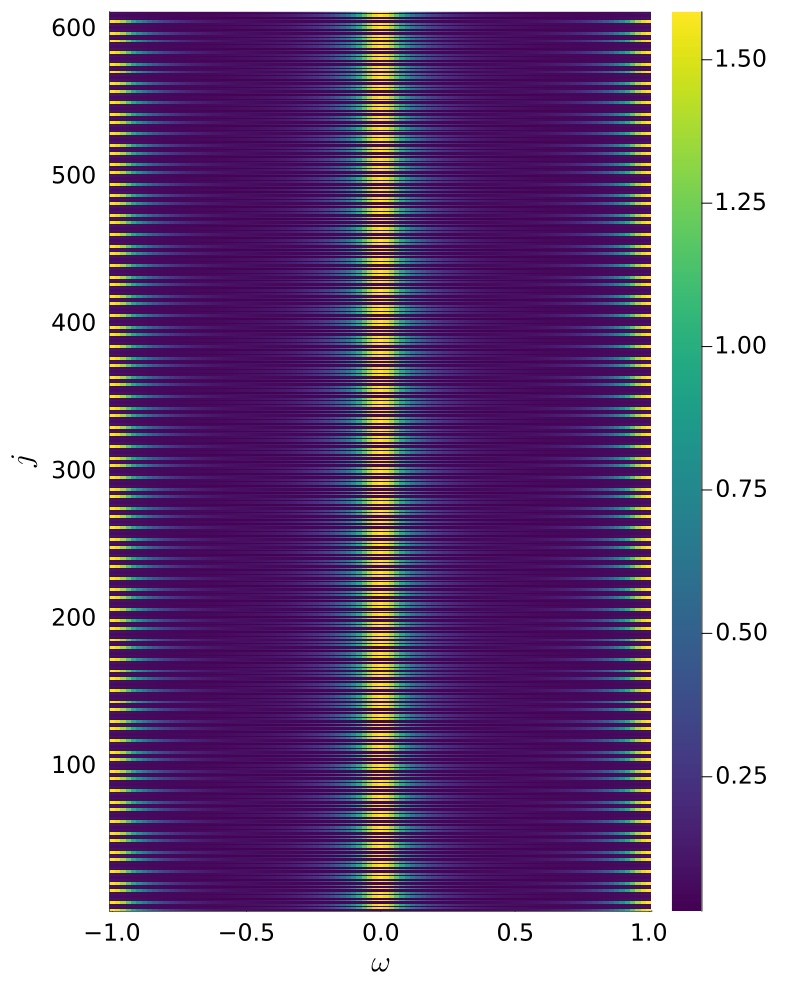

In [28]:
"""
Heatmap plotting functions for the spectral function
"""

function plot_spectral_function_site_index_heatmap(omega_range::Vector{Float64}, spectral_results::Dict{Float64, Matrix{Float64}}, mu_t_value::Float64)
    spectral_data = spectral_results[mu_t_value]
    site_indices = 1:size(spectral_data, 1)

    heatmap(omega_range, site_indices, spectral_data,
            xlabel="ω",
            ylabel="Site Index",
            title="Spectral Function A(ω) Heatmap for μ/t = $mu_t_value",
            color=:viridis,
            clims = (0, maximum(spectral_data)),
            colorbar=true
    )
end

function plot_spectral_function_site_index_heatmaps(omega_range::Vector{Float64}, spectral_results::Dict{Float64, Matrix{Float64}}, mu_t_values::Vector{Float64}, filename::String)

    n_plots = length(mu_t_values)
    
    # Set layout to match the number of mu_t_values
    n_cols = ceil(3)#Int, sqrt(n_plots))
    n_rows = ceil(Int, n_plots / n_cols)

    global_clim_min = 10.0
    global_clim_max = -10.0
    for mu_t_value in mu_t_values
        spectral_data = spectral_results[mu_t_value]
        log_spectral_data = log10.(spectral_data .+ 1e-10)
        global_clim_min = min(global_clim_min, minimum(log_spectral_data))
        global_clim_max = max(global_clim_max, maximum(log_spectral_data))
    end
    
    plot_list = []
    for mu_t_value in mu_t_values
        spectral_data = spectral_results[mu_t_value]
        site_indices = 1:size(spectral_data, 1)

        log_spectral_data = log10.(spectral_data .+ 1e-10) # Add a small offset to avoid log(0)

        clim_min = minimum(spectral_data)
        # cut_log_spectral_data = log_spectral_data[1:100]
        # println(length(cut_log_spectral_data))
        # clim_min = minimum(log_spectral_data)
        println(clim_min)
        # clim_max = maximum(log_spectral_data)
        clim_max = maximum(spectral_data)
        
        p = heatmap(omega_range, site_indices, spectral_data,
                    xlabel=L"\omega",
                    ylabel=L"j",
                    # title="μ/t = $mu_t_value",
                    color=:viridis,
                    # clims=(0.01*clim_min, 0.01*clim_max),
                    clims=(clim_min, clim_max),
                    colorbar=true,
                    colorbar_stretch = :vertical,
                    # yticks = 1:1:length(site_indices)
                    # ylims = (1,200)
                    labelfontsize = 20,
                    tickfontsize = 16,
                    left_margin=5mm,
                    # bottom_margin=5mm,
                )
        push!(plot_list, p)
    end
    
    plt = Plots.plot(
        plot_list..., 
        layout=(n_rows, n_cols), 
        size=(800,1000), #(1200, 1750), 
        colorbar=true, 
        right_margin=10Plots.mm
    )
        # colorbar_stretch = :vertical)#, title="Spectral Function Heatmaps")
    # cbar = PyPlot.colorbar!(plt, clims=(global_clim_min, global_clim_max), color=:viridis, right_margin=5Plots.mm)
    
    # Plots.savefig("/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/dimersation/GQC_rho0p25")
end

function plt_spectral_special_layout(omega_range::Vector{Float64}, spectral_results::Dict{Float64, Matrix{Float64}}, mu_t_values::Vector{Float64}, filename::String)

    n_plots = length(mu_t_values)
    
    # Set layout to match the number of mu_t_values
    n_cols = 4 #ceil(Int, sqrt(n_plots))
    n_rows = ceil(Int, n_plots / n_cols)

    global_clim_min = 10.0
    global_clim_max = -10.0
    for mu_t_value in mu_t_values
        spectral_data = spectral_results[mu_t_value]
        log_spectral_data = log10.(spectral_data .+ 1e-10)
        global_clim_min = min(global_clim_min, minimum(log_spectral_data))
        global_clim_max = max(global_clim_max, maximum(log_spectral_data))
    end
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5), 
                            gridspec_kw = Dict("width_ratios" => [1, 1, 1, 0.1])
                )
    axs = axs[:]
    
    for (i, mu_t_value) in enumerate(mu_t_values)#[1:end-1])
        spectral_data = spectral_results[mu_t_value]
        site_indices = 1:size(spectral_data, 1)
        log_spectral_data = log10.(spectral_data .+ 1e-10) # Add a small offset to avoid log(0)

        ax = axs[i]
        cax = ax.imshow(log_spectral_data, extent=[omega_range[1], omega_range[end], site_indices[1], site_indices[end]], 
                        aspect="auto", origin="lower", cmap="viridis", 
                        vmin=global_clim_min, vmax=global_clim_max)
        ax.set_xlabel(L"\omega")
        ax.set_ylabel("Site Index")
        # s1 = L"\mu/t_A = "
        # s2 = "$mu_t_value"
        s = "\$\\mu/t_A = $(mu_t_value)\$"
        ax.set_title(s)
    end

    # # Create the last subplot with the colorbar
    # last_ax = axs[end]  # Last subplot


    last_ax = axs[end]  # Last subplot
    last_ax.axis("off")
    # # Create a dummy plot on the last axis to get the color scale
    # dummy_data = rand(1, 1)  # Create dummy data just to generate the colorbar
    # cax = last_ax.imshow(dummy_data, extent=[omega_range[1], omega_range[end], 0, 1], 
    #                      aspect="auto", origin="lower", cmap="viridis", 
    #                      vmin=global_clim_min, vmax=global_clim_max)
    

    # Create a dummy plot on the last axis to get the color scale (set to NaN)
    dummy_data = NaN * ones(1, 1)  # Create dummy data with NaNs
    cmap = get_cmap("viridis")  # Use the viridis colormap
    cmap.set_bad("white")  # Set the color for NaN values to white
    
    cax = last_ax.imshow(dummy_data, extent=[omega_range[1], omega_range[end], 0, 1], 
                         aspect="auto", origin="lower", cmap=cmap, 
                         vmin=global_clim_min, vmax=global_clim_max)


    # last_mu_t_value = mu_t_values[end]
    # spectral_data = spectral_results[last_mu_t_value]
    # site_indices = 1:size(spectral_data, 1)
    # log_spectral_data = log10.(spectral_data .+ 1e-10) # Add a small offset to avoid log(0)
 
    # cax = last_ax.imshow(log_spectral_data, extent=[omega_range[1], omega_range[end], site_indices[1], site_indices[end]], 
    #                       aspect="auto", origin="lower", cmap="viridis", 
    #                       vmin=global_clim_min, vmax=global_clim_max)
    # last_ax.set_xlabel("ω")
    # last_ax.set_ylabel("Site Index")
    # last_ax.set_title("μ/t = $last_mu_t_value")


    fig.subplots_adjust(right=1.08)#0.85)
     
    # Add a single colorbar for the entire plot (linked to the last subplot)
    fig.colorbar(cax, ax=axs, orientation="vertical", label=L"\log_{10}(\mathbf{S})")#,fraction=0.01, pad=0.3)
     
    fig.tight_layout()
    
    # # Add a colorbar with the global color limits
    # cbar = fig.colorbar(cax, ax=axs, orientation="vertical")
    # cbar.set_label("Spectral Intensity (log scale)")
    
    # filename = "NC_spectrals_again.png"
    fig.savefig(filename, dpi=600)
    println("Saved plot as $filename")
end

# Example usage:
# plot_spectral_function_site_index_heatmaps(omega_range, spectral_results, mu_t_values)



# target_mu_t_value = 1.5
# plot_spectral_function_site_index_heatmap(omega_range, spectral_results, target_mu_t_value)
filename = "NC_spectral.png"
plot_spectral_function_site_index_heatmaps(energy_range_spectral, spectral_results, mu_values_spectral, filename)

# filename = "/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/TMQC_spectral_mu[0p5,2p8,3p5].png"
# plt_spectral_special_layout(energy_range_spectral, spectral_results, mu_values_spectral, filename)


In [29]:
using FFTW

function find_nonzero_spectral_sites(spectral_results::Dict{Float64, Matrix{Float64}}, omega_range::Vector{Float64}, mu_t_value::Float64, tolerance::Float64)
    spectral_data = spectral_results[mu_t_value]  # Get spectral data for the given μ/t
    site_indices = collect(1:size(spectral_data, 1))  # Site indices
    
    # Find the index in omega_range closest to ω = 0
    omega_zero_index = argmin(abs.(omega_range))
    
    # Extract spectral values at ω = 0 for each site
    spectral_values_at_zero = spectral_data[:, omega_zero_index]
    
    # # Apply thresholding to determine presence of spectral weight
    binary_spectral_sites = Int.(spectral_values_at_zero .> tolerance)
    # binary_spectral_sites = Int.(log10.(spectral_values_at_zero .+ 1e-10) .> tolerance)
    
    return site_indices, binary_spectral_sites, spectral_values_at_zero
end

function fibonacci_example_fft_process(iterations::Int)
    φ = (1 + sqrt(5)) / 2 

    c1 = [0]
    c2 = [1]

    clast = c2
    csecond_last = c1

    for _ in 1:iterations
        c = vcat(csecond_last, clast)  # Concatenate sequences
        csecond_last = clast
        clast = c
    end

    c = Float64.(c)  # Convert to float for FFT
    avg_c = mean(c)
    c_centered = c .- avg_c

    println("Length of chain: ", length(c))
    println("Average of c: ", avg_c)

    fft_result = real(fft(c_centered))

    # # Plot
    # plot_layout = (2, 1)
    # plt = Plots.plot(size=(1000, 500), layout=plot_layout, legend=false)

    # Plots.plot!(plt[1], fft_result, label="FFT (Real Part)", title="FFT of Sequence", lw=2)
    # Plots.plot!(plt[2], fft_result, label="FFT (Real Part) with Phi Markers", lw=2)

    # # # Add golden ratio markers
    # # total = 10
    # # for n in 1:(total-1)
    # #     marker_pos1 = ((n / φ) % 1) * length(c)
    # #     marker_pos2 = (1 - (n / φ) % 1) * length(c)
    # #     vline!(plt[2], [marker_pos1, marker_pos2], color=:red, lw=1, alpha=(n / total))
    # # end
    # total = 10
    # for n in 1:total
    #     marker_pos1 = ((n / φ) % 1) * length(c)
    #     marker_pos2 = (1 - (n / φ) % 1) * length(c)
    #     color_value = cmap(n / total)  # Update this to match your color mapping in Python
    #     vline!(plt[2], [marker_pos1, marker_pos2], color=color_value, lw=1)
    # end

    # display(plt)

    # Plot layout
    fig, axs = subplots(1, 1, figsize=(10, 4))
    plt2 = axs

    # # Plot FFT results
    # plt1.plot(fft_result, label="FFT (Real Part)", lw=2)
    # plt1.set_title("FFT of Sequence")
    f1=18
    plt2.plot(fft_result, label="FFT (Real Part) with Phi Markers", lw=2)
    # plt2.set_title("μ/t = $mu_t_value")
    plt2.set_xlabel(L"f", fontsize=f1)
    plt2.set_ylabel(L"|\text{FFT}|", fontsize=f1)

    # Add golden ratio markers
    total=10
    # cmap = plt.cm.viridis
    cmap = plt.cm.Reds
    for n in 1:total
        marker_pos1 = ((n / φ) % 1) * length(c)
        marker_pos2 = (1 - (n / φ) % 1) * length(c)
        color_value = cmap(n / total)  # Ensure cmap is defined, e.g., cmap = plt.cm.viridis
        plt2.axvline(marker_pos1, color=color_value, lw=1)
        plt2.axvline(marker_pos2, color=color_value, lw=1)
    end

    # Display plot
    tight_layout()
    # show()
    fig.savefig("/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/dimersation/raw_Fib_FFT.png", dpi=800)
end

function process_and_plot_spectral_signal(
    c::Vector{Float64}, 
    phi::Float64, 
    no_markers::Int, 
    mu_t_value::Float64, 
    rho_value::Float64, 
    filename::String
)
    c = Float64.(c)
    avg_c = mean(c)
    c_centered = c .- avg_c

    fft_result = real(fft(c_centered))
    n = length(c)
    freqs = fftshift(fftfreq(n))  # Get the frequencies and shift them
    shifted_fft_result = fftshift(fft_result)  # Shift FFT result to match frequency ordering

    fig, axs = subplots(1, 1, figsize=(10, 4)) # for 3 plots use (10, 8)
    # plt1, plt2, plt3 = axs
    plt2 = axs

    # # Plot FFT results
    # plt1.plot(fft_result, label="FFT (Real Part)", lw=2)
    # plt1.set_title("FFT of Sequence")
    fft_result[1] = NaN
    # fft_result = log10.(abs.(fft_result))

    f1=18

    plt2.plot(fft_result, label="FFT (Real Part) with Phi Markers", lw=2)
    plt2.set_title("ρ = $rho_value", fontsize=f1) #"FFT of Sequence, μ/t = $mu_t_value, ρ = $rho_value")
    plt2.set_xlabel(L"f", fontsize=f1)
    plt2.set_ylabel(L"\log_{10}|\text{FFT}|", fontsize=f1)
    plt2.set_ylabel(L"|\text{FFT}|", fontsize=f1)
    # plt2.set_ylim([-5.0, 3.0])

    # plt3.plot(freqs, shifted_fft_result, label="FFT frequencies", lw=2)
    # plt3.set_title("FFT Frequencies of Sequence")
    # # plt3.set_ylim([-60.0, 60.0])

    f_min, f_max = minimum(freqs), maximum(freqs)

    # Add golden ratio markers
    cmap = plt.cm.Reds

    markers_pos_1 = []
    markers_pos_2 = []
    
    total= no_markers

    for n in 1:total
        marker_pos1 = ((n / phi) % 1) * length(c)
        marker_pos2 = (1 - (n / phi) % 1) * length(c)
        # marker_pos1 = f_min + ((n / phi) % 1) * (f_max - f_min)
        # marker_pos2 = f_min + ((1 - (n / phi) % 1) * (f_max - f_min))
        push!(markers_pos_1, marker_pos1)
        push!(markers_pos_2, marker_pos2)
        color_value = cmap(1 - (n / total))
        plt2.axvline(marker_pos1, color=color_value, lw=1)
        plt2.axvline(marker_pos2, color=color_value, lw=1)
    end

    # Get the first marker position in the sequence
    marker_1_seq = (1 / phi) % 1 * length(c)

    # Get the dominant peak of the FFT
    fft_peaks = argmax(abs.(shifted_fft_result))  # Index of max FFT magnitude
    marker_1_freq = freqs[fft_peaks]  # Corresponding frequency

    # # Compute scaling factor to align sequence and FFT markers
    # scaling_factor = marker_1_freq / marker_1_seq
    # # println("scaling factor: $scaling_factor")

    # markers_freq_1 = []
    # markers_freq_2 = []

    # for n in 1:total
    #     marker_freq_1 = (f_min + ((n / phi) % 1) * (f_max - f_min)) #* scaling_factor
    #     marker_freq_2 = (f_min + (1 - (n / phi) % 1) * (f_max - f_min)) #* scaling_factor
    #     push!(markers_freq_1, marker_freq_1)
    #     push!(markers_freq_2, marker_freq_2)
    #     color_value = cmap(1 - (n / total))
    #     plt3.axvline(marker_freq_1, color=color_value, lw=1)
    #     plt3.axvline(marker_freq_2, color=color_value, lw=1)
    # end

    # Display plot
    tight_layout()
    # show()
    fig.savefig(filename, dpi=800)
    return markers_pos_1, markers_pos_2
end


mu_t_value = 0.01
tolerance = 1e-4
site_indices, binary_spectral_sites, cont_spectral_sites = find_nonzero_spectral_sites(spectral_results, energy_range_spectral, mu_t_value, tolerance)

println("Site indices: ", site_indices)
println("Binary spectral presence: ", binary_spectral_sites)

fibonacci_example_fft_process(13)

# phi_normal = 1.0
# phi_golden = (1 + sqrt(5)) / 2 #+ 0.01
# phi_silver = 1 + sqrt(2)
# phi_thue_morse = 0.5
# no_markers = 10
# phi_plastic = 1.324717957244746

# filename = "/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/dimersation/FFT_GQC_rho0_N610_NOLIM_markers.png"
# rho_value = t_list_spectral[2]
# m_1, m_2 = process_and_plot_spectral_signal(cont_spectral_sites, phi_golden, no_markers, mu_t_value, rho_value, filename)

# println("marker positions 1: $m_1")
# println("marker positions 2: $m_2")

Site indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [30]:
# """
# Doing FFt and markers for range of t2
# """

# t2_range = vcat(collect(range(0.0, 0.9, 10)), collect(range(0.91, 1.0, 10)))

# @showprogress for (i, t2) in enumerate(t2_range)
#     # # Hamiltonian parameters
#     N_spectral = 377
#     t_list_spectral = [1.0, t2]#, 1.0] #t_list
#     mu_values_spectral = [0.00001]
#     Delta_spectral = 0.0
#     sequence_spectral = golden_sequence

#     # # Spectral function parameters
#     energy_min_spectral = energy_min_spectral_global
#     energy_max_spectral = energy_max_spectral_global
#     energy_range_spectral = energy_range_spectral_global
#     eta_spectral = eta

#     # # Compute the spectral function over sites for each mu/t ratio
#     spectral_results = compute_spectral_function_for_mu_t_ratio_tn_generalised(
#         N_spectral, 
#         t_list_spectral, 
#         sequence_spectral, 
#         Delta_spectral, 
#         eta_spectral, 
#         energy_range_spectral, 
#         mu_values_spectral
#     )

#     tolerance = 1e-1
#     mu_value = mu_values_spectral[1]
#     site_indices, binary_spectral_sites = find_nonzero_spectral_sites(
#         spectral_results, 
#         energy_range_spectral, 
#         mu_value,
#         tolerance
#     )

#     phi_golden = (1 + sqrt(5)) / 2
#     filename = "Series_FFT_GQC_N377_rho$i.png"
#     m_1, m_2 = process_and_plot_spectral_signal(
#         binary_spectral_sites, 
#         phi_golden, 
#         no_markers, 
#         mu_value, 
#         t2, 
#         filename
#     )
# end



### Finding Optimal phi for FFT

For sequences qith an unknown PV number, this algorithm is designed to search through values of $1 \leq \phi \leq 2$ to find the vlue which best aligns with the FFT peaks.

In [31]:
using PyPlot
using FFTW

function compute_fft(c::Vector{Int})
    c = Float64.(c)
    avg_c = mean(c)
    c_centered = c .- avg_c
    fft_result = real(fft(c_centered))
    n = length(c)
    freqs = fftshift(fftfreq(n))  # Get the frequencies and shift them
    shifted_fft_result = fftshift(fft_result)  # Shift FFT result to match frequency ordering
    return fft_result, freqs, shifted_fft_result
end

function generate_marker_positions(phi::Float64, no_markers::Int, c_length::Int)
    markers_pos_1 = Float64[]
    markers_pos_2 = Float64[]
    for n in 1:no_markers
        marker_pos1 = ((n / phi) % 1) * c_length
        marker_pos2 = (1 - (n / phi) % 1) * c_length
        push!(markers_pos_1, marker_pos1)
        push!(markers_pos_2, marker_pos2)
    end
    return markers_pos_1, markers_pos_2
end

function quantify_alignment(markers_pos::Vector{Float64}, fft_peaks::Vector{Int})
    mse = 0.0
    for peak in fft_peaks
        closest_marker = minimum(abs.(markers_pos .- peak))
        mse += closest_marker^2
    end
    mse /= length(fft_peaks)
    return mse
end

function find_optimal_phi(c::Vector{Int}, phi_range::Vector{Float64}, no_markers::Int, filename::String)
    fft_result, freqs, shifted_fft_result = compute_fft(c)
    
    peak_indices = findall(x -> x > mean(fft_result), fft_result)
    fft_peaks = fft_result[peak_indices]

    weighted_peaks = []
    for (i, peak_index) in enumerate(peak_indices)
        weight = fft_peaks[i]
        wieght = weight^2
        push!(weighted_peaks, (peak_index, weight))
    end

    c_length = length(c)
    
    min_error = Inf
    best_phi = 0.0

    @showprogress for phi in phi_range
        markers_pos_1, markers_pos_2 = generate_marker_positions(phi, no_markers, c_length)
        
        # error = quantify_alignment(markers_pos_1, fft_peaks) ## for non-weighted peaks

        error = 0.0 ## for weighted peaks
        for (peak_index, weight) in weighted_peaks
            closest_marker_1 = minimum(abs.(markers_pos_1 .- peak_index))
            closest_marker_2 = minimum(abs.(markers_pos_2 .- peak_index))
            min_distance = min(closest_marker_1, closest_marker_2)
            error += weight * min_distance^1.5
        end
        error /= length(weighted_peaks)

        if error < min_error
            min_error = error
            best_phi = phi
        end
    end

    println("Optimal Phi: $best_phi with error: $min_error")

    markers_pos_1, markers_pos_2 = generate_marker_positions(best_phi, no_markers, c_length)
    
    fig, axs = subplots(3, 1, figsize=(10, 8))
    plt1, plt2, plt3 = axs

    # Plot FFT results
    plt1.plot(fft_result, label="FFT (Real Part)", lw=2)
    plt1.set_title("FFT of Sequence")

    plt2.plot(fft_result, label="FFT (Real Part) with Phi Markers", lw=2)
    plt2.set_title("FFT with Optimal Phi Markers")

    plt3.plot(freqs, shifted_fft_result, label="FFT frequencies", lw=2)
    plt3.set_title("FFT Frequencies of Sequence")

    cmap = plt.cm.Reds

    for (i, marker_pos1) in enumerate(markers_pos_1)
        marker_pos2 = markers_pos_2[i]
        color_value = cmap(1 - (i / no_markers))
        plt2.axvline(marker_pos1, color=color_value, lw=1)
        plt2.axvline(marker_pos2, color=color_value, lw=1)
    end

    # Save the figure
    tight_layout()
    fig.savefig(filename, dpi=300)
    return best_phi
end

# Example usage
c = binary_spectral_sites
no_markers = 10
phi_range = collect(range(1.0, 2.0, 5000)) #1.0:0.01:2.0
filename = "optimal_phi_plot.png"
best_phi = find_optimal_phi(c, phi_range, no_markers, filename)
println("Best Phi: $best_phi")

# phi_golden = (1 + sqrt(5)) / 2
# println("Golden Ratio: $phi_golden")


function optimise_markers(c::Vector{Int}, phi_range, marker_range::Vector{Int}, aim_phi::Float64)
    best_phis = Float64[]
    for marker in marker_range
        filename = "optimal_phi_markerno_$marker"
        best_phi = find_optimal_phi(c, phi_range, marker, filename)
        push!(best_phis, best_phi)
    end

    differences = abs.(best_phis .- aim_phi)
    min_difference_index = findfirst(x -> x == minimum(differences), differences)
    max_best_phi = best_phis[min_difference_index]
    best_marker = marker_range[min_difference_index]

    # max_best_phi = minimum(abs.(best_phis - aim_phi))
    # best_marker_index = findfirst(x -> x == max_best_phi, best_phis)
    # best_marker = marker_range[best_marker_index]

    return best_phis, max_best_phi, best_marker
end


# c = binary_spectral_sites
# phi_range = collect(range(1.0, 2.0, 5000))
# marker_range = floor.(Int, collect(range(10,100,10)))
# phi_golden = (1 + sqrt(5)) / 2
# best_phis, max_best_phi, best_marker = optimise_markers(c, phi_range, marker_range, phi_golden)

# println("Optimised phis for each number of markers: $best_phis")
# println("Maximum best phi: $max_best_phi")
# println("Optimum number of markers: $best_marker")

Optimal Phi: 0.0 with error: Inf
Best Phi: 0.0


optimise_markers (generic function with 1 method)

In [32]:
using PyPlot
using FFTW

function compute_fft(c::Vector{Int})
    c = Float64.(c)
    c_centered = c .- mean(c)
    fft_result = real(fft(c_centered))
    n = length(c)
    freqs = fftshift(fftfreq(n))
    shifted_fft_result = fftshift(fft_result)
    return fft_result, freqs, shifted_fft_result
end

function generate_marker_positions(phi::Float64, no_markers::Int, c_length::Int)
    markers_pos_1 = Float64[]
    markers_pos_2 = Float64[]
    for n in 1:no_markers
        marker_pos1 = ((n / phi) % 1) * c_length
        marker_pos2 = (1 - (n / phi) % 1) * c_length
        push!(markers_pos_1, marker_pos1)
        push!(markers_pos_2, marker_pos2)
    end
    return markers_pos_1, markers_pos_2
end

# function quantify_alignment(markers::Vector{Float64}, fft_peaks::Vector{Int})
#     mse = sum(minimum(abs.(markers .- peak))^2 for peak in fft_peaks) / length(fft_peaks)
#     return mse
# end

function quantify_alignment(markers_pos::Vector{Float64}, fft_peaks::Vector{Int})
    mse = 0.0
    for peak in fft_peaks
        closest_marker = minimum(abs.(markers_pos .- peak))
        mse += closest_marker^2
    end
    mse /= length(fft_peaks)
    return mse
end

function find_optimal_phi(c::Vector{Int}, no_markers::Int, filename::String)
    fft_result, freqs, shifted_fft_result = compute_fft(c)
    
    # Find largest peak
    largest_peak_index = argmax(abs.(fft_result))
    
    # find second largest peak
    temp_fft_result = copy(abs.(fft_result))
    temp_fft_result[largest_peak_index] = -Inf
    second_largest_peak_index = argmax(temp_fft_result)

    # Use second largest peak
    largest_peak_index = second_largest_peak_index

    c_length = length(c)
    estimated_phi = (c_length / largest_peak_index)
    
    m_1, m_2 = generate_marker_positions(estimated_phi, no_markers, c_length)
    peak_indices = findall(x -> x > mean(fft_result), fft_result)
    
    error = quantify_alignment(m_1, peak_indices)
    
    println("Estimated Phi: $estimated_phi with error: $error")
    
    fig, ax = subplots(figsize=(10, 5))
    ax.plot(fft_result, label="FFT (Real Part)", lw=2)
    cmap = plt.cm.Reds
    for (i, m_1_pos) in enumerate(m_1)
        m_2_pos = m_2[i]
        color_value = cmap(1 - (i / no_markers))
        ax.axvline(m_1_pos, color=color_value, lw=1)
        ax.axvline(m_2_pos, color=color_value, lw=1)
    end
    ax.set_title("FFT with Estimated Phi Markers")
    fig.savefig(filename, dpi=300)

    return estimated_phi
end


# Example usage
c = binary_spectral_sites
no_markers = 20
filename = "optimal_phi_plot_2_TMQC_N2048.png"
best_phi = find_optimal_phi(c, no_markers, filename)
println("Best Phi: $best_phi")









function find_largest_fft_peak(fft_result)
    peak_index = argmax(abs.(fft_result))
    return peak_index
end

function estimate_initial_phi(c::Vector{Int})
    fft_result, freqs, _ = compute_fft(c)
    peak_index = find_largest_fft_peak(fft_result)
    estimated_phi = length(c) / peak_index 
    # return clamp(estimated_phi, 1.0, 2.0)  # Ensure 1 < phi < 2
    return estimated_phi
end

function optimise_phi(c::Vector{Int}, no_markers::Int, step_size::Float64=0.001, max_iters::Int=1000, tol::Float64=1e-6)
    fft_result, freqs, shifted_fft_result = compute_fft(c)
    c_length = length(c)

    # Gradient-based optimization
    estimated_phi = estimate_initial_phi(c)
    println("estimated phi initial: $estimated_phi")
    
    peak_indices = findall(x -> x > mean(fft_result), fft_result)
    min_error = Inf

    for iter in 1:max_iters
        markers_pos_1, markers_pos_2 = generate_marker_positions(estimated_phi, no_markers, c_length)

        error = 0.0
        for peak_index in find_largest_fft_peak(fft_result)
            closest_marker_1 = minimum(abs.(markers_pos_1 .- peak_index))
            closest_marker_2 = minimum(abs.(markers_pos_2 .- peak_index))
            min_distance = min(closest_marker_1, closest_marker_2)
            error += min_distance^1.5
        end
        error /= no_markers

        # error = quantify_alignment(markers_pos_1, peak_indices)

        # Stopping condition
        if abs(error - min_error) < tol
            break
        end

        # Gradient estimation
        phi_step = estimated_phi + step_size
        markers_pos_1_step, markers_pos_2_step = generate_marker_positions(phi_step, no_markers, c_length)

        error_step = 0.0
        for peak_index in find_largest_fft_peak(fft_result)
            closest_marker_1_step = minimum(abs.(markers_pos_1_step .- peak_index))
            closest_marker_2_step = minimum(abs.(markers_pos_2_step .- peak_index))
            min_distance_step = min(closest_marker_1_step, closest_marker_2_step)
            error_step += min_distance_step^1.5
        end
        error_step /= no_markers

        gradient = (error_step - error) / step_size
        estimated_phi -= step_size * gradient  # Update phi in the direction of decreasing error

        # Ensure phi stays within bounds
        # phi = clamp(phi, 1.0, 2.0)

        # Reduce step size gradually
        step_size *= 0.99

        min_error = error
    end

    println("Optimised Phi: $estimated_phi with error: $min_error")

    return estimated_phi
end


# # Example usage
# c = binary_spectral_sites
# no_markers = 10
# filename = "optimal_phi_plot_3_TMQC.png"

# optimised_phi = optimise_phi(c, no_markers)
# println("Final Optimised Phi: $optimised_phi")
phi_golden = (1 + sqrt(5)) / 2
println("golden phi: $phi_golden")

Estimated Phi: 305.0 with error: NaN
Best Phi: 305.0
golden phi: 1.618033988749895


(log_k[1:10], log_S[1:10]) = ([0.0, 0.3010299956639812, 0.47712125471966244, 0.6020599913279624, 0.6989700043360189, 0.7781512503836436, 0.8450980400142568, 0.9030899869919435, 0.9542425094393249, 1.0], [-6.605097919221499, -5.723414274819681, -5.003763053376723, -5.458784207602329, -4.161072399551171, -4.90913849752624, -4.839634001313774, -3.342062972962225, -4.7410063844258525, -4.125747987055573])
Estimated Fractal Dimension (1D self-affine): 1.5564011923964625
Estimated Fractal Dimension (2D): 2.0564011923964625
Estimated Fractal Dimension (general Hurst exp): 1.5564011923964625


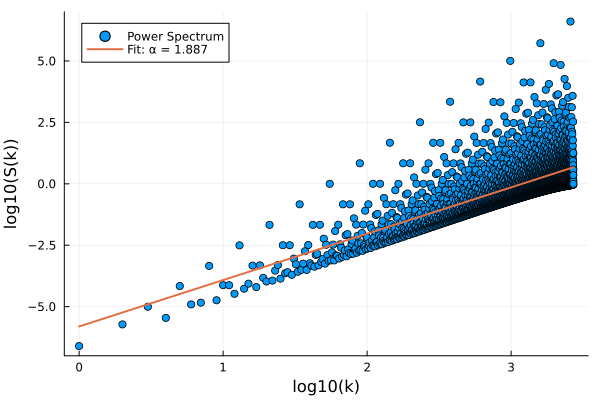

In [33]:
using FFTW, StatsBase, LinearAlgebra, Plots

function fractal_dimension_from_fft(c::Vector{Int})
    # c = map(x -> x == 2 ? 1 : 0, c)

    N = length(c)
    fft_values = fft(c)
    
    power_spectrum = abs.(fft_values).^2
    freqs = fftfreq(N) .* N
    
    # Keep only positive frequencies (ignoring zero freq)
    valid = freqs .> 0
    k_vals = freqs[valid]
    S_k = power_spectrum[valid]

    log_k = log10.(k_vals)
    log_S = log10.(S_k)

    @show log_k[1:10], log_S[1:10]

    exclude_fraction = 0.2
    n_exclude = round(Int, length(log_k) * exclude_fraction)
    if n_exclude > 0
        log_k = log_k[1:end-n_exclude]
        log_S = log_S[1:end-n_exclude]
    end

    # Fit a line to log-log plot: log(S) = -α log(k) + C
    A = [log_k ones(length(log_k))]  # Linear regression matrix
    coeffs = A \ log_S  # Least squares solution
    alpha = coeffs[1]  # Spectral exponent #### negate ??

    # Compute fractal dimension (D) for a 1D self-affine function
    D_1 = (5 - alpha) / 2
    D_2 = 3 - (alpha / 2)
    d = 1 # embedding dimension
    H = (alpha - 1)/2 # Hurst exponent
    D_3 = d + 1 - H

    # Plot power spectrum with fit
    plt = Plots.scatter(log_k, log_S, label="Power Spectrum", xlabel="log10(k)", ylabel="log10(S(k))")
    Plots.plot!(log_k, coeffs[1] .* log_k .+ coeffs[2], label="Fit: α = $(round(alpha, digits=3))", linewidth=2)

    display(plt)

    return D_1, D_2, D_3
end

# Example binary sequence
c =  golden_sequence #binary_spectral_sites
D_1, D_2, D_3 = fractal_dimension_from_fft(c)

println("Estimated Fractal Dimension (1D self-affine): ", D_1)
println("Estimated Fractal Dimension (2D): ", D_2)
println("Estimated Fractal Dimension (general Hurst exp): ", D_3)


In [34]:
function calc_golden_length(exp_range::Vector{Int})
    phi = (1 + sqrt(5) ) / 2
    phi_conj = (1 - sqrt(5) ) / 2
    sequence_lengths = Int[]

    for g in exp_range
        length = real((phi^(g+2) - phi_conj^(g+2)) / sqrt(5))
        length = floor.(Int, length)
        push!(sequence_lengths, length)
    end

    return sequence_lengths
end

function calc_silver_length(n_range::Vector{Int})
    lengths = Int[]
    for n in n_range
        if n == 0
            push!(lengths, 1)
        elseif n == 1
            push!(lengths, 3)
        else
            L_prev_2, L_prev_1 = 1, 3
            for _ in 2:n
                L_current = 2 * L_prev_1 + L_prev_2
                L_prev_2, L_prev_1 = L_prev_1, L_current
            end
            push!(lengths, L_prev_1)
        end
    end
    return lengths
end


g_range = floor.(Int, collect(range(1,12,12)))
golden_lengths = calc_golden_length(g_range)
silver_lengths = calc_silver_length(g_range)

lengths = silver_lengths
println(lengths)

dimensions = Float64[]
errors = Float64[]

golden_phi = (1 + sqrt(5) ) / 2
silver_phi = 1 + sqrt(2)
phi = silver_phi
println("aim phi: $phi")

# # For the true golden ratio sequence
# for length in lengths
#     c = golden_ratio_sequence_gen(length)
#     D_1, D_2, D_3 = fractal_dimension_from_fft(c)
#     push!(dimensions, D_1)

#     error = abs(phi - D_1)
#     push!(errors, error)
# end

# For the true silver ratio sequence
for length in lengths
    c = silver_ratio_sequence_gen(length)
    D_1, D_2, D_3 = fractal_dimension_from_fft(c)
    push!(dimensions, D_1)

    error = abs(phi - D_1)
    push!(errors, error)
end


# # # Spectral calc params
# t_list_spectral = [1.0, 0.0]#, 1.0] #t_list
# mu_values_spectral = [0.0]
# Delta_spectral = 0.0
# sequence_spectral = golden_sequence
# mu_t_value = 0.0
# tolerance = 1e-1

# energy_min_spectral = energy_min_spectral_global
# energy_max_spectral = energy_max_spectral_global
# energy_range_spectral = energy_range_spectral_global
# eta_spectral = eta

# # For the sequence obtained from the QC
# for length in lengths
#     spectral_results = compute_spectral_function_for_mu_t_ratio_tn_generalised(
#         length, 
#         t_list_spectral, 
#         sequence_spectral, 
#         Delta_spectral, 
#         eta_spectral, 
#         energy_range_spectral, 
#         mu_values_spectral
#     )

#     site_indices, binary_spectral_sites = find_nonzero_spectral_sites(
#         spectral_results, 
#         energy_range_spectral, 
#         mu_t_value, 
#         tolerance
#     )

#     c = binary_spectral_sites
#     D_1, D_2, D_3 = fractal_dimension_from_fft(c)
#     push!(dimensions, D_1)

#     error = abs(phi - D_1)
#     push!(errors, error)
# end


[3, 7, 17, 41, 99, 239, 577, 1393, 3363, 8119, 19601, 47321]
aim phi: 2.414213562373095
BAA


BoundsError: BoundsError: attempt to access 1-element Vector{Float64} at index [1:10]

In [35]:
# Save Results
BSON.@save "Pwr_spectrum_D_Calc_TrueS.bson" golden_lengths dimensions errors

In [36]:

function violin_plot(D::Vector{Float64}, error_D::Vector{Float64}, sequence_lengths::Vector{Int}, phi::Float64)
    
    # Filter out NaN values
    valid_indices = .!isnan.(D)
    D_filtered = D[valid_indices]
    error_D_filtered = error_D[valid_indices]
    sequence_lengths_filtered = sequence_lengths[valid_indices]

    # Track NaNs
    invalid_indicies = isnan.(D)
    filtered_out_seq_lengths = sequence_lengths[invalid_indicies]

    D = D_filtered
    error_D = error_D_filtered
    sequence_lengths = sequence_lengths_filtered

    sequence_length_labels = string.(sequence_lengths)

    plt = StatsPlots.violin(
        sequence_length_labels, 
        D, 
        errorbar = error_D,
        label = "Estimated fractal dimension",
        legend = true, 
        xlabel = "Sequence Lengths", 
        ylabel = "Fractal Dimension (D)", 
        title = "Error on Fractal Dimension for Various Sequence Lengths (True Silver)",
        size = (800,600)
    )

    # Plots.plot!(sequence_lengths, [phi], lc=:red, lt=:dash, lw=2, label="y = φ")
    hline!([phi], lc=:red, lw=1, label="y = φ_silver", ls=:dash)

    for (i, d) in enumerate(D)
        x_pos = sequence_length_labels[i]
        y_pos = d + (i % 2 == 0 ? 0.1 : -0.1)
        rounded_d = round(d, digits=2)
        annotate!(x_pos, y_pos, Plots.text(string(string(rounded_d)), :black, 8))
    end
    
    display(plt)

    return filtered_out_seq_lengths
end

unplotted_lengths = violin_plot(dimensions, errors, lengths, phi)
println("$(length(unplotted_lengths)) sequence lengths returned a NaN alpha value and were not plotted:")
for length in unplotted_lengths
    println(length)
end


BoundsError: BoundsError: attempt to access 12-element Vector{Int64} at index [0-element BitVector]

### Fractal Dimension of Phase Transition using Spectral Function

Colelction of points gathered from the zero modes of the spectral function. First, Box-counting dimension method is tried.

[2, 2, 3, 4, 5, 7, 9, 12, 16, 21, 28, 36, 47, 62, 81, 105, 137, 179, 234, 305]
fit parameters: [0.9807017544218507, 6.383431626705065]
Estimated Fractal Dimension: 0.9807017544218507


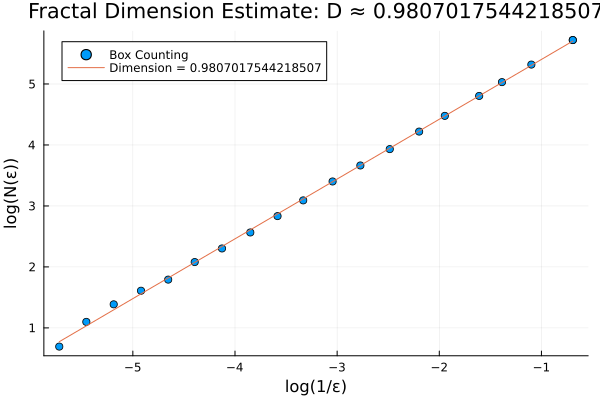

In [37]:
using LinearAlgebra, PyPlot

function linear_function(x::Vector{Float64}, p::Vector{Float64})
    return p[1] .+ (p[2] .* x)
end

function linear_fit(x_values::Vector{Float64}, y_values::Vector{Float64})
    # Design matrix with an intercept term
    A = hcat(ones(length(x_values)), x_values)

    # Perform the least-squares solution
    coeffs = A \ y_values

    # coeffs[1] is the intercept, coeffs[2] is the slope
    return coeffs
end

function D1_box_counting_fractal_dimension(c::Vector{Int}, eps_values::Vector{Int})
    # Extract positions of 1s (occupied sites)
    occupied_positions = findall(x -> x == 1, c)
    if isempty(occupied_positions)
        error("No occupied points found (all zeros in c)")
    end

    N_eps = Float64[]

    # # Incorrectly just looks at c directly
    # for eps in eps_values
    #     min_c, max_c = minimum(c), maximum(c)
    #     num_boxes = ceil(Int, (max_c - min_c) / eps)

    #     # Count occupied boxes
    #     box_indices = floor.(Int, (c .- min_c) ./ eps)
    #     unique_boxes = length(unique(box_indices))
    #     push!(N_eps, unique_boxes)
    # end

    # # Correctly looks at the positions of 1's in c
    # for eps in eps_values
    #     min_pos, max_pos = first(occupied_positions), last(occupied_positions)
    #     num_boxes = ceil(Int, (max_pos - min_pos) / eps)

    #     # Assign each occupied site to a box
    #     box_indices = floor.(Int, (occupied_positions .- min_pos) ./ eps)
    #     unique_boxes = length(unique(box_indices))

    #     push!(N_eps, unique_boxes)
    # end

    for eps in eps_values
        bins = collect(1:eps:length(occupied_positions))
        N = sum(any(occupied_positions .>= b .&& occupied_positions .< b+eps) for b in bins)
        push!(N_eps, N)
    end

    # Fit log(N(ε)) vs log(1/ε) to get fractal dimension D
    log_N = log.(N_eps)
    log_eps_inv = log.(1.0 ./ eps_values)
    A = hcat(log_eps_inv, ones(length(log_eps_inv)))
    fit_params = A \ log_N
    D = fit_params[1]

    # fit_params = linear_fit(log_eps_inv, log_N)
    println("fit parameters: ", fit_params)

    # # Fractal dimension (1 - slope)
    # m = fit_params[2]
    # D = m

    plt = Plots.scatter(
        log_eps_inv, log_N, 
        label="Box Counting",
        xlabel = "log(1/ε)",
        ylabel = "log(N(ε))",
        title = "Fractal Dimension Estimate: D ≈ $D",
    )

    # fit_x_values = collect(range(minimum(log_eps_inv), maximum(log_eps_inv), 100))
    # fitted_line = linear_function(fit_x_values, fit_params)

    fit_x_values = range(minimum(log_eps_inv), maximum(log_eps_inv), length=100)
    fitted_line = fit_params[1] .* fit_x_values .+ fit_params[2]
    
    Plots.plot!(
        plt, fit_x_values, fitted_line,
        label = "Dimension = $D"
    )

    display(plt)
    return D
end

function cumsum_D1_box_counting_fractal_dimension(c::Vector{Int}, eps_values::Vector{Int})
    # Compute the cumulative sum to get spatial positions
    spatial_positions = cumsum(c)

    # Find occupied positions where c = 1
    occupied_positions = findall(x -> x == 1, c)

    if isempty(occupied_positions)
        error("No occupied points found (all zeros in c)")
    end

    N_eps = Float64[]

    # Apply box-counting to the cumulative sum positions
    for eps in eps_values
        min_pos, max_pos = minimum(spatial_positions), maximum(spatial_positions)
        num_boxes = ceil(Int, (max_pos - min_pos) / eps)

        # Assign each occupied site to a box
        box_indices = floor.(Int, (spatial_positions[occupied_positions] .- min_pos) ./ eps)
        unique_boxes = length(unique(box_indices))

        push!(N_eps, unique_boxes)
    end

    # Fit log(N(ε)) vs log(1/ε) to estimate the fractal dimension
    log_N = log.(N_eps)
    log_eps_inv = log.(1.0 ./ eps_values)

    # Linear fit: log(N) = m * log(1/ε) + b
    A = hcat(log_eps_inv, ones(length(log_eps_inv)))  # Design matrix
    fit_params = A \ log_N  # Least squares fit

    # Extract slope (fractal dimension estimate)
    D = fit_params[1]

    # Plot results
    plt = Plots.scatter(
        log_eps_inv, log_N, 
        label="Box Counting",
        xlabel="log(1/ε)",
        ylabel="log(N(ε))",
        title="Fractal Dimension Estimate: D ≈ $D",
        markersize=5
    )

    # Plot fitted line
    fit_x_values = range(minimum(log_eps_inv), maximum(log_eps_inv), length=100)
    fitted_line = fit_params[1] .* fit_x_values .+ fit_params[2]
    
    Plots.plot!(
        plt, fit_x_values, fitted_line,
        label="Dimension = $D",
        linewidth=2
    )

    display(plt)
    return D
end


# Example usage
c = binary_spectral_sites #[rand() for _ in 1:1000]
eps_values = floor.(Int, exp10.(range(log10(2), stop=log10(length(binary_spectral_sites) ÷ 2), length=20))) #floor.(Int, collect(range(10.0, 200.0, 21))) #floor.(Int, collect(log_range(2.0, 3.0, 8.0, 12)))
println(eps_values)
# println(typeof(c))
# println(typeof(eps_values))

D = D1_box_counting_fractal_dimension(c, eps_values)
println("Estimated Fractal Dimension: ", D)


Using the complexity function to count subwords

6765


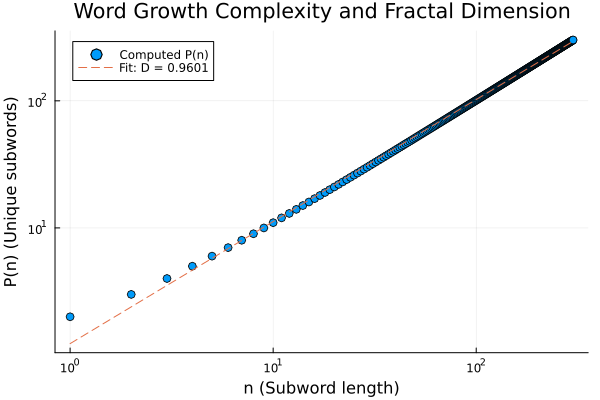

p_complexity_for_max_n_range (generic function with 1 method)

In [38]:
function discrete_count_unique_subwords(seq::Vector{Int}, n::Int)
    seen = Set{Vector{Int}}()
    for i in 1:(length(seq) - n + 1)
        push!(seen, seq[i:i+n-1])
    end
    return length(seen)
end

function discrete_compute_complexity(seq::Vector{Int}, max_n::Int)
    return [discrete_count_unique_subwords(seq, n) for n in 1:max_n]
end

function cont_count_unique_subwords(seq::Vector{Float64}, n::Int, tol::Float64)
    seen = Set{Vector{Float64}}()
    for i in 1:(length(seq) - n + 1)
        subword = seq[i:i+n-1]
        if !any(x -> all(abs.(subword .- x) .<= tol), seen)
            push!(seen, subword)
        end
    end
    return length(seen)
end

function cont_compute_complexity(seq::Vector{Float64}, max_n::Int, tol::Float64)
    return [cont_count_unique_subwords(seq, n, tol) for n in 1:max_n]
end

function power_law(n::Vector{Float64}, p::Vector{Float64})
    return p[2] .* n .^ p[1]
end

function power_law_fit(n_values::Vector{Int}, y_values::Vector{Int})
    # Transform the data to a linear form: log(y) = log(a) + b * log(n)
    log_n_values = log.(n_values)
    log_y_values = log.(y_values)

    # Design matrix with an intercept term
    A = hcat(ones(length(log_n_values)), log_n_values)

    # Perform the least-squares solution
    coeffs = A \ log_y_values

    # Transform back to the power law parameters
    b = coeffs[2]
    log_a = coeffs[1]
    a = exp(log_a)

    # coeffs[1] is the exponent, coeffs[2] is the coefficient
    return [b, a]
end


function estimate_fractal_dimension(P_values::Vector{Int})
    n_values = collect(1:length(P_values))
    fit_params = power_law_fit(n_values, P_values)
    # println("fit params: $fit_params")
    D = fit_params[1]
    return D, fit_params
end

function plot_complexity_results(max_n::Int, P_values::Vector{Int}, fit_params::Vector{Float64})
    plt = Plots.scatter(
        1:max_n, P_values, marker=:o, label="Computed P(n)",
        xscale=:log10, yscale=:log10, xlabel="n (Subword length)", ylabel="P(n) (Unique subwords)",
        title="Word Growth Complexity and Fractal Dimension"
    )

    fit_x_values = collect(range(1, max_n, 5*max_n))
    fit_line = power_law(fit_x_values, fit_params)

    Plots.plot!(
        fit_x_values, fit_line, 
        linestyle=:dash, 
        label="Fit: D = $(round(D_estimate, digits=4))"
    )

    display(plt)
end

# Parameters
# N = 1000  # Length of sequence
max_n = 300  # Maximum subword length to consider

function generate_random_sequence(length::Int)
    return [rand(Bool) ? 1.0 : 0.0 for _ in 1:length]
end
random_sequence = floor.(Int, generate_random_sequence(2000))


# Generate the sequence and compute P(n)
sequence = golden_sequence #binary_spectral_sites # cont_spectral_sites
println(length(sequence))
# println(typeof(cont_spectral_sites))
sub_word_tol = 1e-2
P_values = discrete_compute_complexity(sequence, max_n)#, sub_word_tol)

# Estimate fractal dimension
D_estimate, fit_params = estimate_fractal_dimension(P_values)
plot_complexity_results(max_n, P_values, fit_params)

# println("Estimated fractal dimension D ≈ ", round(D_estimate, digits=4))


function p_complexity_for_max_n_range(max_n_range::Vector{Int}, sequence::Vector{Int}, tol::Float64)

    D_values = Float64[]

    for max_n in max_n_range
        # P_values = cont_compute_complexity(sequence, max_n, tol)
        P_values = discrete_compute_complexity(sequence, max_n)
        D_estimate, fit_params = estimate_fractal_dimension(P_values)

        push!(D_values, D_estimate)
    end

    # println("D values: $D_values")

    # min_D = minimum(D_values)
    # min_index = argmin(D_values)
    # min_max_n = max_n_range[min_index]

    # println("minimum D: $min_D, max n counted for this dimension: $min_max_n")

    # Plots.scatter(
    #     max_n_range,
    #     D_values
    # )
    return D_values
end


# max_n_range = floor.(Int, collect(range(2,377,40)))
# sequence = binary_spectral_sites #cont_spectral_sites
# sub_word_tol = 5e-2
# D_values = p_complexity_for_max_n_range(max_n_range, sequence, sub_word_tol)

# min_D = minimum(D_values)
# min_index = argmin(D_values)
# min_max_n = max_n_range[min_index]

# println("minimum D: $min_D, max n counted for this dimension: $min_max_n")

# Plots.scatter(
#     max_n_range,
#     D_values,
#     xlabel = "max n (subword length)",
#     ylabel = "D",
#     legend = false
# )

In [39]:
# """
# Doing P(n) complexity calc for range of max_n's for range of t2
# """

# # t2_range = vcat(collect(range(0.0, 0.09, 10)), collect(range(0.1, 1.0, 10)))
# t2_range = collect(range(0.0, 1.0, 101))
# max_n_range = floor.(Int, collect(range(2,100,99)))

# D_values_values = []

# @showprogress for (i, t2) in enumerate(t2_range)
#     # # Hamiltonian parameters
#     N_spectral = 1597
#     t_list_spectral = [1.0, t2]#, 1.0] #t_list
#     mu_values_spectral = [0.00001]
#     Delta_spectral = 0.0
#     sequence_spectral = golden_sequence

#     # # Spectral function parameters
#     energy_min_spectral = energy_min_spectral_global
#     energy_max_spectral = energy_max_spectral_global
#     energy_range_spectral = energy_range_spectral_global
#     eta_spectral = eta

#     # # Compute the spectral function over sites for each mu/t ratio
#     spectral_results = compute_spectral_function_for_mu_t_ratio_tn_generalised(
#         N_spectral, 
#         t_list_spectral, 
#         sequence_spectral, 
#         Delta_spectral, 
#         eta_spectral, 
#         energy_range_spectral, 
#         mu_values_spectral
#     )

#     spectral_tol = 1e-1
#     mu_value = mu_values_spectral[1]
#     site_indices, binary_spectral_sites, cont_spectral_sites = find_nonzero_spectral_sites(
#         spectral_results, 
#         energy_range_spectral, 
#         mu_value,
#         spectral_tol
#     )

#     # println(typeof(binary_spectral_sites))

#     sub_word_tol = 5e-2
#     D_values = p_complexity_for_max_n_range(max_n_range, binary_spectral_sites, sub_word_tol) #cont_spectral_sites)
#     push!(D_values_values, D_values)

#     plt = Plots.scatter(
#         max_n_range,
#         D_values,
#         xlabel = "max n (subword length)",
#         ylabel = "D",
#         legend = false,
#         title = "rho = $t2",
#         ylims = (0.6, 2.0)
#     )

#     Plots.savefig("P_complexity_GQC_$i")
# end


# println(D_values_values[1])
# println(D_values_values[11])

Next, the Renyi Generalised Dimension for Spectral function points

In [40]:
using Random, Statistics, Plots, StatsBase, LinearAlgebra



# Compute the probability distribution p_i for a given resolution
function compute_probabilities(points, ε)
    min_x, max_x = minimum(points), maximum(points)
    bins = min_x:ε:max_x
    hist = fit(Histogram, points, bins)
    counts = hist.weights
    probs = counts / sum(counts)  # Normalize to get probability distribution
    return probs[probs .> 0]  # Remove zero probabilities
end

# Compute the Renyi Dimension D_q for a single resolution
function compute_D_q(points, q_values, eps_values)
    D_q_results = Dict(q => Float64[] for q in q_values)

    for q in q_values
        S_q_values = Float64[]

        for ε in eps_values
            probs = compute_probabilities(points, ε)

            if q == 1
                S_q = -sum(probs .* log.(probs))  # Shannon entropy (Information Dimension)
            else
                S_q = sum(probs .^ q) / (q - 1)  # Generalized q-dimension
            end

            push!(S_q_values, S_q)
        end

        # Fit log(S_q) vs log(ε) to get slope (scaling exponent)
        log_eps = log.(eps_values)
        log_S_q = log.(complex(S_q_values))

        # Perform linear regression to get slope
        A = hcat(ones(length(log_eps)), log_eps)  # Design matrix
        fit_params = A \ log_S_q  # Least squares fit
        slope = fit_params[2]  # Extract the slope

        push!(D_q_results[q], -slope)  # Correct sign
    end

    return D_q_results
end


# Extract indices where 1s are present (occupied sites)
occupied_sites = findall(x -> x == 1, binary_spectral_sites)

# Define q-values (Rényi parameters) and resolution sizes ε
q_values = [-1, 0, 1, 2]
eps_values = exp10.(range(-2, stop=0, length=10))  # Log-spaced resolutions

# Compute D_q for the binary data
D_q_results = compute_D_q(occupied_sites, q_values, eps_values)

# Plot results
plot()
for q in q_values
    plot!(eps_values, D_q_results[q], label="D_$(q)", lw=2, xscale=:log10, yscale=:log10)
end
xlabel!("Resolution ε")
ylabel!("D_q Scaling Exponent")
title!("Rényi Dimensions vs. Resolution for Binary Spectral Sites")
display(plot())


InexactError: InexactError: Float64(-0.0 - 2.0563858533783896e-16im)

In [41]:
using Random, Statistics, Plots, StatsBase, LinearAlgebra

# Function to generate synthetic fractal-like points at different resolutions
function generate_fractal_points(base_points::Int, levels::Int)
    points = []
    for level in 1:levels
        num_points = base_points * level  # Increasing resolution
        push!(points, sort(rand(num_points)))  # Random points with structure
    end
    return points
end

# Compute the probability distribution p_i for a given resolution
function compute_probabilities(points, ε)
    min_x, max_x = minimum(points), maximum(points)
    bins = min_x:ε:max_x
    hist = fit(Histogram, points, bins)
    counts = hist.weights
    probs = counts / sum(counts)  # Normalize to get probability distribution
    return probs[probs .> 0]  # Remove zero probabilities
end

# Compute the Renyi Dimension D_q for a set of resolutions
function compute_D_q(points_resolutions, q_values, eps_values)
    D_q_results = Dict(q => Float64[] for q in q_values)

    for q in q_values
        S_q_values = Float64[]

        for ε in eps_values
            S_q_sum = 0.0  # Accumulate over different resolutions

            for points in points_resolutions
                probs = compute_probabilities(points, ε)

                if q == 1
                    S_q = -sum(probs .* log.(probs))  # Shannon entropy (Information Dimension)
                else
                    S_q = sum(probs .^ q) / (q - 1)  # Generalized q-dimension
                end
                S_q_sum += S_q
            end
            push!(S_q_values, S_q_sum / length(points_resolutions))  # Average over resolutions
        end

        # Fit log(S_q) vs log(ε) to get slope (scaling exponent)
        log_eps = log.(eps_values)
        log_S_q = log.(S_q_values)

        # Perform linear regression to get slope
        A = hcat(ones(length(log_eps)), log_eps)  # Design matrix
        fit_params = A \ log_S_q  # Least squares fit
        slope = fit_params[2]  # Extract the slope

        push!(D_q_results[q], -slope)  # Correct sign
    end

    return D_q_results
end

# # Generate example data: 10 base points, increasing up to 100 points
# Random.seed!(42)
# points_resolutions = generate_fractal_points(10, 10)

# Define q-values (Rényi parameters) and resolution sizes ε
q_values = [0] #[-1, 0, 1, 2]
eps_values = exp10.(range(-2, stop=0, length=10))  # Log-spaced resolutions

# Compute D_q
D_q_results = compute_D_q(points_resolutions, q_values, eps_values)

# Plot results
plot()
for q in q_values
    plot!(eps_values, D_q_results[q], label="D_$(q)", lw=2, xscale=:log10, yscale=:log10)
end
xlabel!("Resolution ε")
ylabel!("D_q Scaling Exponent")
title!("Rényi Dimensions vs. Resolution")
display(plot())


UndefVarError: UndefVarError: `points_resolutions` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

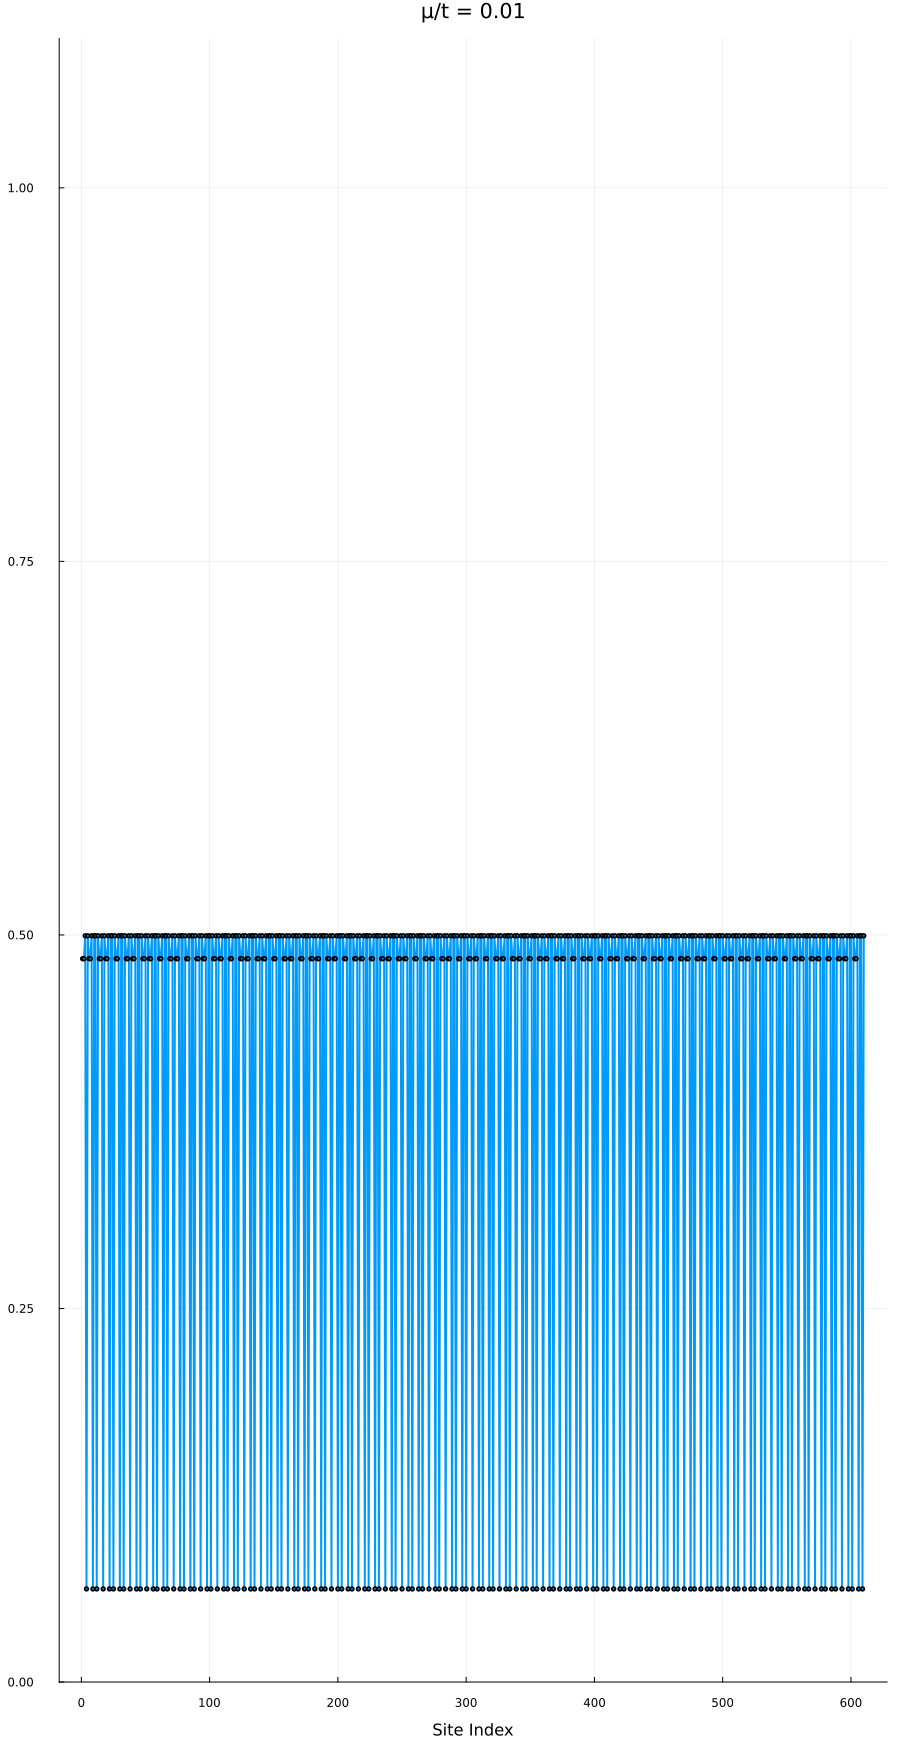

In [42]:
"""
Checking the normalisation of the spectral function:
    In theory the integral of the specral function wrt energy for each site should give the number of states.
"""

function trapz(x::Vector{Float64}, y::AbstractVector{Float64})
    """
    Performs trapezoidal integration on y with respect to x.

    Parameters:
    x -- Vector of x values (independent variable)
    y -- AbstractVector of y values (dependent variable)
    
    Returns:
    integral -- The numerical integral of y with respect to x.
    """
    n = length(x)
    integral = 0.0
    for i in 1:(n-1)
        integral += (x[i+1] - x[i]) * (y[i+1] + y[i]) / 2
    end
    return integral
end

function calculate_spectral_integral(spectral_results::Dict{Float64, Matrix{Float64}}, omega_range::Vector{Float64})
    """
    Calculates the integral of spectral results over the omega range for each site index using the trapezoidal rule.

    Parameters:
    spectral_results -- Dictionary with keys as mu/t values and values as matrices of spectral data.
    omega_range -- Vector of energy values (omega) over which to integrate.
    
    Returns:
    spectral_integrals -- Dictionary with the same keys as spectral_results and values as vectors of integrals for each site index.
    """
    spectral_integrals = Dict{Float64, Vector{Float64}}()

    for (mu_t_value, spectral_data) in spectral_results

        integrals = [trapz(omega_range, spectral_data[i, :]) for i in 1:size(spectral_data, 1)]
        spectral_integrals[mu_t_value] = integrals
    end

    return spectral_integrals
end

function plot_normalisation_against_site_index(spectral_sums::Dict{Float64, Vector{Float64}}, mu_t_values::Vector{Float64})
    """
    Creates subplots of the normalization against site index for each mu/t value.

    Parameters:
    spectral_sums -- Dictionary with keys as mu/t values and values as vectors of sums for each site index.
    mu_t_values -- Vector of mu/t values for which to create subplots.
    
    Returns:
    Nothing. Displays the subplots.
    """
    n_plots = length(mu_t_values)
    
    n_cols = ceil(Int, 2)#sqrt(n_plots))
    n_rows = ceil(Int, n_plots / n_cols)
    
    plot_list = []
    for mu_t_value in mu_t_values
        normalization = spectral_sums[mu_t_value]
        site_indices = 1:length(normalization)
        
        p = Plots.plot(
            site_indices, normalization,
            xlabel = "Site Index",
            ylabel = "Normalisation",
            title = "μ/t = $mu_t_value",
            lw = 2,
            marker = :circle,
            markersize = 2,
            grid = true,
            legend = false,
            ylims = (0.0, 1.1)
        )
        push!(plot_list, p)
    end
    
    Plots.plot(plot_list..., layout = (n_rows, n_cols), size = (900, 1750))

    # Plots.savefig("images_and_graphs/spectral_normalisation/NC_spectral_func_norm.png")
end


# Usage 
spectral_integrals = calculate_spectral_integral(spectral_results, energy_range_spectral)
# println("spectral sums: ", spectral_sums)
# println("spectral integral: ", spectral_integrals)

plot_normalisation_against_site_index(spectral_integrals, mu_values_spectral)

### Spectral Function Normalisation

Note, on the above normalisation plots the simple sum of the spectral function over energy range gives exactly the same shape of plot for all mu/t values than the integral over the energy range. The only difference is the sum gives normalisation $\approx 100$ for all sites, and the integral gives normalisation $\approx 2$ for all sites.

## Inverse Participation Ratio

The IPR is typically defined as 
$$\text{IPR} = \frac{\sum_{i} |\psi_{i}|^4}{\big( \sum_{i} |\psi_{i}|^2 \big)^2}$$

~~Where $i$ is the energy eigenstate index of the system, so summing over all energy eigenstates.~~

Where $i$ is actually the site index.

<!-- **N.B.**
There are 4 versions of the IPR calculation code in the function <inverse_participation_ratio> below. The first is mathematically incorrect, the second two are mathematically identical, but the second is more efficient for Julia script, the third is mathematically different again.

The first version calculates the following;
$$\text{IPR} = \sum_{i} \frac{ |\psi_{i}|^4}{\big( \sum_{i} |\psi_{i}|^2 \big)^2}$$
which incorrectly weights the elements fo the sum by the denomenator. This is not the IPR. This version gives constant IPR for $\mu/t$ and the following for IPR as a function of $N$; 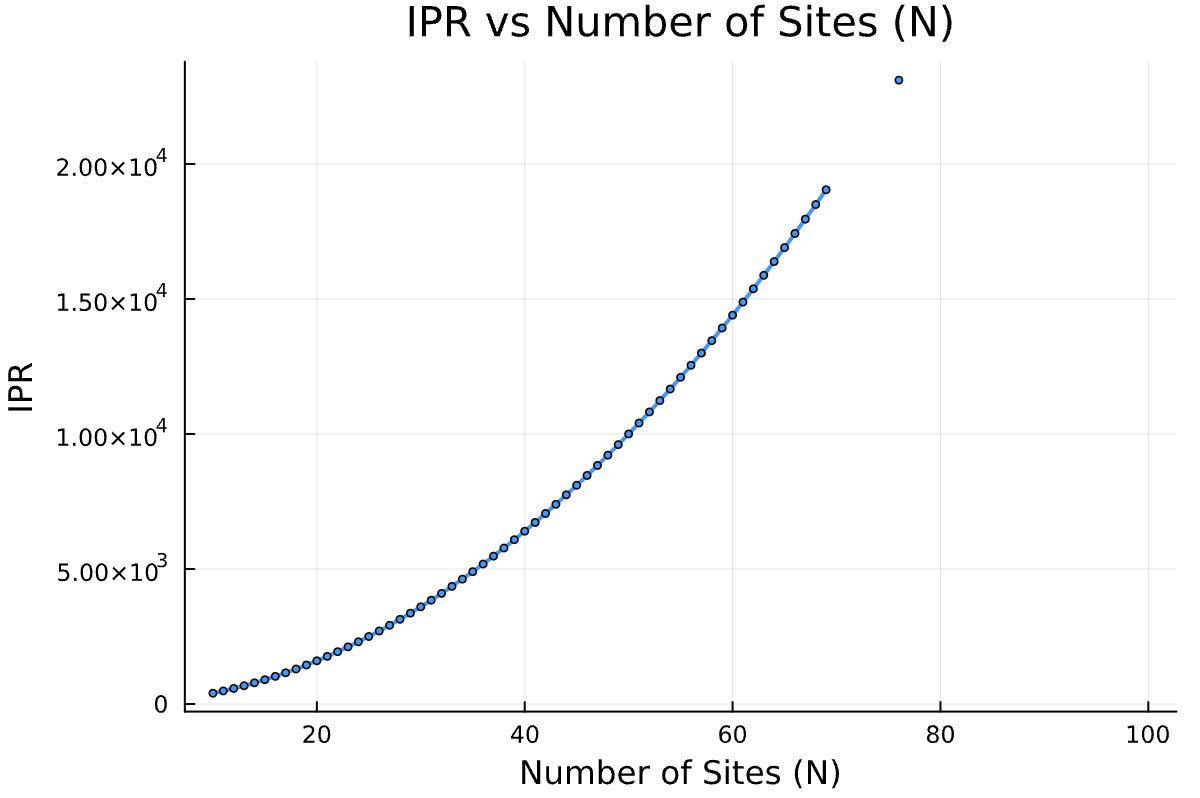


The second versions give the same output, there is a complex dependence of IPR on $\mu/t$ and a noisey linear dependence on $N$;
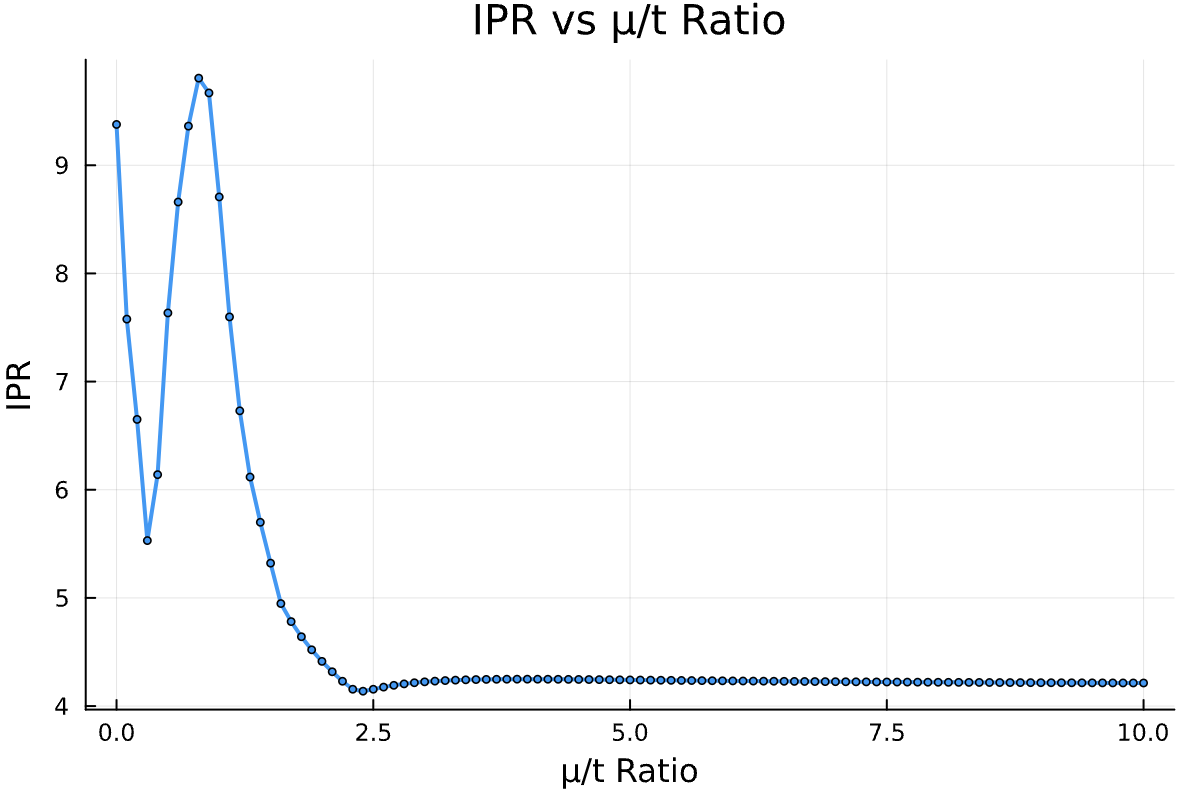
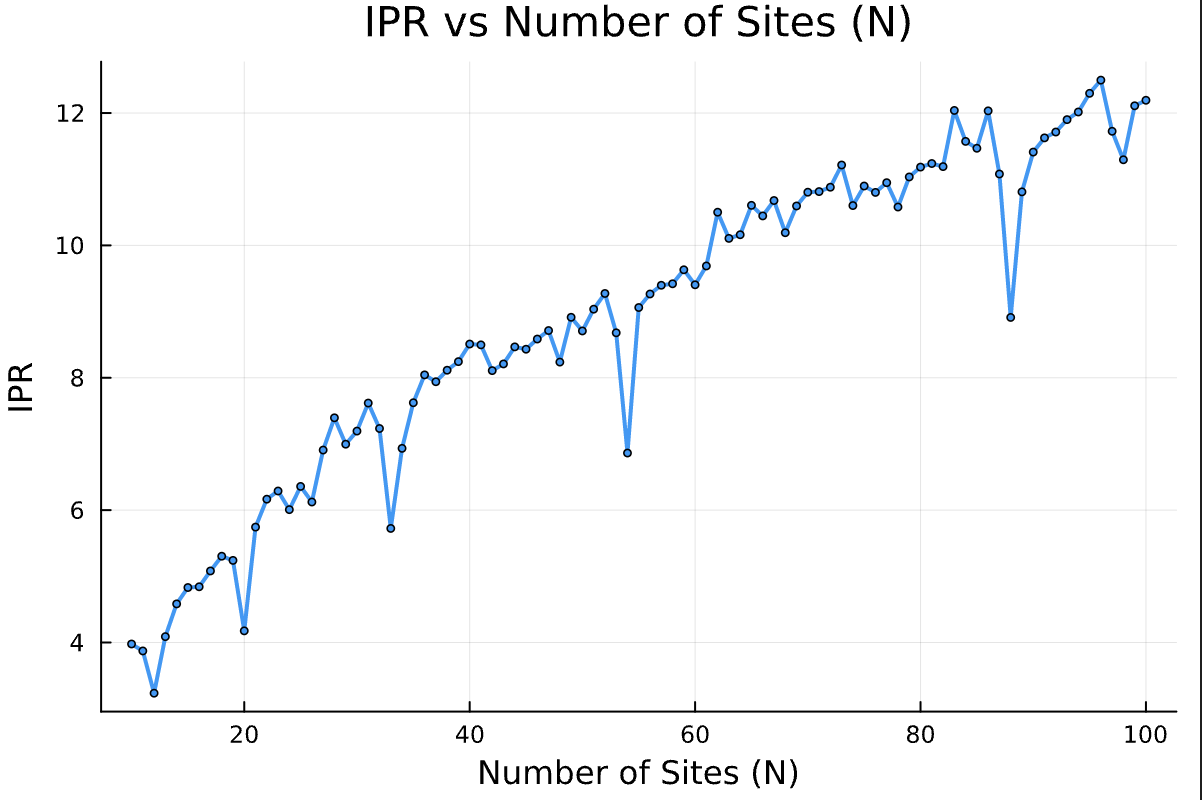


The Third version gives again constant IPR for $\mu/t$, but perfeclty linear IPR for $N$;
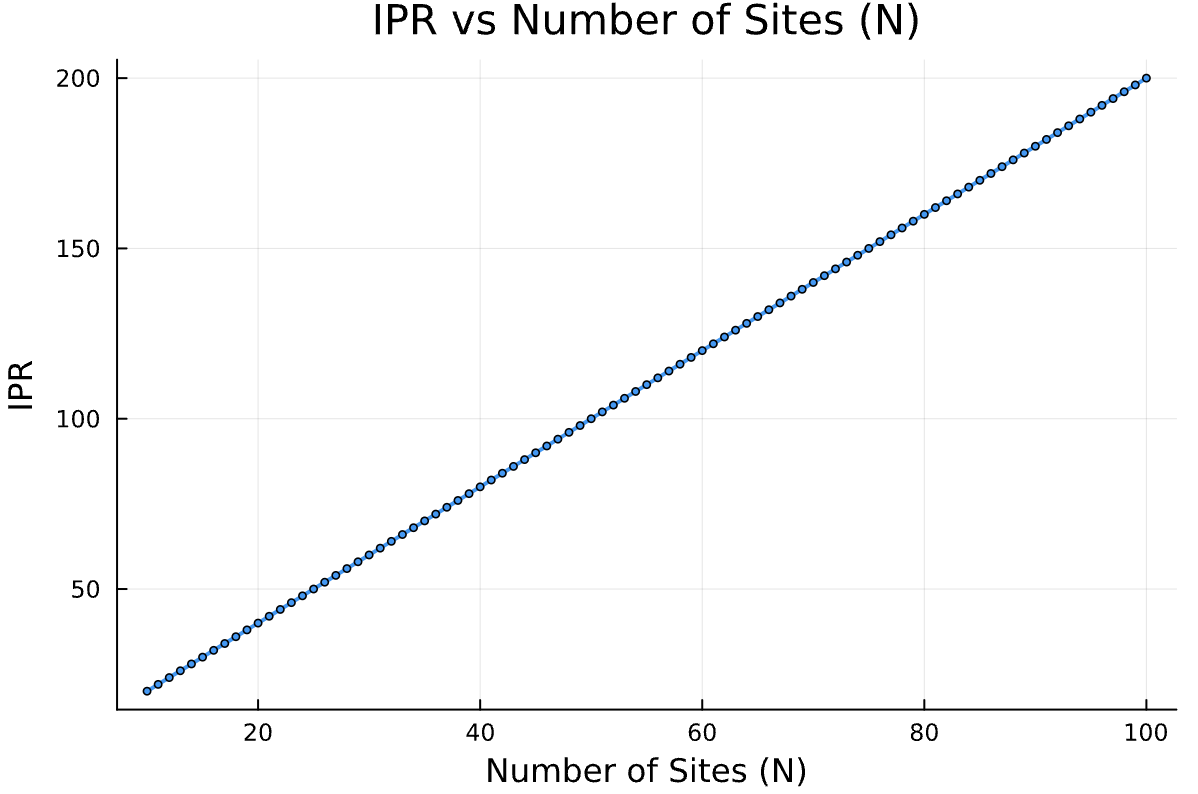

Note, these are all for Fibonacci QC with $\rho = 1.5$ -->


In [43]:
function inverse_participation_ratio(eigenvectors::Matrix{ComplexF64})
    """
    Computes the IPR for each eigenvector.

    Parameters:
    eigenvectors -- Matrix of eigenvectors (columns are eigenvectors).

    Returns:
    ipr_values -- Vector of IPR values, one for each eigenvector.
    """
    num_states = size(eigenvectors, 2)
    num_sites = div(size(eigenvectors, 1), 2)
    
    ipr_values = zeros(Float64, num_states)

    for i in 1:num_states
        psi = eigenvectors[:, i]

        # numerator = sum(abs.(psi).^4)
        # denominator = sum(abs.(psi).^2)^2

        site_probs = [abs(psi[j])^2 + abs(psi[num_sites + j])^2 for j in 1:num_sites]

        numerator = sum(site_probs .^ 2)
        denominator = sum(site_probs)^2

        ipr_values[i] = numerator / denominator
    end
    
    return ipr_values
end

function extract_middle_ipr_plus_n(ipr_values::Vector{Float64}, n::Int)
    middle_index = Int(floor(length(ipr_values) / 2))
    return ipr_values[middle_index + n]
end

function calculate_ipr_for_results_dict(results::Vector{Dict{String, Any}})
    """
    Computes the inverse participation ratio (IPR) for each row in the results dictionary.

    Parameters:
    results -- Vector of dictionaries, each containing eigenvectors and other parameters.

    Returns:
    updated_results -- A new vector of dictionaries with an additional key "ipr" containing
                       the IPR values for the eigenvectors.
    """
    updated_results = Vector{Dict{String, Any}}()

    for row in results
        eigenvectors = row["eigenvectors"]
        ipr_values = inverse_participation_ratio(eigenvectors)
        updated_row = deepcopy(row)
        updated_row["ipr"] = ipr_values
        push!(updated_results, updated_row)
    end

    return updated_results
end


# # Hamiltonian parameters
N_ipr_mu = 50
t_list_ipr_mu = [1.0, 1.5]
mu_values_ipr_mu = collect(range(0.0, 3.0, 501))
Delta_ipr_mu = 0.1
sequence_ipr_mu = golden_sequence

ipr_mu_pre_results = eigenvalue_finder_for_mu_tn_generalised(N_ipr_mu, t_list_ipr_mu, sequence_ipr_mu, mu_values_ipr_mu, Delta_ipr_mu)
# ipr_pre_results = results

ipr_mu_results = calculate_ipr_for_results_dict(ipr_mu_pre_results)


# # Optional: Print all IPR values to check
# for row in ipr_results
#     ipr_values = row["ipr"]
#     println("IPR values for mu/t_avg = ", row["mu_t_ratio"], ": ", ipr_values)
# end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


501-element Vector{Dict{String, Any}}:
 Dict("ipr" => [0.03068318534249386, 0.02984655861651552, 0.036510750693833346, 0.03606960289545383, 0.03712828758313986, 0.03653995754894661, 0.037091770877047084, 0.03847844616824613, 0.043534288930735326, 0.04398818661020073  …  0.04398818661020092, 0.043534288930737096, 0.03847844616824537, 0.037091770877046015, 0.03653995754894675, 0.03712828758314, 0.03606960289544924, 0.03651075069382731, 0.029846558616510463, 0.03068318534249028], "mu_t_ratio" => 0.0, "mu_values" => 0.0, "eigenvectors" => ComplexF64[-0.006533577397933942 + 0.0im -0.008726869392868897 + 0.0im … 0.008726869392772684 + 0.0im 0.006533577398056221 + 0.0im; -0.01740950327032653 + 0.0im -0.019022066747026133 + 0.0im … -0.019022066746771617 + 0.0im -0.017409503270592968 + 0.0im; … ; 0.017113818905927777 + 0.0im -0.019023336031416538 + 0.0im … 0.01902333603167119 + 0.0im -0.01711381890566245 + 0.0im; -0.009990727613560985 - 0.0im 0.012694475214865025 - 0.0im … 0.012694475215014612 

In [44]:
function eigenvalue_finder_for_N_tn_generalised(N_values::Vector{Int}, t_n::Vector{Float64}, mu::Float64, sequence::Vector{Int}, Delta::Float64=1.0)
    """
    Computes the eigenvalues for a range of N values, keeping other parameters fixed.

    Parameters:
    N_values    -- Vector of N values (number of sites in the chain).
    t_n         -- Vector of hopping terms.
    sequence    -- Vector of integers indicating the sequence of hopping terms.
    Delta       -- The value of the pairing constant (default is 1.0).

    Returns:
    results -- Vector of dictionaries containing the results for each N.
    """
    results = Vector{Dict{String, Any}}()

    for N in N_values
        H0 = create_normal_hamiltonian_quasi_tn_generalised(N, t_n, mu, sequence)
        pairing_matrix = create_pairing_matrix(N, Delta)
        BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)
        
        eigenvalues, eigenvectors = solve_bdg_hamiltonian(BdG)

        push!(results, Dict(
            "N" => N,
            "eigenvalues" => eigenvalues,
            "eigenvectors" => eigenvectors
        ))
    end

    return results
end

# # Hamiltonian parameters
N_values_ipr = collect(2:1:100)
mu_ipr_N = 0.01 #mu
t_list_ipr_N = [1.0, 1.0] #t_list
Delta_ipr_N = 0.1 #Delta
sequence_ipr_N = golden_sequence

ipr_N_pre_results = eigenvalue_finder_for_N_tn_generalised(N_values_ipr, t_list_ipr_N, mu_ipr_N, sequence_ipr_N, Delta_ipr_N)

ipr_N_results = calculate_ipr_for_results_dict(ipr_N_pre_results)


99-element Vector{Dict{String, Any}}:
 Dict("ipr" => [0.5000000000000001, 0.5, 0.5, 0.5000000000000001], "eigenvectors" => ComplexF64[-0.5242861144024804 + 0.0im 0.47447241252231953 + 0.0im 0.5242861144024791 + 0.0im -0.4744724125223199 + 0.0im; -0.5242861144024803 + 0.0im 0.4744724125223194 + 0.0im -0.5242861144024792 + 0.0im 0.4744724125223199 + 0.0im; -0.47447241252231864 + 0.0im -0.5242861144024796 + 0.0im -0.47447241252232014 + 0.0im -0.5242861144024793 + 0.0im; 0.47447241252231864 - 0.0im 0.5242861144024795 - 0.0im -0.4744724125223198 - 0.0im -0.5242861144024792 - 0.0im], "eigenvalues" => [-1.1004987562112079, -0.8995012437887904, 0.8995012437887916, 1.100498756211209], "N" => 2)
 Dict("ipr" => [0.37501694211654507, 0.3749820905687988, 0.4999980580828204, 0.4999980580828205, 0.3749820905687988, 0.37501694211654535], "eigenvectors" => ComplexF64[-0.4975696358903049 + 0.0im 0.050456534359162995 + 0.0im … 0.49746562644726117 + 0.0im -0.049066455397808045 + 0.0im; -0.7071307381166277

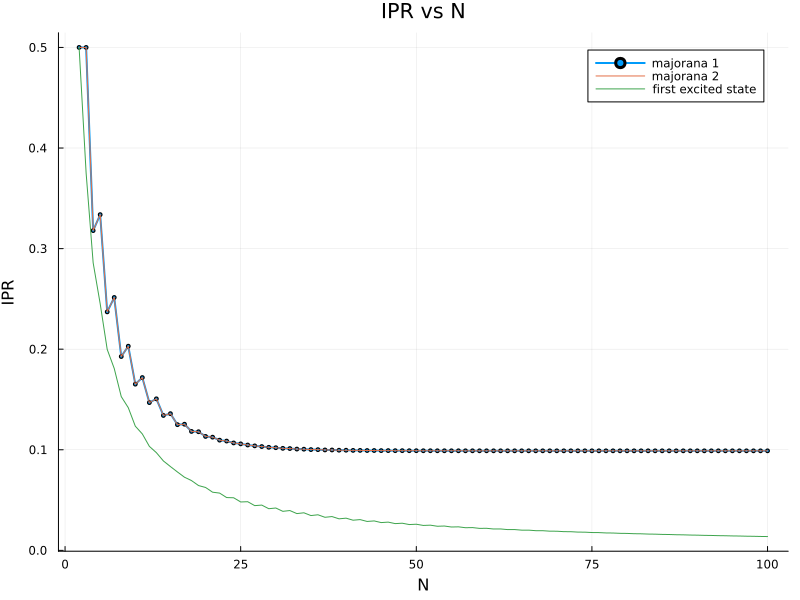

In [45]:
"""
Plot the above-calculated ipr results for varying mu/t or N
"""

function plot_ipr_vs_mu_t(results::Vector{Dict{String, Any}})
    """
    Plots the IPR values as a function of the mu/t ratio.

    Parameters:
    results -- Vector of dictionaries, each containing "ipr" and "mu_t_ratio".

    Returns:
    Nothing. Displays a plot.
    """

    mu_t_ratios = [row["mu_t_ratio"] for row in results]
    
    # Extract the middle IPR value for each row (assuming "ipr" contains a vector of IPR values)
    middle_ipr_values = [extract_middle_ipr_plus_n(row["ipr"], 0) for row in results]
    middle_plus_1_ipr_values = [extract_middle_ipr_plus_n(row["ipr"], 1) for row in results]
    middle_plus_2_ipr_values = [extract_middle_ipr_plus_n(row["ipr"], 2) for row in results]

    Plots.plot(
        mu_t_ratios, middle_ipr_values,
        label = "majorana 1",
        xlabel = "μ/t Ratio",
        ylabel = "IPR",
        title = "IPR vs μ/t Ratio",
        legend = true,
        lw = 2,
        marker = :circle,
        markersize = 2,
        grid = true,
        size = (800,600)
    )

    Plots.plot!(
        mu_t_ratios, middle_plus_1_ipr_values,
        label = "majorana 2"
    )

    Plots.plot!(
        mu_t_ratios, middle_plus_2_ipr_values,
        label = "1st excited state"
    )

    # Plots.savefig("images_and_graphs/ipr/NC_ipr_vs_mu2")
end

function plot_ipr_vs_N(results::Vector{Dict{String, Any}})
    """
    Plots the IPR values as a function of the mu/t ratio.

    Parameters:
    results -- Vector of dictionaries, each containing "ipr" and "mu_t_ratio".

    Returns:
    Nothing. Displays a plot.
    """

    N_values = [row["N"] for row in results]
    
    # Extract the middle IPR value for each row (assuming "ipr" contains a vector of IPR values)
    middle_ipr_values = [extract_middle_ipr_plus_n(row["ipr"], 0) for row in results]
    middle_plus_1_ipr_values = [extract_middle_ipr_plus_n(row["ipr"], 1) for row in results]
    middle_plus_2_ipr_values = [extract_middle_ipr_plus_n(row["ipr"], 2) for row in results]

    Plots.plot(
        N_values, middle_ipr_values,
        label = "majorana 1",
        xlabel = "N",
        ylabel = "IPR",
        title = "IPR vs N",
        legend = true,
        lw = 2,
        marker = :circle,
        markersize = 2,
        grid = true,
        size = (800,600)
    )

    Plots.plot!(
        N_values, middle_plus_1_ipr_values,
        label = "majorana 2"
    )

    Plots.plot!(
        N_values, middle_plus_2_ipr_values,
        label = "first excited state"
    )

    # Plots.savefig("images_and_graphs/ipr/NC_ipr_vs_N2")
end


# plot_ipr_vs_mu_t(ipr_mu_results)
plot_ipr_vs_N(ipr_N_results)

Vector{Float64}
fit parameters: [0.6417413128797604, 0.21688613868390788, 0.10009526035254523]


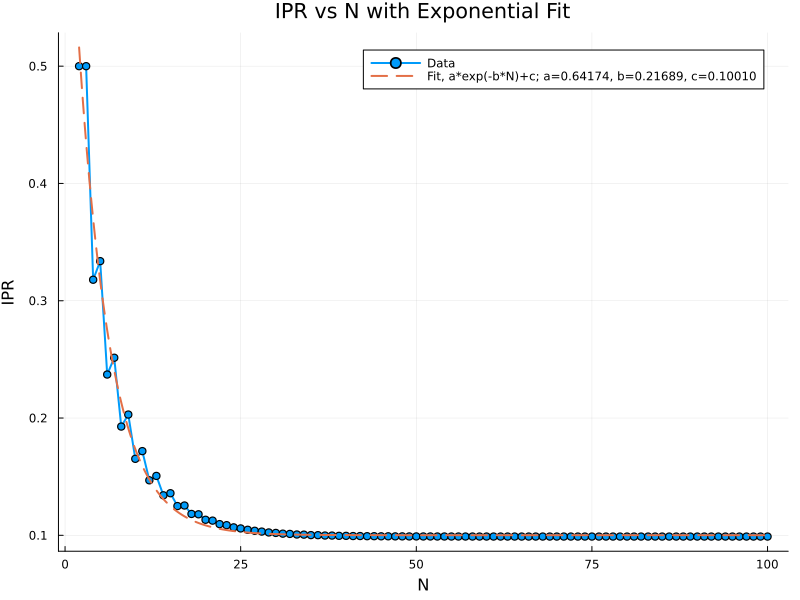

In [46]:
function exponential_decay(x::Vector{Float64}, p::Vector{Float64})
    return p[1] .* exp.(-p[2] .* x) .+ p[3]
end

function fit_exponential_decay(x_values::Vector{Int}, y_values::Vector{Float64})
    x_values_float = Float64.(x_values)
    model = exponential_decay
    p0 = [maximum(y_values), 0.1, minimum(y_values)]
    fit = LsqFit.curve_fit(model, x_values_float, y_values, p0)
    return fit
end

function plot_ipr_vs_N_with_fit(results::Vector{Dict{String, Any}}, max_N::Int)
    """
    Plots the IPR values as a function of N and includes an exponential fit up to max_N.

    Parameters:
    results -- Vector of dictionaries, each containing "ipr" and "N".
    max_N -- The maximum value of N for which the fit is calculated and plotted.

    Returns:
    Nothing. Displays a plot.
    """

    filtered_results = filter(row -> row["N"] <= max_N, results)

    N_values = [row["N"] for row in filtered_results]
    middle_ipr_values = [extract_middle_ipr_plus_n(row["ipr"], 0) for row in filtered_results]

    fit_x_values = collect(range(2,max_N,5*max_N))
    println(typeof(fit_x_values))

    fit = fit_exponential_decay(N_values, middle_ipr_values)
    fit_params = fit.param
    formatted_fit_params = map(x -> @sprintf("%.5f", x), fit_params)
    println("fit parameters: ", fit_params)
    
    fitted_curve = exponential_decay(fit_x_values, fit_params)

    plt = Plots.plot(N_values, middle_ipr_values,
        label = "Data",
        xlabel = "N",
        ylabel = "IPR",
        title = "IPR vs N with Exponential Fit",
        legend = true,
        lw = 2,
        marker = :circle,
        markersize = 4,
        grid = true,
        size = (800,600)
    )

    Plots.plot!(plt, fit_x_values, fitted_curve,
        label = "Fit, a*exp(-b*N)+c; a=$(formatted_fit_params[1]), b=$(formatted_fit_params[2]), c=$(formatted_fit_params[3])",
        lw = 2,
        linestyle = :dash
    )

    # display(gcf())

    # Plots.savefig("test_IPR_plot")
end

plot_ipr_vs_N_with_fit(ipr_N_results, 100)



Vector{Float64}
fit parameters: [0.6417413128797604, 0.21688613868390788, 0.10009526035254523]


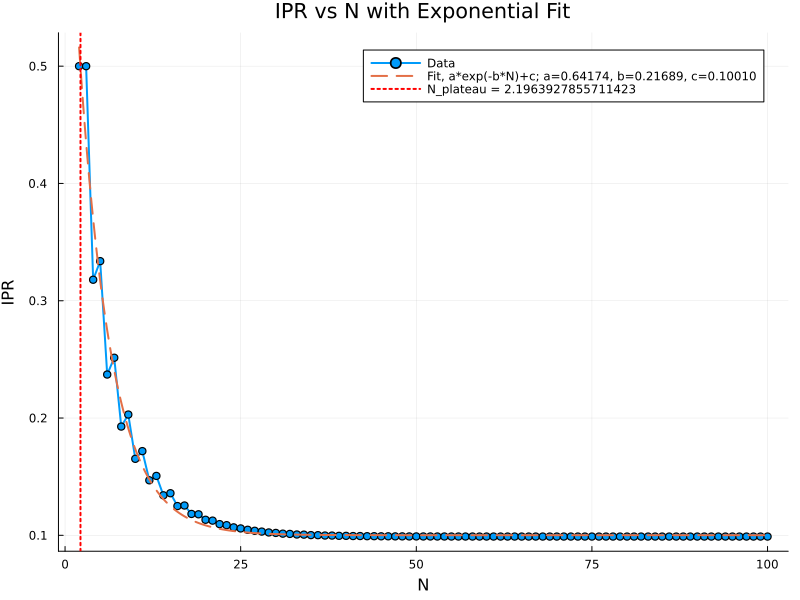

In [47]:
function plot_linearised_fit(results::Vector{Dict{String, Any}}, max_N::Int)
    """
    Plots the linearised data (ln(IPR - c)) alongside the original exponential fit data up to max_N.

    Parameters:
    results -- Vector of dictionaries, each containing "ipr" and "N".
    max_N -- The maximum value of N for which the fit is calculated and plotted.

    Returns:
    A plot object displaying the linearized data and the corresponding linear fit.
    """
    filtered_results = filter(row -> row["N"] <= max_N, results)

    N_values = [row["N"] for row in filtered_results]
    ipr_values = [extract_middle_ipr_plus_n(row["ipr"], 0) for row in filtered_results]

    fit = fit_exponential_decay(N_values, ipr_values)
    fit_params = fit.param

    a, b, c = fit_params
    N_values_float = Float64.(N_values)

    valid_indices = (ipr_values .- c) .> 0
    N_values_float = N_values_float[valid_indices]
    linearised_y_values = log.(ipr_values[valid_indices] .- c)

    fit_x_values = collect(range(2,max_N, 5*max_N))

    linear_fit_line = log(a) .- b .* fit_x_values

    inverse_b = 1/b

    formatted_loga_param = @sprintf("%.4f", log(a))
    formatted_b_param = @sprintf("%.4f", b)

    formatted_inverse_b_param = @sprintf("%.4f", inverse_b)

    p = Plots.plot(N_values_float, linearised_y_values,
        label = "Linearised Data",
        xlabel = "N",
        ylabel = "ln(IPR - c)",
        title = "Linearised IPR vs N",
        legend = true,
        lw = 2,
        marker = :circle,
        markersize = 4,
        grid = true,
        size = (800, 600)
    )

    Plots.plot!(p, fit_x_values, linear_fit_line,
        label = "Linear Fit, log(a)-b*N; log(a)=$formatted_loga_param, b=$formatted_inverse_b_param",
        lw = 2,
        linestyle = :dash
    )

    return p
end

# function plot_ipr_plateau(results::Vector{Dict{String, Any}}, max_N::Int)
#     """
#     Identifies and plots the plateau point (N_plateau) where the IPR saturates.

#     Parameters:
#     results -- Vector of dictionaries, each containing "ipr" and "N".
#     max_N -- The maximum value of N for which the fit is calculated and plotted.

#     Returns:
#     A plot object displaying the IPR data with the detected plateau point.
#     """
#     filtered_results = filter(row -> row["N"] <= max_N, results)

#     N_values = [row["N"] for row in filtered_results]
#     ipr_values = [extract_middle_ipr_plus_n(row["ipr"], 0) for row in filtered_results]

#     # Compute differences to detect plateau
#     Δ_IPR = abs.(diff(ipr_values)) ./ ipr_values[1:end-1]

#     # Threshold-based detection of N_plateau
#     threshold = 0.2  # Change tolerance for plateau detection
#     plateau_index = findfirst(x -> x < threshold, Δ_IPR)
#     N_plateau = plateau_index !== nothing ? N_values[plateau_index + 1] : NaN

#     # Plot data
#     p = Plots.plot(N_values, ipr_values,
#         label = "IPR Data",
#         xlabel = "N",
#         ylabel = "IPR",
#         title = "IPR vs N with Plateau Detection",
#         legend = true,
#         lw = 2,
#         marker = :circle,
#         markersize = 4,
#         grid = true,
#         size = (800, 600)
#     )

#     # Mark N_plateau
#     if !isnan(N_plateau)
#         Plots.vline!(p, [N_plateau],
#             label = "N_plateau = $N_plateau",
#             lw = 2,
#             linestyle = :dash,
#             color = :red
#         )
#     else
#         println("Warning: No clear plateau detected within the given range.")
#     end

#     return p
# end

function plot_ipr_vs_N_with_fit_N_plat(results::Vector{Dict{String, Any}}, max_N::Int)
    """
    Plots the IPR values as a function of N and includes an exponential fit up to max_N.
    Also calculates and marks N_plateau based on the fitted curve.

    Parameters:
    results -- Vector of dictionaries, each containing "ipr" and "N".
    max_N -- The maximum value of N for which the fit is calculated and plotted.

    Returns:
    Nothing. Displays a plot.
    """

    filtered_results = filter(row -> row["N"] <= max_N, results)

    N_values = [row["N"] for row in filtered_results]
    middle_ipr_values = [extract_middle_ipr_plus_n(row["ipr"], 0) for row in filtered_results]

    fit_x_values = collect(range(2, max_N, 5 * max_N))
    println(typeof(fit_x_values))

    fit = fit_exponential_decay(N_values, middle_ipr_values)
    fit_params = fit.param
    a, b, c = fit_params
    formatted_fit_params = map(x -> @sprintf("%.5f", x), fit_params)
    println("fit parameters: ", fit_params)

    fitted_curve = exponential_decay(fit_x_values, fit_params)

    # Identify N_plateau where exponential fit flattens (using threshold)
    threshold = 0.5  # Change tolerance for plateau detection
    Δ_fit = abs.(diff(fitted_curve)) ./ fitted_curve[1:end-1]
    plateau_index = findfirst(x -> x < threshold, Δ_fit)
    N_plateau = plateau_index !== nothing ? fit_x_values[plateau_index + 1] : NaN

    plt = Plots.plot(N_values, middle_ipr_values,
        label = "Data",
        xlabel = "N",
        ylabel = "IPR",
        title = "IPR vs N with Exponential Fit",
        legend = true,
        lw = 2,
        marker = :circle,
        markersize = 4,
        grid = true,
        size = (800, 600)
    )

    Plots.plot!(plt, fit_x_values, fitted_curve,
        label = "Fit, a*exp(-b*N)+c; a=$(formatted_fit_params[1]), b=$(formatted_fit_params[2]), c=$(formatted_fit_params[3])",
        lw = 2,
        linestyle = :dash
    )

    # Mark N_plateau
    if !isnan(N_plateau)
        Plots.vline!(plt, [N_plateau],
            label = "N_plateau = $N_plateau",
            lw = 2,
            linestyle = :dot,
            color = :red
        )
    else
        println("Warning: No clear plateau detected within the given range.")
    end

    return plt
end


# plot_linearised_fit(ipr_N_results, 50)

# plot_ipr_plateau(ipr_N_results, 100)
plot_ipr_vs_N_with_fit_N_plat(ipr_N_results, 100)


### High Precision IPR Calc

In [48]:
using GenericLinearAlgebra

function high_precision_create_bdg_hamiltonian(
    N::Int, 
    t_n::Vector{Float64}, 
    mu::Float64, 
    Delta::Float64,
    sequence::Vector{Int},
    precision::Int
)

    setprecision(BigFloat, precision)
    
    t_n = BigFloat.(t_n)
    mu = BigFloat(mu)
    Delta = BigFloat(Delta)
    
    H0 = zeros(Complex{BigFloat}, N, N)
    for i in 1:N-1
        H0[i, i] = -mu
        hopping_index = sequence[i]
        H0[i, i+1] = -t_n[hopping_index]
        H0[i+1, i] = -t_n[hopping_index]
    end
    H0[N, N] = -mu

    Delta_matrix = zeros(Complex{BigFloat}, N, N)
    for i in 1:N-1
        Delta_matrix[i, i+1] = Delta
        Delta_matrix[i+1, i] = -Delta
    end

    BdG = zeros(Complex{BigFloat}, 2N, 2N)
    BdG[1:N, 1:N] = H0
    BdG[N+1:end, N+1:end] = -conj(H0)
    BdG[1:N, N+1:end] = Delta_matrix
    BdG[N+1:end, 1:N] = Delta_matrix'

    return BdG
end

function high_precision_eigensolver(
    N_range::Vector{Int},
    t_n_range::Vector{Vector{Float64}},
    mu_range::Vector{Float64},
    Delta_range::Vector{Float64},
    sequence::Vector{Int},
    precision::Int
)
    # setprecision(BigFloat, precision)

    results = Dict()
    
    # for N in N_range
    #     truncated_sequence = Vector(sequence[1:N])

    #     for t_n in t_n_range
    #         for mu in mu_range
    #             for Delta in Delta_range

    #                 BdG = high_precision_create_bdg_hamiltonian(N, t_n, mu, Delta, truncated_sequence, precision)

    #                 eigenvalues, eigenvectors = GenericLinearAlgebra.eigen(Hermitian(BdG)) #big.BdG ??
                    
    #                 eigenvalues = BigFloat.(eigenvalues)
    #                 eigenvectors = BigFloat.(eigenvectors)

    #                 results[(N, t_n, mu, Delta)] = Dict(
    #                     "eigenvalues" => Vector(eigenvalues),
    #                     "eigenvectors" => Matrix(eigenvectors)
    #                 )
    #             end
    #         end
    #     end
    # end

    @showprogress Threads.@threads for (N, t_n, mu, Delta) in collect(Iterators.product(N_range, t_n_range, mu_range, Delta_range))
        truncated_sequence = Vector(sequence[1:N])
        BdG = high_precision_create_bdg_hamiltonian(N, t_n, mu, Delta, truncated_sequence, precision)
        eigenvalues, eigenvectors = GenericLinearAlgebra.eigen(Hermitian(BdG))
        results[(N, t_n, mu, Delta)] = Dict(
            "eigenvalues" => Vector(BigFloat.(eigenvalues)),
            "eigenvectors" => Matrix(BigFloat.(eigenvectors))
        )
    end
    return results
end

function high_precision_ipr_calc(
    eigenvectors::Matrix{BigFloat}
)
    num_states = size(eigenvectors, 2)
    num_sites = div(size(eigenvectors, 1), 2)
    
    ipr_values = zeros(Float64, num_states)
    nums = zeros(Float64, num_states)
    dens = zeros(Float64, num_states)

    for i in 1:num_states
        psi = eigenvectors[:, i]

        site_probs = [abs(psi[j])^2 + abs(psi[num_sites + j])^2 for j in 1:num_sites]

        numerator = sum(site_probs .^ 2)
        denominator = sum(site_probs)^2

        ipr_values[i] = numerator / denominator
        nums[i] = numerator
        dens[i] = denominator
    end
    
    return ipr_values, nums, dens
end

function extract_middle_ipr_plus_n(ipr_values::Vector{Float64}, n::Int)
    middle_index = Int(floor(length(ipr_values) / 2))
    return ipr_values[middle_index + n]
end

function high_precision_ipr_solver(
    results::Dict{Any, Any}
)
    for (key, row) in results
        eigenvectors = row["eigenvectors"]

        ipr_values, nums, dens = high_precision_ipr_calc(eigenvectors)
        
        row["nums"] = nums
        row["dens"] = dens
        row["ipr_values"] = ipr_values
    end

    return results
end


# General Use
# Parameter ranges
BigFloat_precision = 512

N_range = floor.(Int, collect(range(2,100,25))) # floor.(Int, vcat(collect(range(100, 50, 3)), collect(range(49, 24, 13)), collect(range(23, 2, 22)))) #floor.(Int, log_range(1.1, 1.0, 20.0, 20))
println(N_range)

t1_range = collect(range(1.0, 1.0, 1))
t2_range = collect(range(2.0, 2.0, 1))
t_ranges = [t1_range, t2_range]
t_combinations = t_ranges_combinations(t_ranges)
# println(length(t_combinations))

mu_range = [0.5, 2.3, 3.0] #collect(range(0.0, 3.0, length=11))

Delta_range = [1.0] #log_range(10.0, 0.0, 0.0, 1)

sequence = silver_sequence


# results = high_precision_eigensolver(N_range, t_combinations, mu_range, Delta_range, sequence, BigFloat_precision)
# hp_ipr_results = high_precision_ipr_solver(results)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 100]


8119-element Vector{Int64}:
 1
 2
 1
 1
 2
 1
 1
 2
 1
 1
 ⋮
 1
 1
 1
 2
 1
 1
 2
 1
 1

In [49]:
function high_precision_ipr_plot(
    results::Dict{Any, Any}
)
    N_values = []
    nums = []
    dens = []
    ipr_values = []

    for (key, row) in results
        N = key[1] # Accessing the first element of the tuple key for n
        push!(N_values, N)
        push!(nums, row["nums"])
        push!(dens, row["dens"])
        push!(ipr_values, row["ipr_values"])
    end

    println(N_values)

    sorted_indicies = sortperm(N_values)
    sorted_N_values = N_values[sorted_indicies]
    sorted_nums = [nums[i] for i in sorted_indicies]
    sort_dens = [dens[i] for i in sorted_indicies]
    sorted_ipr_values = [ipr_values[i] for i in sorted_indicies]

    println(sorted_N_values)

    # mid_index = div(length(ipr_values[1]), 2)
    # mpo_index = mid_index + 1

    # mid_ipr_values = [sorted_ipr_values[i][mid_index] for i in 1:length(sorted_N_values)]
    # mpo_ipr_values = [sorted_ipr_values[i][mpo_index] for i in 1:length(sorted_N_values)]
    mid_ipr_values = []
    mpo_ipr_values = []

    for i in 1:length(sorted_N_values)
        ipr_list = sorted_ipr_values[i]
        mid_index = div(length(ipr_list), 2)  # Middle index
        mpo_index = min(mid_index + 1, length(ipr_list))  # Ensure within bounds
        
        push!(mid_ipr_values, ipr_list[mid_index])
        push!(mpo_ipr_values, ipr_list[mpo_index])
    end

    plt = Plots.plot(
        sorted_N_values, mid_ipr_values,
        title = "High Precision IPR Values",
        label = "IPR (middle)",
        xlabel = "N",
        ylabel = "IPR",
        lw = 2,
        grid = true,
        size = (800,600)
    )

    Plots.plot!(
        sorted_N_values, mpo_ipr_values,
        label = "IPR (middle + 1)",
        lw = 2
    )

    display(plt)
end

function hp_ipr_plot_multi_mu(
    results::Dict{Any, Any}
)
    # Group data by unique mu values
    mu_groups = Dict{Float64, Vector{Tuple{Int64, Vector{Float64}, Vector{Float64}, Vector{Float64}}}}()

    for (key, row) in results
        N = key[1]
        mu = key[3]
        ipr_values = row["ipr_values"]
        nums = row["nums"]
        dens = row["dens"]

        # Ensure that IPR values are treated as Float64 vectors
        ipr_values = Vector{Float64}(ipr_values)
        nums = Vector{Float64}(nums)
        dens = Vector{Float64}(dens)

        if !haskey(mu_groups, mu)
            mu_groups[mu] = Vector{Tuple{Int64, Vector{Float64}, Vector{Float64}, Vector{Float64}}}()
        end
        push!(mu_groups[mu], (N, ipr_values, nums, dens))
    end

    # Create the plot
    plt = Plots.plot(
        title = "High Precision IPR Values vs N for Different μ",
        xlabel = "N",
        ylabel = "IPR",
        lw = 2,
        grid = true,
        size = (800, 600)
    )

    # Plot each mu group
    for (mu, entries) in mu_groups
        sorted_entries = sort(entries, by = x -> x[1])
        sorted_N_values = [entry[1] for entry in sorted_entries]
        sorted_ipr_values = [entry[2] for entry in sorted_entries]

        mid_ipr_values = []
        mpo_ipr_values = []
        mpt_ipr_values = []

        for ipr_list in sorted_ipr_values
            mid_index = div(length(ipr_list), 2)
            mpo_index = min(mid_index + 1, length(ipr_list))

            mpt_index = mid_index + 2

            push!(mid_ipr_values, ipr_list[mid_index])
            push!(mpo_ipr_values, ipr_list[mpo_index])
            push!(mpt_ipr_values, ipr_list[mpt_index])
        end

        # Plot for each mu value
        Plots.plot!(
            sorted_N_values, mid_ipr_values,
            label = "μ = $(round(mu, digits = 3))",
            lw = 2
        )

        # Plots.plot!(
        #     sorted_N_values, mpt_ipr_values,
        #     label = "μ = $(round(mu, digits = 3)) (delocalised)",
        #     lw = 2,
        #     linestyle = :dash
        # )
    end

    # display(plt)
    Plots.savefig("test_ipr")
end

####################################

function exponential_decay(x::Vector{Float64}, p::Vector{Float64})
    return p[1] .* exp.(-p[2] .* x) .+ p[3]
end

function one_over_N(x::Vector{Float64}, p::Vector{Float64})
    return p[1] ./ (x .+ p[2]) .+ p[3]
end

function fit_curve(x_values::Vector{Int}, y_values::Vector{Float64}, fit_type::String)
    x_values_float = Float64.(x_values)
    if fit_type == "exp"
        model = exponential_decay
        p0 = [maximum(y_values), 0.1, minimum(y_values)]
    elseif fit_type == "1/N"
        model = one_over_N
        p0 = [maximum(y_values), 1.0, minimum(y_values)]
    else
        return nothing
    end

    fit = LsqFit.curve_fit(model, x_values_float, y_values, p0)
    return fit, model
end


###
## Below function is identically functional but using Plots, which does not support dpi
###
# function hp_ipr_plot_multi_mu_fit(
#     results::Dict{Any, Any},
#     fit_types::Dict{Float64, String},
#     filename::String
# )
#     mu_groups = Dict{Float64, Vector{Tuple{Int64, Vector{Float64}, Vector{Float64}, Vector{Float64}}}}()

#     for (key, row) in results
#         N = key[1]
#         mu = key[3]
#         ipr_values = Vector{Float64}(row["ipr_values"])
#         nums = Vector{Float64}(row["nums"])
#         dens = Vector{Float64}(row["dens"])

#         if !haskey(mu_groups, mu)
#             mu_groups[mu] = Vector{Tuple{Int64, Vector{Float64}, Vector{Float64}, Vector{Float64}}}()
#         end
#         push!(mu_groups[mu], (N, ipr_values, nums, dens))
#     end

#     plt = Plots.plot(
#         title = "High Precision IPR Values vs N for Different μ",
#         xlabel = "N",
#         ylabel = "IPR",
#         lw = 2,
#         grid = true,
#         legend=:right,
#         size = (800, 600)
#     )

#     for (mu, entries) in sort(collect(mu_groups), by = x -> x[1])
#         sorted_entries = sort(entries, by = x -> x[1])
#         sorted_N_values = [entry[1] for entry in sorted_entries]
#         sorted_ipr_values = [entry[2] for entry in sorted_entries]

#         mid_ipr_values = [ipr_list[div(length(ipr_list), 2)] for ipr_list in sorted_ipr_values]

#         Plots.scatter!(
#             sorted_N_values, mid_ipr_values,
#             label = "μ = $(round(mu, digits = 3)) (middle)",
#             lw = 2
#         )

#         # Apply fit if specified
#         fit_type = get(fit_types, mu, "none")
#         if fit_type != "none"
#             fit_result, model = fit_curve(sorted_N_values, mid_ipr_values, fit_type)
#             if fit_result !== nothing
#                 fit_params = fit_result.param

#                 # Generate higher-density x-values for a smooth fit curve
#                 min_N, max_N = minimum(sorted_N_values), maximum(sorted_N_values)
#                 fit_x_values = collect(range(min_N, max_N, length=5 * length(sorted_N_values)))

#                 fitted_curve = model(fit_x_values, fit_params)
#                 formatted_params = map(x -> @sprintf("%.5f", x), fit_params)
#                 Plots.plot!(
#                     fit_x_values, fitted_curve,
#                     label = "Fit ($(fit_type)): $(join(formatted_params, ", "))",
#                     lw = 2,
#                     # linestyle = :dash
#                 )
#             end
#         end
#     end

#     # display(plt)
#     # Plots.savefig(filename)
#     Plots.savefig(plt, filename; dpi=300)
# end

###
## Below function is identically functional to the above but using PyPlots, which supports dpi
###
function hp_ipr_plot_multi_mu_fit(
    results::Dict{Any, Any},
    fit_types::Dict{Float64, String},  # fit_types: μ => "none" | "exp" | "1/N"
    filename::String,
    dpi::Int = 300
)

    mu_groups = Dict{Float64, Vector{Tuple{Int64, Vector{Float64}}}}()

    for (key, row) in results
        N = key[1]
        mu = key[3]
        ipr_values = Vector{Float64}(row["ipr_values"])
        # nums = Vector{Float64}(row["nums"])
        # dens = Vector{Float64}(row["dens"])

        if !haskey(mu_groups, mu)
            mu_groups[mu] = Vector{Tuple{Int64, Vector{Float64}}}()
        end
        push!(mu_groups[mu], (N, ipr_values))#, nums, dens))
    end

    fig, ax = subplots(dpi=dpi)
    # ax.set_title("(QGC) High Precision IPR Values vs N for Different μ")
    ax.set_xlabel(L"L")
    ax.set_ylabel("IPR (a.u)")
    ax.grid(true)

    marker_styles = ["o", "s", "D", "^", "v", "p", "*", "h", "x", "+"]  # Define a set of marker styles
    color_map = Dict()  # Store colors for each `μ`
    
    # Loop through the μ groups
    for (idx, (mu, entries)) in enumerate(sort(collect(mu_groups), by = x -> x[1]))

        sorted_entries = sort(entries, by = x -> x[1])
        sorted_N_values = [entry[1] for entry in sorted_entries]
        sorted_ipr_values = [entry[2] for entry in sorted_entries]
    
        mid_ipr_values = [ipr_list[div(length(ipr_list), 2)] for ipr_list in sorted_ipr_values]
    
        # Select the marker style based on the index
        marker_style = marker_styles[mod1(idx, length(marker_styles))]
    
        # Scatter plot with the selected marker style and store the color
        scatter_handle = ax.scatter(sorted_N_values, mid_ipr_values, label="μ = $(round(mu, digits = 3))", marker=marker_style)
        color_map[mu] = scatter_handle.get_edgecolor()  # Extract and store the color of the scatter points
    
        # Fit curve if applicable
        fit_type = get(fit_types, mu, "none")
        if fit_type != "none"
            fit_result, model = fit_curve(sorted_N_values, mid_ipr_values, fit_type)
            if fit_result !== nothing
                fit_params = fit_result.param
                min_N, max_N = minimum(sorted_N_values), maximum(sorted_N_values)
                fit_x_values = collect(range(min_N, max_N, length=5 * length(sorted_N_values)))
                fitted_curve = model(fit_x_values, fit_params)
                formatted_params = map(x -> @sprintf("%.5f", x), fit_params)
    
                # Use the stored color for the fit line to match the scatter points
                ax.plot(fit_x_values, fitted_curve, label="Fit ($(fit_type))", linewidth=1.5, color=color_map[mu])
            end
        end
    end

    ax.legend()
    fig.tight_layout()
    fig.savefig(filename, dpi=dpi)
    # display(fig)
end


# high_precision_ipr_plot(hp_ipr_results)

# hp_ipr_plot_multi_mu(hp_ipr_results)

filename = "/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/ipr/SQC_IPR_mu[0p5,2p3,3]"
fit_types = Dict(0.5 => "exp", 2.3 => "exp", 3.0 => "1/N")
hp_ipr_plot_multi_mu_fit(hp_ipr_results, fit_types, filename, 600)

UndefVarError: UndefVarError: `hp_ipr_results` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Majorana Polarisation

The Majorana polarisation is defined as $$\text{MP}_d = \frac{\sum_{i \in d} u_{in} v_{in}^{*} + v_{in} u_{in}^{*}}{\sum_{i \in d} |u_{in}|^2 + |v_{in}|^2}$$
where $u_i$ and $v_i$ are the the particle hole eigenvectors, taking $n$ for the states closest to zero energy. Overall $$\text{MP} = \text{MP}_L \text{MP}_R$$ where $L$ and $R$ are the left and right halves of the chain. A value of $\text{MP} \approx -1$ signifies MBS existence.

We will be calculating MP for the zero energy state only (as these are the states we expect to be Majorana).



••••••••••••••••••••••
(N.B. should check each majorana eigenstate column individually, so do not semi-pair)

### Sitewise Expression of MP

Theory suggests we can express the MP site-by-site and plot this in real space to see the localtion of majorana modes. For a specific site $i$ we can calculate $$\text{MP}_i = \frac{u_{in} v_{in}^{*} + v_{in} u_{in}^{*}}{|u_{in}|^2 + |v_{in}|^2}$$

In [50]:
function golden_LengthCalc(exp_range::Vector{Int})
    phi = (1 + sqrt(5) ) / 2
    phi_conj = (1 - sqrt(5) ) / 2
    sequence_lengths = Int[]

    for g in exp_range
        length = real((phi^(g+2) - phi_conj^(g+2)) / sqrt(5))
        length = floor.(Int, length)
        push!(sequence_lengths, length)
    end

    return sequence_lengths
end

ints = collect(3:15)
lengths = golden_LengthCalc(ints)
println(lengths)

[5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597]


In [57]:
function calculate_majorana_polarisation_individual(eigenvectors::Matrix{ComplexF64})
    """
    Calculates the Majorana Polarisation (MP) for each eigenvector in the eigenvector matrix.
    
    Parameters:
    eigenvectors -- Matrix of eigenvectors (columns are eigenvectors).
    
    Returns:
    overall_MP -- Overall Majorana Polarisation, calculated as MP_L * MP_R for each eigenvector.
    """
    num_cols = size(eigenvectors, 2)
    num_rows = size(eigenvectors, 1)
    N = num_rows ÷ 2

    MP_L = zeros(Complex{Float64}, num_cols)
    MP_R = zeros(Complex{Float64}, num_cols)

    tau = 0.0 #1e-9im
    
    for n in 1:num_cols
        u = eigenvectors[1:N, n]
        v = eigenvectors[(N+1):2N, n]

        # println("u's: ", u)
        # println("v's: ", v)
        
        # MP_L: sum over left half of the chain
        numerator_L = sum(u[i] * conj(v[i]) + v[i] * conj(u[i]) for i in 1:(N÷2))
        denominator_L = sum(abs2(u[i]) + abs2(v[i]) for i in 1:(N÷2)) + tau
        MP_L[n] = real(numerator_L / denominator_L)
        
        # MP_R: sum over right half of the chain
        numerator_R = sum(u[i] * conj(v[i]) + v[i] * conj(u[i]) for i in ((N÷2)+1):N)
        denominator_R = sum(abs2(u[i]) + abs2(v[i]) for i in ((N÷2)+1):N) + tau
        MP_R[n] = real(numerator_R / denominator_R)

    end

    # printing_MP_L = MP_L[N]
    # printing_MP_R = MP_R[N]

    # println("MP_L, ", printing_MP_L)
    # println("MP_R, ", printing_MP_R)
    
    overall_MP = MP_L .* MP_R
    
    global_MP_1 = MP_L[N] * MP_R[N+1]
    global_MP_2 = MP_L[N+1] * MP_R[N] ## N.B. these are the correct MP calculations !!!, but leave them out to allow all of rest of code to work.
    ## incorrect overall_MP above doesn't matter in our case as N and N+1 equal. just not correct by formal definition.
    return overall_MP
end

function calculate_majorana_polarisation_sitewise(eigenvectors::Matrix{ComplexF64})
    """
    Calculates the Majorana Polarisation (MP) for each site individually for each eigenvector.

    Parameters:
    eigenvectors -- Matrix of eigenvectors (columns are eigenvectors).

    Returns:
    mp_sitewise -- A matrix where each row corresponds to a site, and each column corresponds to an eigenvector.
    """
    num_cols = size(eigenvectors, 2)
    num_rows = size(eigenvectors, 1)
    N = num_rows ÷ 2

    mp_sitewise = zeros(ComplexF64, N, num_cols)
    
    for n in 1:num_cols
        u = eigenvectors[1:N, n]
        v = eigenvectors[(N+1):2N, n]

        for i in 1:N
            numerator = u[i] * conj(v[i]) + v[i] * conj(u[i])
            denominator = abs2(u[i]) + abs2(v[i])
            mp_sitewise[i, n] = numerator / denominator
        end
    end

    return mp_sitewise
end

function calculate_mp_for_results_dict(results::Vector{Dict{String, Any}})
    """
    Computes the Majorana Polarisation (MP) for each eigenvector in the results dictionary.

    Parameters:
    results -- Vector of dictionaries, each containing eigenvectors and other parameters.

    Returns:
    updated_results -- A new vector of dictionaries with an additional key "MP" containing
                       the MP values for the eigenvectors.
    """
    updated_results = Vector{Dict{String, Any}}()

    for row in results
        eigenvectors = row["eigenvectors"]
        mp_values = calculate_majorana_polarisation_individual(eigenvectors)
        updated_row = deepcopy(row)
        updated_row["MP"] = mp_values

        push!(updated_results, updated_row)
    end

    return updated_results
end

function calculate_mp_sitewise_for_results_dict(results::Vector{Dict{String, Any}})
    updated_results = Vector{Dict{String, Any}}()

    for row in results
        eigenvectors = row["eigenvectors"]

        mp_values = calculate_majorana_polarisation_sitewise(eigenvectors)
        updated_row = deepcopy(row)
        updated_row["MP"] = mp_values

        push!(updated_results, updated_row)
    end

    return updated_results
end


# # Hamiltonian parameters
N_mp = 50
rho_mp = 1.0
t_list_mp = [1.0, rho_mp] #t_list
mu_values_mp = collect(range(0,3.0,201)) #mu_values
Delta_mp = 1.0
sequence_mp = golden_sequence

crystal_type_mp = "GQC"

mp_pre_results = eigenvalue_finder_for_mu_tn_generalised(N_mp, t_list_mp, sequence_mp, mu_values_mp, Delta_mp)
# mp_pre_results = results

mp_results = calculate_mp_for_results_dict(mp_pre_results)

# mp_sitewise_results = calculate_mp_sitewise_for_results_dict(mp_pre_results)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


201-element Vector{Dict{String, Any}}:
 Dict("mu_t_ratio" => 0.0, "mu_values" => 0.0, "eigenvectors" => ComplexF64[0.06029646773043666 + 0.0im -1.0456567183894239e-7 + 0.0im … 2.6226474989528856e-7 + 0.0im -4.6405891670864244e-11 + 0.0im; 0.07108078780976088 + 0.0im 3.4336920422763863e-7 + 0.0im … -6.201273896416916e-7 + 0.0im 9.768894185489185e-11 + 0.0im; … ; -6.568341537785067e-19 + 0.0im 6.130333291899735e-19 + 0.0im … 0.012189184906626998 + 0.0im 0.1080834193033281 + 0.0im; 2.0707992250694502e-30 - 0.0im 0.0 + 0.0im … -0.03029847341350832 - 0.0im -0.11173565308440483 - 0.0im], "MP" => ComplexF64[-4.04445622378283e-5 + 0.0im, -2.493718328945587e-7 + 0.0im, -3.1275910330004975e-6 + 0.0im, 5.348541794716039e-16 + 0.0im, -1.1167672479173987e-6 + 0.0im, -0.00021117483343669648 + 0.0im, -7.655461288637484e-5 + 0.0im, -0.00013376079043814521 + 0.0im, -0.00010589426466835697 + 0.0im, -9.853515076208514e-6 + 0.0im  …  -0.006649801491578907 + 0.0im, -0.010618249519073175 + 0.0im, -2.1939470

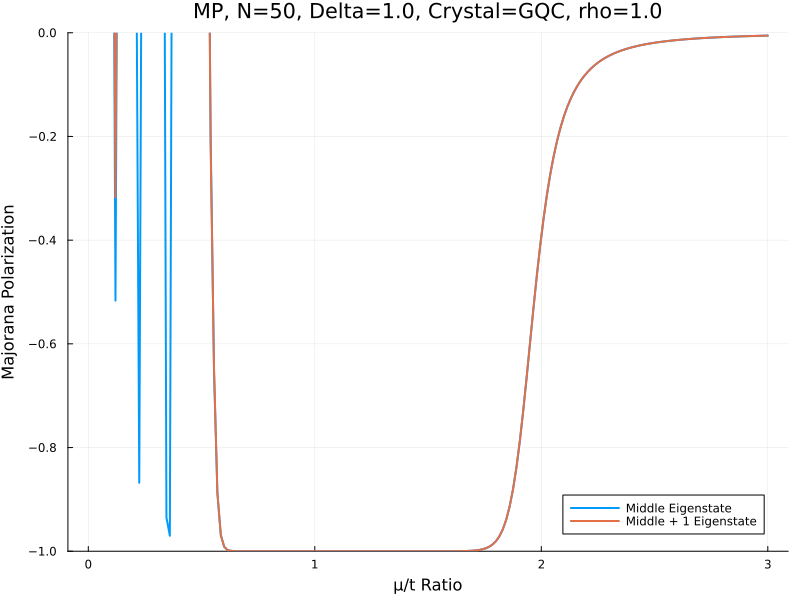

In [58]:
function plot_mp_for_middle_states(results::Vector{Dict{String, Any}})#, N::Int, Delta::Float64, crystal_type::String)
    """
    Plots the MP values for the middle two eigenstates as separate lines.

    Parameters:
    results -- Vector of dictionaries, each containing "MP" and "mu_t_ratio".

    Returns:
    Nothing. Displays a plot.
    """
    mu_t_ratios = [row["mu_t_ratio"] for row in results]
    # mp_middle = [real(row["MP"]) for row in results] ## adjustment to make function work for CORRECT MP (see mp calc function above)
    mp_values = [row["MP"] for row in results]
    
    middle_index = div(size(mp_values[1], 1), 2)
    middle_plus_one = middle_index + 1
    middle_plus_two = middle_index + 2

    mp_middle = [real(mp[middle_index]) for mp in mp_values]
    mp_middle_complex = [(mp[middle_index]) for mp in mp_values]

    mp_middle_plus_one = [real(mp[middle_plus_one]) for mp in mp_values]
    mp_middle_plus_two = [real(mp[middle_plus_two]) for mp in mp_values]

    plt = Plots.plot(
        mu_t_ratios, mp_middle,
        title = "MP, N=$N_mp, Delta=$Delta_mp, Crystal=$crystal_type_mp, rho=$rho_mp",
        label = "Middle Eigenstate",
        xlabel = "μ/t Ratio",
        ylabel = "Majorana Polarization",
        lw = 2,
        grid = true,
        size = (800,600)
    )

    Plots.plot!(
        mu_t_ratios, mp_middle_plus_one,
        label = "Middle + 1 Eigenstate",
        lw = 2,
        # marker = :circle,
        # markersize = 2
    )

    # Plots.plot!(
    #     mu_t_ratios, mp_middle_plus_two,
    #     label = "Middle + 2 Eigenstate",
    #     lw = 2,
    #     # marker = :circle,
    #     # markersize = 2
    # )

    # xlims_range = (0.0, 4.0)
    ylims_range = (-1.0, 0.0)

    # xlims!(plt, xlims_range)
    ylims!(plt, ylims_range)

    # Plots.savefig("/Users/Will/Documents/FINAL_PROJECT/simulations/images_and_graphs/mp_sitewise/MP, N=$N_mp, Delta=$Delta_mp, Crystal=$crystal_type_mp, rho=$rho.png")
end

plot_mp_for_middle_states(mp_results)

In [69]:
function plot_mp_tolerance_map(results::Vector{Dict{String, Any}}, tol_values::Vector{Float64}, filename::String)
    """
    Plots a 2D heatmap where each (mu/t, tol) point is colored based on whether
    MP > -1 + tol (value 1) or MP <= -1 + tol (value 0), using Viridis colors.

    Parameters:
    results -- Vector of dictionaries, each containing "MP" and "mu_t_ratio".
    tol_values -- Vector of tolerance values to evaluate.

    Returns:
    Nothing. Displays a heatmap.
    """
    mu_t_ratios = [row["mu_t_ratio"] for row in results]
    mp_values = [row["MP"] for row in results]

    middle_index = div(size(mp_values[1], 1), 2)
    mp_middle = [real(mp[middle_index]) for mp in mp_values]

    classification_matrix = zeros(Float64, length(tol_values), length(mu_t_ratios))

    for (i, tol) in enumerate(tol_values)
        for (j, mp) in enumerate(mp_middle)
            classification_matrix[i, j] = mp > -1 + tol ? 1.0 : 0.0
        end
    end

    plt = heatmap(
        mu_t_ratios,
        tol_values,
        classification_matrix,
        xlabel = L"\mu / t_A",
        ylabel = L"\textnormal{Tolerance}",
        # title = "Classification Map",
        color = cgrad(:viridis, [0.0, 1.0], rev = false),
        clim = (0.0, 1.0),
        size = (800, 600),
        ylims = (minimum(tol_values), maximum(tol_values)),
        xlims = (1.2, 1.3),
        yscale = :log10,
        legend = false,
        labelfontsize = 20,
        tickfontsize = 12,
        legendfontsize = 20,
        left_margin = 5mm,
        bottom_margin = 5mm,
        yticks = log_range(10.0, -12.0, 0.0, 13),
        # xticks = collect(0.0:0.5:3)
    )

    Plots.savefig(plt, "/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/mp_fractality/$(filename)")
end

tol_range = log_range(10.0, -12.0, -7.0, 1792)
println(collect(tol_range))
filename = "mp_fractality_N610_mudense_zoomed"
plot_mp_tolerance_map(mp_results, collect(tol_range), filename)


"/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/mp_fractality/mp_fractality_N610_mudense_zoomed.png"

In [55]:
ints = collect(8:12)
N_range = golden_LengthCalc(ints)
println(N_range)

rho_mp = 1.5
t_list_mp = [1.0, rho_mp]
mu_values_mp = collect(range(0.0, 3.0, 601))
Delta_mp = 0.05
sequence_mp = golden_sequence
crystal_type_mp = "GQC"

all_mp_data = []

for N_mp in N_range
    mp_pre_results = eigenvalue_finder_for_mu_tn_generalised(N_mp, t_list_mp, sequence_mp, mu_values_mp, Delta_mp)
    mp_results = calculate_mp_for_results_dict(mp_pre_results)

    mu_t_ratios = [row["mu_t_ratio"] for row in mp_results]
    mp_values = [row["MP"] for row in mp_results]
    middle_index = div(size(mp_values[1], 1), 2)
    mp_middle = [real(mp[middle_index]) for mp in mp_values]

    push!(all_mp_data, (N_mp, mu_t_ratios, mp_middle))
end


[55, 89, 144, 233, 377]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:31
Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


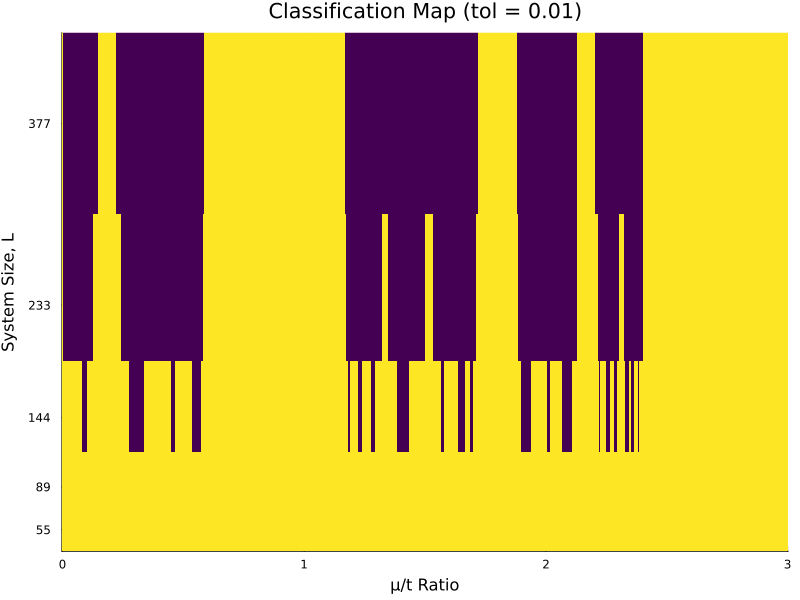

In [61]:
function plot_mp_vs_N_heatmap(all_mp_data::Vector{Any}, tol::Float64)
    """
    Plots a heatmap with μ/t on x-axis and N on y-axis.
    Each point is colored based on whether MP > -1 + tol.

    Parameters:
    - all_mp_data: vector of (N, mu_t_ratios, mp_middle)
    - tol: tolerance threshold for MP classification

    Returns:
    Nothing. Displays a heatmap.
    """
    N_values = [data[1] for data in all_mp_data]
    mu_t_ratios = all_mp_data[1][2]  # assumes all mu_t are the same
    num_mu = length(mu_t_ratios)
    num_N = length(N_values)

    classification_matrix = zeros(Float64, num_N, num_mu)

    for (i, (N, mu_list, mp_list)) in enumerate(all_mp_data)
        for j in 1:num_mu
            classification_matrix[i, j] = mp_list[j] > -1 + tol ? 1.0 : 0.0
        end
    end

    heatmap(
        mu_t_ratios,
        N_values,
        classification_matrix,
        xlabel = "μ/t Ratio",
        ylabel = "System Size, L",
        title = "Classification Map (tol = $tol)",
        color = cgrad(:viridis, [0.0, 1.0]),
        clim = (0.0, 1.0),
        size = (800, 600),
        legend = false,
        yticks = N_values
    )
end

plot_mp_vs_N_heatmap(all_mp_data, 1e-2)


In [ ]:
function plot_mp_sitewise_for_middle_states(results::Vector{Dict{String, Any}}, mu_t_value::Float64, label::String)
    """
    Plots the sitewise MP values for the middle and middle + 1 eigenstates for a specific μ/t value.

    Parameters:
    results -- Vector of dictionaries, each containing "MP" (sitewise) and "mu_t_ratio".
    mu_t_value -- The specific μ/t ratio to plot the MP for.

    Returns:
    Nothing. Displays a plot.
    """
    result = findfirst(row -> isapprox(row["mu_t_ratio"], mu_t_value, atol=1e-6), results)
    
    if result === nothing
        error("No results found for μ/t = $mu_t_value")
    end
    

    mp_sitewise = results[result]["MP"]
    println(length(mp_sitewise))
    num_sites, num_states = size(mp_sitewise)
    println(size(mp_sitewise))
    
    middle_index = div(num_states, 2)
    middle_plus_one = middle_index + 1
    middle_plus_two = middle_index + 2

    mp_middle = real(mp_sitewise[:, middle_index])
    mp_middle_plus_one = real(mp_sitewise[:, middle_plus_one])
    mp_middle_plus_two = real(mp_sitewise[:, middle_plus_two])

    # mp_total = (mp_middle + mp_middle_plus_one) / 2
    mp_total = [coalesce(a, 0) + coalesce(b, 0) for (a, b) in zip(mp_middle, mp_middle_plus_one)]
    # mp_total = mp_total / 2

    site_indices = 1:num_sites

    plt = Plots.plot(
        site_indices, mp_middle,
        title = "Sitewise MP for μ/t = $mu_t_value (N=$N_mp, Delta=$Delta_mp, Crystal=$crystal_type_mp)",
        label = "Middle Eigenstate",
        xlabel = "Site Index",
        ylabel = "Majorana Polarization",
        lw = 2,
        grid = true,
        size = (800, 600),
        # legend = false
    )

    Plots.plot!(
        site_indices, mp_middle_plus_one,
        label = "Middle + 1 Eigenstate",
        lw = 2
    )

    Plots.plot!(
        site_indices, mp_middle_plus_two,
        label = "Middle + 2 Eigenstate",
        lw = 0.5
    )

    Plots.savefig(plt, "mp_sitewise_$label.png")

end

function save_mp_sitewise_plots(mu_list)
    for (i, mu) in enumerate(mu_list)
        label = "$i"
        # println(label, mu)
        plot_mp_sitewise_for_middle_states(mp_sitewise_results, mu, label)
    end
end
        

# mu_to_plot = mu_values_mp[3]
# plot_mp_sitewise_for_middle_states(mp_sitewise_results, mu_to_plot, "1")
mu_list_here = mu_values_mp
save_mp_sitewise_plots(mu_list_here)

### High Precision MP Calc

We expect the erratic behaviour in certain topological paremeter regimes of the MP is due to the precision limit on the values in the Hamiltonian and resulting eigenstate vectors. The energy degeneracy breaking did not solve the problem, this is because the eigenstates themselves were still imprecise, leading to numerator = 0 errors in the MP calc.

The below code uses BigFloat to increase the precision, showing that the erratic behaviour goes away.

In [ ]:
using GenericLinearAlgebra
using ProgressMeter

function high_precision_create_bdg_hamiltonian(
    N::Int, 
    t_n::Vector{Float64}, 
    mu::Float64, 
    Delta::Float64,
    sequence::Vector{Int},
    precision::Int
)

    setprecision(BigFloat, precision)
    
    t_n = BigFloat.(t_n)
    mu = BigFloat(mu)
    Delta = BigFloat(Delta)
    
    H0 = zeros(Complex{BigFloat}, N, N)
    for i in 1:N-1
        H0[i, i] = -mu
        hopping_index = sequence[i]
        H0[i, i+1] = -t_n[hopping_index]
        H0[i+1, i] = -t_n[hopping_index]
    end
    H0[N, N] = -mu

    Delta_matrix = zeros(Complex{BigFloat}, N, N)
    for i in 1:N-1
        Delta_matrix[i, i+1] = Delta
        Delta_matrix[i+1, i] = -Delta
    end

    BdG = zeros(Complex{BigFloat}, 2N, 2N)
    BdG[1:N, 1:N] = H0
    BdG[N+1:end, N+1:end] = -conj(H0)
    BdG[1:N, N+1:end] = Delta_matrix
    BdG[N+1:end, 1:N] = Delta_matrix'

    return BdG
end

function high_precision_eigensolver(
    N_range::Vector{Int},
    t_n_range::Vector{Vector{Float64}},
    mu_range::Vector{Float64},
    Delta_range::Vector{Float64},
    sequence::Vector{Int},
    precision::Int
)
    # setprecision(BigFloat, precision)

    results = Dict()
    
    # @showprogress Threads.@threads for N in N_range
    #     truncated_sequence = Vector(sequence[1:N])

    #     for t_n in t_n_range
    #         for mu in mu_range
    #             for Delta in Delta_range

    #                 BdG = high_precision_create_bdg_hamiltonian(N, t_n, mu, Delta, truncated_sequence, precision)

    #                 eigenvalues, eigenvectors = GenericLinearAlgebra.eigen(Hermitian(BdG)) #big.BdG ??
                    
    #                 eigenvalues = BigFloat.(eigenvalues)
    #                 eigenvectors = BigFloat.(eigenvectors)

    #                 results[(N, t_n, mu, Delta)] = Dict(
    #                     "eigenvalues" => Vector(eigenvalues),
    #                     "eigenvectors" => Matrix(eigenvectors)
    #                 )
    #             end
    #         end
    #     end
    # end

    @showprogress Threads.@threads for (N, t_n, mu, Delta) in collect(Iterators.product(N_range, t_n_range, mu_range, Delta_range))
        truncated_sequence = Vector(sequence[1:N])
        BdG = high_precision_create_bdg_hamiltonian(N, t_n, mu, Delta, truncated_sequence, precision)
        eigenvalues, eigenvectors = GenericLinearAlgebra.eigen(Hermitian(BdG))
        results[(N, t_n, mu, Delta)] = Dict(
            "eigenvalues" => Vector(BigFloat.(eigenvalues)),
            "eigenvectors" => Matrix(BigFloat.(eigenvectors))
        )
    end

    return results
end

function high_precision_mp_calc(
    eigenvectors::Matrix{BigFloat} # N.B. the eigen function gives only real eigenvectors since Hermitian is explicit
)
    num_cols = size(eigenvectors, 2)
    num_rows = size(eigenvectors, 1)
    N = num_rows ÷ 2

    MP_L = zeros(Complex{Float64}, num_cols)
    MP_R = zeros(Complex{Float64}, num_cols)

    num_L = zeros(Complex{Float64}, num_cols)
    num_R =  zeros(Complex{Float64}, num_cols)

    den_L = zeros(Complex{Float64}, num_cols)
    den_R = zeros(Complex{Float64}, num_cols)

    num_tau = 0.0
    den_tau = 0.0 #1e-9im

    for n in 1:num_cols
        u = eigenvectors[1:N, n]
        v = eigenvectors[(N+1):2N, n]
        
        # MP_L: sum over left half of the chain
        numerator_L = BigFloat(sum(u[i] * conj(v[i]) + v[i] * conj(u[i]) for i in 1:(N÷2)) + num_tau)
        denominator_L = BigFloat(sum(abs2(u[i]) + abs2(v[i]) for i in 1:(N÷2)) + den_tau)
        num_L[n] = numerator_L
        den_L[n] = denominator_L
        MP_L[n] = numerator_L / denominator_L
        
        # MP_R: sum over right half of the chain
        numerator_R = BigFloat(sum(u[i] * conj(v[i]) + v[i] * conj(u[i]) for i in ((N÷2)+1):N) + num_tau)
        denominator_R = BigFloat(sum(abs2(u[i]) + abs2(v[i]) for i in ((N÷2)+1):N) + den_tau)
        num_R[n] = numerator_R
        den_R[n] = denominator_R
        MP_R[n] = numerator_R / denominator_R

    end

    overall_MP = MP_L .* MP_R

    return num_L, den_L, num_R, den_R, MP_L, MP_R, overall_MP
end

function high_precision_mp_sitewise_calc(
    eigenvectors::Matrix{BigFloat}
)
    num_cols = size(eigenvectors, 2)
    num_rows = size(eigenvectors, 1)
    N = num_rows ÷ 2

    mp_sitewise = zeros(BigFloat, N, num_cols)
    nums = zeros(ComplexF64, N, num_cols)
    dens = zeros(ComplexF64, N, num_cols)
    
    for n in 1:num_cols
        u = eigenvectors[1:N, n]
        v = eigenvectors[(N+1):2N, n]

        for i in 1:N
            numerator = BigFloat(u[i] * conj(v[i]) + v[i] * conj(u[i]))
            denominator = BigFloat(abs2(u[i]) + abs2(v[i]))
            mp_sitewise[i, n] = BigFloat(numerator / denominator)
            nums[i] = numerator
            dens[i] = denominator
        end
    end

    println("mp_sitewise type in calc: $(typeof(mp_sitewise))")

    return nums, dens, mp_sitewise
end

function high_precision_mp_solver(
    resutlts::Dict{Any, Any}
)
    for (key, row) in results
        eigenvectors = row["eigenvectors"]

        num_L, den_L, num_R, den_R, MP_L, MP_R, overall_MP_values = high_precision_mp_calc(eigenvectors)
        
        row["num_L"] = num_L
        row["den_L"] = den_L
        row["num_R"] = num_R
        row["den_R"] = den_R
        row["MP_L"] = MP_L
        row["MP_R"] = MP_R
        row["overall_MP_values"] = overall_MP_values
    end
    
    return results
end

function high_precision_mp_sitewise_solver(
    resutlts::Dict{Any, Any}
)
    for (key, row) in results
        eigenvectors = row["eigenvectors"]

        nums, dens, mp_sitewise = high_precision_mp_sitewise_calc(eigenvectors)
        num_L, den_L, num_R, den_R, MP_L, MP_R, overall_MP_values = high_precision_mp_calc(eigenvectors)
        
        row["nums"] = nums
        row["dens"] = dens
        row["mp_sitewise"] = mp_sitewise
        row["overall_mp"] = overall_MP_values
        # println(typeof(mp_sitewise))
    end
    
    return results
end





# # Single Use
# # Hamiltonian parameters
# N_high_prec_MP = 2
# t_list_high_prec_MP = [1.0, 2.0]#, 0.8]
# mu_high_prec_MP = t_list[1]
# Delta_high_prec_MP = 1.0 * t_list[1]
# sequence_high_prec_MP = golden_sequence

BigFloat_precision = 512

# BdG = create_bdg_hamiltonian_high_precision(N_high_prec_MP, t_list_high_prec_MP, mu_high_prec_MP, Delta_high_prec_MP, sequence_high_prec_MP)
# # Matrix(BdG)


# General Use
# Parameter ranges
N_range = [20] #floor.(Int, log_range(10.0, 1.0, 1.0, 1)) # collect(Int, range(100, 100, 1)) 

t1_range = collect(range(1.0, 1.0, 1))
t2_range = collect(range(2.0, 2.0, 1))
t_ranges = [t1_range, t2_range]
t_combinations = t_ranges_combinations(t_ranges)
# println(length(t_combinations))

mu_range = collect(range(0.0, 4.0, length=81))

Delta_range = [1.0] # log_range(10.0, 0.0, 0.0, 1)

sequence = golden_sequence


results = high_precision_eigensolver(N_range, t_combinations, mu_range, Delta_range, sequence, BigFloat_precision)
hp_mp_results = high_precision_mp_solver(results)

# print_results_structure(hp_mp_results)


###########
# N.B. 100 sites, 31 mus @ 64-bit precision took 4.5mins and 512-bit took 9mins

# hp_mp_sitewise_results = high_precision_mp_sitewise_solver(results)
# N.B. 100 sites, 6 mus @ 512-bit took 1.5mins

# specific_key = (10, [1.0], 0.9, 1.0)

# # Access the "overall_MP" data for the specific parameter key
# overall_MP_data = hp_mp_results[specific_key]["overall_MP"]

# # Show the type of the "overall_MP" data
# println("Type of overall_MP data: ", typeof(overall_MP_data))

In [ ]:
function hp_plot_eigenvalues_mp(
    results::Dict{Any, Any}, 
    fileindex::Int, 
    N::Int, 
    Delta::Float64, 
    t_list::Vector{Float64}, 
    sequence_name::String, 
    variable::String, 
    eigenvalues_column::String,
)
    """
    Plots eigenvalues as a function of μ/t on the primary y-axis and MP middle on a secondary y-axis.

    Parameters:
    results             -- Vector of dictionaries containing results.
    fileindex           -- Int: Index for saving the file.
    variable            -- String: The variable used for the x-axis (default: "mu_t_ratio").
    eigenvalues_column  -- String: The column containing eigenvalues (default: "eigenvalues").
    """

    fig, ax1 = plt.subplots(figsize=(8, 6))  # Create main figure and first axis

    ax1.set_title("$sequence_name, N=$N, Delta=$Delta, rho=$(t_list[2])")

    mu_values = []
    overall_MP = []
    eigenvalues = []

    for (key, row) in results
        mu = key[3]  # Accessing the third element of the tuple key for mu
        push!(mu_values, mu)
        push!(overall_MP, row["overall_MP_values"])
        push!(eigenvalues, row["eigenvalues"])
    end

    println("length of mu values: $(length(mu_values))")
    println("length of MP values: $(length(overall_MP))")
    println("length of eigs list: $(length(eigenvalues))")

    # Sorting the mu values from smallest to largest, then the other quantities accordingly
    sorted_indices = sortperm(mu_values)
    sorted_mu_values = mu_values[sorted_indices]
    sorted_overall_MP = [overall_MP[i] for i in sorted_indices]
    sorted_eigenvalues = [eigenvalues[i] for i in sorted_indices]
 
    # Extract specific index for all plotted values
    middle_index = div(length(overall_MP[1]), 2)

    mid_overall_MP_values = [sorted_overall_MP[i][middle_index] for i in 1:length(sorted_mu_values)]
    # mid_eigenvalues_values = [sorted_eigenvalues[i][middle_index] for i in 1:length(sorted_mu_values)]


    num_eigenvalues = length(sorted_eigenvalues[1])
    println("num eigs: $num_eigenvalues")
    eigenvalue_lines = [ [sorted_eigenvalues[i][j] for i in 1:length(sorted_mu_values)] for j in 1:num_eigenvalues ]
    println("length of eig lines: $(length(eigenvalue_lines))")

    # Plot eigenvalues on primary y-axis
    ax1.set_xlabel("μ/t")
    ax1.set_ylabel("Eigenvalues", color="C0")
    ax1.grid(true)
    
    # for i in 1:num_eigenvalues
    #     eigenvalue_line = [eigenvalues[i] for eigenvalues in sorted_eigenvalues]
    #     ax1.plot(sorted_mu_values, eigenvalue_line, linewidth=0.7)#, color="C0", alpha=0.7)  # Eigenvalues in blue
    # end
    for line in eigenvalue_lines
        ax1.plot(sorted_mu_values, line, linewidth=0.7)#, color="C0", alpha=0.7)
    end
    
    # Create secondary y-axis for MP middle values
    ax2 = ax1.twinx()  
    ax2.set_ylabel("MP", color="C1")
    ax2.set_ylim(-1.01, 0.01)
    ax2.plot(sorted_mu_values, mid_overall_MP_values, color="C1", alpha=0.7)

    fig.tight_layout()

    # Save plot
    filename = "GQC_eigs_mp_$fileindex.png"
    fig.savefig(filename, dpi=1600)
    # println("Saved plot as $filename")

    # plt.show()
end

N = N_range[1]
Delta = Delta_range[1]
t_list = t_combinations[1]
sequence_name = "GQC"
hp_plot_eigenvalues_mp(hp_mp_results, 3, N, Delta, t_list, sequence_name, "mu_t_ratio", "eigenvalues")

In [ ]:
function high_precision_mp_plot(
    results::Dict{Any, Any}
)
    mu_values = []
    num_L = []
    den_L = []
    num_R = []
    den_R = []
    MP_L = []
    MP_R = []
    overall_MP = []
    eigenvalues = []

    for (key, row) in results
        mu = key[3]  # Accessing the third element of the tuple key for mu
        push!(mu_values, mu)
        push!(num_L, row["num_L"])
        push!(den_L, row["den_L"])
        push!(num_R, row["num_R"])
        push!(den_R, row["den_R"])
        push!(MP_L, row["MP_L"])
        push!(MP_R, row["MP_R"])
        push!(overall_MP, row["overall_MP_values"])
        push!(eigenvalues, row["eigenvalues"])
    end

    # Sorting the mu values from smallest to largest, then the other quantities accordingly
    sorted_indices = sortperm(mu_values)
    sorted_mu_values = mu_values[sorted_indices]
    sorted_num_L = [num_L[i] for i in sorted_indices]
    sorted_den_L = [den_L[i] for i in sorted_indices]
    sorted_num_R = [num_R[i] for i in sorted_indices]
    sorted_den_R = [den_R[i] for i in sorted_indices]
    sorted_MP_L = [MP_L[i] for i in sorted_indices]
    sorted_MP_R = [MP_R[i] for i in sorted_indices]
    sorted_overall_MP = [overall_MP[i] for i in sorted_indices]
    sorted_eigenvalues = [eigenvalues[i] for i in sorted_indices]
 
    # Extract specific index for all plotted values
    middle_index = div(length(overall_MP[1]), 2)
    middle_plus_one_index = middle_index + 1

    mid_overall_MP_values = [sorted_overall_MP[i][middle_index] for i in 1:length(sorted_mu_values)]
    mid_eigenvalues_values = [sorted_eigenvalues[i][middle_index] for i in 1:length(sorted_mu_values)]
    mid_num_L_values = [sorted_num_L[i][middle_index] for i in 1:length(sorted_mu_values)]
    mid_den_L_values = [sorted_den_L[i][middle_index] for i in 1:length(sorted_mu_values)]
    mid_num_R_values = [sorted_num_R[i][middle_index] for i in 1:length(sorted_mu_values)]
    mid_den_R_values = [sorted_den_R[i][middle_index] for i in 1:length(sorted_mu_values)]
    mid_MP_L_values = [sorted_MP_L[i][middle_index] for i in 1:length(sorted_mu_values)]
    mid_MP_R_values = [sorted_MP_R[i][middle_index] for i in 1:length(sorted_mu_values)]

    mpo_overall_MP_values = [sorted_overall_MP[i][middle_plus_one_index] for i in 1:length(sorted_mu_values)]
    mpo_eigenvalues_values = [sorted_eigenvalues[i][middle_plus_one_index] for i in 1:length(sorted_mu_values)]
    mpo_num_L_values = [sorted_num_L[i][middle_plus_one_index] for i in 1:length(sorted_mu_values)]
    mpo_den_L_values = [sorted_den_L[i][middle_plus_one_index] for i in 1:length(sorted_mu_values)]
    mpo_num_R_values = [sorted_num_R[i][middle_plus_one_index] for i in 1:length(sorted_mu_values)]
    mpo_den_R_values = [sorted_den_R[i][middle_plus_one_index] for i in 1:length(sorted_mu_values)]
    mpo_MP_L_values = [sorted_MP_L[i][middle_plus_one_index] for i in 1:length(sorted_mu_values)]
    mpo_MP_R_values = [sorted_MP_R[i][middle_plus_one_index] for i in 1:length(sorted_mu_values)]


    plt = Plots.plot(
        sorted_mu_values, mid_overall_MP_values,
        title = "Overall Majorana Polarization",
        label = "Overall MP (middle)",
        xlabel = "μ Values",
        ylabel = "misc", #"Overall MP",
        lw = 2,
        grid = true,
        size = (800,600)
    )

    Plots.plot!(
        sorted_mu_values, mpo_overall_MP_values,
        label = "Overall MP (middle + 1)",
        lw = 2
    )

    # Plots.plot!(
    #     sorted_mu_values, mid_num_L_values,
    #     label = "Left Numerator",
    #     lw = 2,
    #     linestyle=:dash
    # )

    # Plots.plot!(
    #     sorted_mu_values, mid_den_L_values,
    #     label = "Left Denominator",
    #     lw = 2,
    #     linestyle=:dash
    # )

    # Plots.scatter!(
    #     sorted_mu_values, mid_MP_L_values,
    #     label = "Left MP"
    # )

    # Plots.scatter!(
    #     sorted_mu_values, mid_num_R_values,
    #     label = "Right Numerator",
    #     lw = 2
    # )

    # Plots.plot!(
    #     sorted_mu_values, mid_den_R_values,
    #     label = "Right Denominator",
    #     lw = 2
    # )

    # Plots.plot!(
    #     sorted_mu_values, mid_MP_R_values,
    #     label = "Right MP"
    # )

    Plots.plot!(
        sorted_mu_values, mid_eigenvalues_values,
        label = "Middle Eigenvalue",
        lw = 2,
        linestyle=:dash
    )

    Plots.plot!(
        sorted_mu_values, mpo_eigenvalues_values,
        label = "Middle + 1 Eigenvalue",
        lw = 2,
        linestyle=:dash
    )

    display(plt)
end

# function high_precision_mp_plot_all_eigenvalues(results::Dict{Any, Any})
#     mu_values = []
#     eigenvalues = []
#     overall_MP = []

#     for (key, row) in results
#         mu = key[3]  # Accessing the third element of the tuple key for mu
#         push!(mu_values, mu)
#         push!(overall_MP, row["overall_MP_values"])
#         push!(eigenvalues, row["eigenvalues"])
#     end

#     # Sorting the mu values from smallest to largest, then the other quantities accordingly
#     sorted_indices = sortperm(mu_values)
#     sorted_mu_values = mu_values[sorted_indices]
#     sorted_overall_MP = [overall_MP[i] for i in sorted_indices]
#     sorted_eigenvalues = [eigenvalues[i] for i in sorted_indices]

#     middle_index = div(length(overall_MP[1]), 2)
#     mid_overall_MP_values = [sorted_overall_MP[i][middle_index] for i in 1:length(sorted_mu_values)]

#     fig, ax1 = plt.subplots(figsize=(8, 6))
#     ax1.set_title("Overall Majorana Polarization")

#     ax1.set_xlabel("μ/t")
#     ax1.set_ylabel("Eigenvalues", color="C0")
#     ax1.grid(true)

#     num_eigenvalues = length(sorted_eigenvalues[1])
#     for idx in 1:num_eigenvalues
#         eigenvalue_series = [sorted_eigenvalues[i][idx] for i in 1:length(sorted_mu_values)]
#         ax1.plot(
#             sorted_mu_values, eigenvalue_series,
#             lw = 1.5,
#         )
#     end

#     ax2 = ax1.twinx()  
#     ax2.set_ylabel("MP", color="C1")
#     ax2.set_ylim(-1.01, 1.01)
#     # Create plot for Overall MP
#     ax2.plot(
#         sorted_mu_values, mid_overall_MP_values, #[sorted_overall_MP[i] for i in 1:length(sorted_mu_values)],
#         color="C1", alpha=1.0
#     )


#     # # Create plot for Overall MP
#     # plt = Plots.plot(
#     #     sorted_mu_values, mid_overall_MP_values, #[sorted_overall_MP[i] for i in 1:length(sorted_mu_values)],
#     #     title = "Overall Majorana Polarization",
#     #     label = "Overall MP",
#     #     xlabel = "μ Values",
#     #     ylabel = "Overall MP",
#     #     lw = 2,
#     #     grid = true,
#     #     size = (800, 600)
#     # )

#     # # Plot all eigenvalues as lines
#     # num_eigenvalues = length(sorted_eigenvalues[1])
#     # for idx in 1:num_eigenvalues
#     #     eigenvalue_series = [sorted_eigenvalues[i][idx] for i in 1:length(sorted_mu_values)]
#     #     Plots.plot!(
#     #         sorted_mu_values, eigenvalue_series,
#     #         label = "Eigenvalue $(idx)",
#     #         lw = 1.5,
#     #         linestyle = :dash
#     #     )
#     # end

#     Plots.savefig("GQC_eigs_mp")
# end

function checker(
    results::Dict{Any, Any}
)
    """
    Plots eigenvalues as a function of μ on the primary y-axis and Majorana Polarization (MP) on a secondary y-axis.

    Parameters:
    results -- Dictionary containing μ values, eigenvalues, and MP values.
    """

    mu_values = []
    MP_values = []
    eigenvalues = []

    for (key, row) in results
        mu = key[3]  # Accessing the third element of the tuple key for mu
        push!(mu_values, mu)
        push!(MP_values, row["overall_MP_values"])
        push!(eigenvalues, row["eigenvalues"])
    end

    # Sort by mu values
    sorted_indices = sortperm(mu_values)
    sorted_mu_values = mu_values[sorted_indices]
    sorted_MP = [MP_values[i] for i in sorted_indices]
    sorted_eigenvalues = [eigenvalues[i] for i in sorted_indices]

    middle_index = div(length(sorted_MP[1]), 2)
    mid_overall_MP_values = [sorted_MP[i][middle_index] for i in 1:length(sorted_mu_values)]

    # Prepare data for plotting
    num_states = length(sorted_eigenvalues[1])
    eigenvalue_lines = [ [sorted_eigenvalues[i][j] for i in 1:length(sorted_mu_values)] for j in 1:num_states ]
    MP_line = [mid_overall_MP_values[i] for i in 1:length(sorted_mu_values)]  # Average MP per μ for simplicity

    # Create plot with two y-axes
    fig, ax1 = PyPlot.subplots(figsize=(8, 6))

    ax1.set_xlabel("μ Values")
    ax1.set_ylabel("Eigenvalues", color="C0")
    ax1.grid(true)

    for line in eigenvalue_lines
        ax1.plot(sorted_mu_values, line, linewidth=0.7, color="C0", alpha=0.7)
    end

    # Secondary y-axis for MP
    ax2 = ax1.twinx()
    ax2.set_ylabel("Majorana Polarization", color="C1")
    ax2.set_ylim(-1.01, 1.01)
    ax2.plot(sorted_mu_values, MP_line, color="C1")#, linestyle=":", linewidth=1.5)

    fig.tight_layout()
    # PyPlot.show()
    Plots.savefig("GQC_eigs_mp")
end





function high_precision_mp_sitewise_plot(
    results::Dict{Any, Any}
)
    mu_values = Float64[]
    nums = []
    dens = []
    mp_sitewise_matrices = []

    overall_MP = []

    for (key, row) in results
        mu = key[3]  # Access the third element of the tuple key for mu
        push!(mu_values, mu)
        push!(nums, row["nums"])
        push!(dens, row["dens"])
        push!(mp_sitewise_matrices, row["mp_sitewise"])
        push!(overall_MP, row["overall_mp"])
    end

    num_sites, num_states = size(mp_sitewise_matrices[1])

    sorted_indices = sortperm(mu_values)
    sorted_mu_values = mu_values[sorted_indices]
    sorted_mp_sitewise_matrices = [mp_sitewise_matrices[i] for i in sorted_indices]

    sorted_overall_mp_values = [overall_MP[i] for i in sorted_indices]

    mid_index = div(num_states, 2)
    mpo_index = mid_index + 1
    site_indices = 1:num_sites

    omp_mid_index = div(length(overall_MP[1]), 2)
    omp_mpo_index = omp_mid_index + 1

    mp_dict = Dict(
        "mid" => [],
        "mpo" => [],
        "overall_mid" => [],
        "overall_mpo" => [],
        "mu" => Float64[]
    )

    # mid_overall_MP_values = [sorted_overall_MP[i][middle_index] for i in 1:length(sorted_mu_values)]

    for i in eachindex(sorted_mu_values)
        mp_sitewise_mid = real(sorted_mp_sitewise_matrices[i][:, mid_index])
        mu_sitewise_mpo = real(sorted_mp_sitewise_matrices[i][:, mpo_index])
        mu_to_plot = sorted_mu_values[i]

        mp_overall_mid = sorted_overall_mp_values[i][omp_mid_index]# for i in 1:length(sorted_mu_values)]
        mp_overall_mpo = sorted_overall_mp_values[i][omp_mpo_index]# for i in 1:length(sorted_mu_values)]

        push!(mp_dict["mid"], mp_sitewise_mid)
        push!(mp_dict["mpo"], mu_sitewise_mpo)
        push!(mp_dict["overall_mid"], mp_overall_mid)
        push!(mp_dict["overall_mpo"], mp_overall_mpo)
        push!(mp_dict["mu"], mu_to_plot)
    end


    n_plots = length(sorted_mu_values)
    n_cols = ceil(Int, sqrt(n_plots))
    n_rows = ceil(Int, n_plots / n_cols)

    plot_list = []
    for i in eachindex(sorted_mu_values)

        p = Plots.plot(
            site_indices, mp_dict["mid"][i],
            title = @sprintf("μ=%.2f, Gloabl MP=%.2f", mp_dict["mu"][i], mp_dict["overall_mid"][i]),
            label="Middle State",
            xlabel="Site Index",
            ylabel="MP",
            lw=2,
            grid=true,
            xticks=(site_indices, string.(site_indices))
        )

        Plots.plot!(p, site_indices, mp_dict["mpo"][i], label="Middle + 1 State", lw=2)
        
        push!(plot_list, p)
    end

    plt = Plots.plot(plot_list..., layout=(n_rows, n_cols), size=(1200, 800))
    
    display(plt)
end





# high_precision_mp_plot(hp_mp_results)
# checker(hp_mp_results)
high_precision_mp_sitewise_plot(hp_mp_sitewise_results)

## Majorana Protected Energy Gap

Here we calculate the degree of protection of the Majorana bounds state (MBS) by finding the difference between the zero energy state and the first excited state energy.

In [ ]:
function calculate_mbs_energy_gap(results::Vector{Dict{String, Any}}, mu_values::Vector{Float64}, tolerance::Float64)
    """
    Finds the mu/t values for which there are two degenerate eigenvalues equal to zero within a given tolerance,
    and calculates the energy gap between zero-energy states and first excited states.

    Parameters:
    results -- Vector of dictionaries containing eigenvalues.
    mu_values -- Vector of mu/t values corresponding to the results.
    tolerance -- Float specifying the tolerance for considering eigenvalues to be zero.

    Returns:
    updated_results -- A new vector of dictionaries with an additional key "MBS_energy_gap".
    """
    updated_results = deepcopy(results)

    for (i, result) in enumerate(results)
        eigenvalues = result["eigenvalues"]
        num_eigenvalues = length(eigenvalues)
        mid_index = div(num_eigenvalues, 2) + 1
        
        if abs(eigenvalues[mid_index - 1]) < tolerance && abs(eigenvalues[mid_index]) < tolerance

            excited_state_1 = eigenvalues[mid_index - 2]
            excited_state_2 = eigenvalues[mid_index + 1]
            
            mbs_energy_gap = abs(excited_state_1 - excited_state_2)
            
            updated_results[i]["MBS_energy_gap"] = mbs_energy_gap
            # make this statement simply return the energy of the first excited state? since will always be x - 0 = x...?
        end
    end

    return updated_results
end

function plot_mbs_energy_gap(results::Vector{Dict{String, Any}}, mu_values::Vector{Float64})
    """
    Plots the MBS energy gap as a function of mu/t ratio.

    Parameters:
    results -- Vector of dictionaries containing "MBS_energy_gap" and "mu_t_ratio".
    mu_values -- Vector of mu/t values corresponding to the results.

    Returns:
    Nothing. Displays the plot.
    """

    mbs_energy_gaps = []
    mu_t_ratios = []

    for (i, result) in enumerate(results)
        if haskey(result, "MBS_energy_gap")
            push!(mbs_energy_gaps, result["MBS_energy_gap"])
            push!(mu_t_ratios, mu_values[i])
        end
    end

    Plots.plot(
        mu_t_ratios, mbs_energy_gaps,
        xlabel = "μ/t Ratio",
        ylabel = "MBS Energy Gap",
        title = "MBS Energy Gap vs μ/t Ratio",
        lw = 2,
        grid = true,
        legend = false,
        # marker = :circle
        size = (800,600)
    )

    # Plots.savefig("images_and_graphs/gap/QC_golden_energy_gap_vs_mu")
end


# # quick eigenvalue checker:
# function print_eigenvalues_for_mu_t_ratios(results::Vector{Dict{String, Any}}, mu_t_ratios::Vector{Float64})
#     for (i, result) in enumerate(results)
#         mu_t = mu_t_ratios[i]
#         eigenvalues = result["eigenvalues"]
#         println("μ/t = $mu_t : Eigenvalues = $eigenvalues")
#     end
# end
# # print_eigenvalues_for_mu_t_ratios(energy_gap_pre_results, energy_gap_mu_values)



# # Hamiltonian parameters
N_gap_mu = N
t_list_gap_mu = t_list
mu_values_gap_mu = collect(range(0.0, stop=5.0, length=101)) #mu_values
Delta_gap_mu = Delta
sequence_gap_mu = sequence

tolerance_gap_mu = 1e-1


energy_gap_pre_results = eigenvalue_finder_for_mu_tn_generalised(N_gap_mu, t_list_gap_mu, sequence_gap_mu, mu_values_gap_mu, Delta_gap_mu)

MBS_energy_gap_results = calculate_mbs_energy_gap(energy_gap_pre_results, mu_values_gap_mu, tolerance_gap_mu)

plot_mbs_energy_gap(MBS_energy_gap_results, mu_values_gap_mu)


From the above we can already tell there is a difference between the normal crystal and quasicrystal system in terms of the evolution of the MBs protected energy gap as a function of just $\mu/t_{1}$. The normal crystal gives a perfectly linear decrease in the protecting gap, whereas the Fibonacci crystal has an initially decreasing slope, leading to better protection for 'longer' as $\mu/t_{1}$ increases. The highest value of $\mu/t_{1}$ where there is a protected MBS is $\approx 0.9$ for the normal crystal and $\approx 1.1$ for the Fibonacci quasicrystal.

The same effect is observed for the silver, Thue-Morse and plastic sequences but to lesser degrees for each compared to the golden ratio Fibonacci QC. Noting, however, these were all for roughly the same $\rho$ (and that $\rho$ hasn't been made properly comparable to the plastic sequence yet), so results may vary with this parameter.

## Solving Hamiltonian as a function of $\rho$

For the QC systems with 2 hopping potentials we can define the quantity $\rho = t_2 / t_1$. We can investigate the behaviou of the system as a function of $\rho$ by fixing all quantities relative to $t_1=1.0$

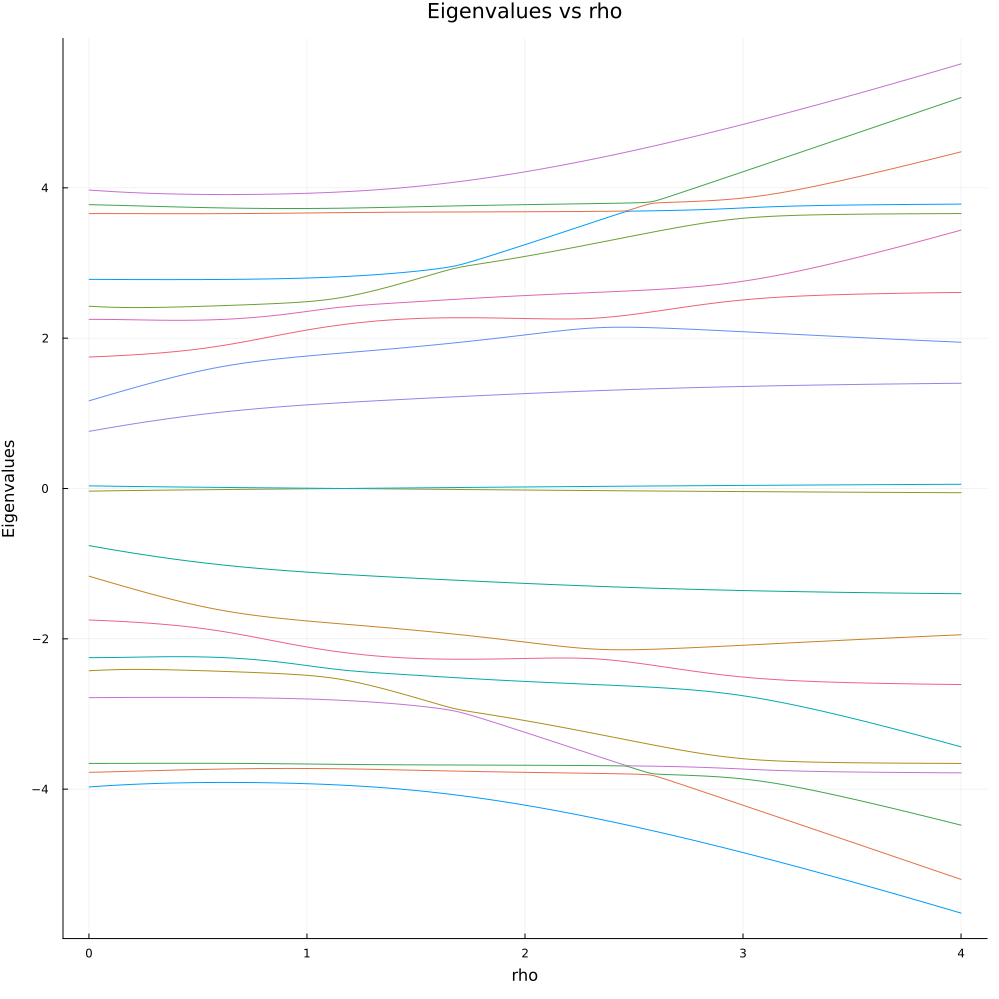

In [16]:
function eigenvalue_finder_for_rho_tn_generalised(N::Int, sequence::Vector{Int}, rho_values::Vector{Float64}, x_values::Vector{Float64}, Delta::Float64=1.0, t_3_value::Union{Nothing, Float64}=nothing)
    """
    Computes the eigenvalues for a list of values of x = mu/t over a range of t_2 values, with t_1 fixed at 1.0.
    
    Parameters:
    N           -- Number of atomic sites in the chain
    sequence    -- Vector of integers indicating the sequence of hopping terms
    rho_values  -- List of values for t_2, with t_1 fixed at 1.0
    x_values    -- List of values for the ratio mu/t (x)
    Delta       -- The value of the pairing constant (default is 1.0)
    
    Returns:
    all_results -- Vector of dictionaries containing the results for each t_2, with an extra column "rho"
    """

    all_results = Vector{Dict{String, Any}}()

    t_1 = 1.0
    # t_2_rev = 1.0

    @showprogress for t_2 in rho_values
        t_n = isnothing(t_3_value) ? [t_1, t_2] : [t_1, t_2, t_3_value]
        rho = t_2 / t_1

        results = eigenvalue_finder_for_mu_tn_generalised(N, t_n, sequence, x_values, Delta)

        for result in results
            result["rho"] = rho
            push!(all_results, result)
        end
    end

    return all_results
end

function eigenvalue_finder_for_rho_tn_generalised_normalised(N::Int, sequence::Vector{Int}, rho_values::Vector{Float64}, x_values::Vector{Float64}, Delta::Float64=1.0, t_3_value::Union{Nothing, Float64}=nothing)
    """
    Computes the eigenvalues for a list of values of x = mu/t over a range of rho values, 
    adjusting t_1 and t_2 so that the system remains normalized.

    Parameters:
    N           -- Number of atomic sites in the chain
    sequence    -- Vector of integers indicating the sequence of hopping terms
    rho_values  -- List of values for rho, adjusting t_1 and t_2 accordingly
    x_values    -- List of values for the ratio mu/t (x)
    Delta       -- The value of the pairing constant (default is 1.0)

    Returns:
    all_results -- Vector of dictionaries containing the results for each rho, with an extra column "rho"
    """

    all_results = Vector{Dict{String, Any}}()

    # @showprogress 
    for rho in rho_values
        if rho ≤ 1.0
            t_1, t_2 = 1.0, rho
        else
            t_1, t_2 = rho, 1.0
        end

        t_n = isnothing(t_3_value) ? [t_1, t_2] : [t_1, t_2, t_3_value]

        results = eigenvalue_finder_for_mu_tn_generalised(N, t_n, sequence, x_values, Delta)

        for result in results
            result["rho"] = rho
            push!(all_results, result)
        end
    end

    return all_results
end


function plot_eigenvalues_for_rho(results::Vector{Dict{String, Any}}, variable::String = "rho", eigenvalues_column::String = "eigenvalues")
    """
    Plots eigenvalues as a function of rho.

    Parameters:
    results             -- Vector of dictionaries containing results.
    variable            -- String: The variable used for the x-axis (rho).
    eigenvalues_column  -- String: The column containing eigenvalues.
    """
    # close()
    plt = Plots.scatter(legend=false, xlabel=variable, ylabel="Eigenvalues", title="Eigenvalues vs $variable", grid=true, size=(1000,1000))
    
    x_values = [result[variable] for result in results]
    all_eigenvalues = [result[eigenvalues_column] for result in results]
    
    num_eigenvalues = length(all_eigenvalues[1])
    
    for i in 1:num_eigenvalues
        eigenvalue_line = [eigenvalues[i] for eigenvalues in all_eigenvalues]
        
        plot!(x_values, eigenvalue_line)#, marker=:circle, ms=2, alpha=0.7)
    end

    display(plt)
end

N_rho = 10
rho_range = collect(range(0.001, stop=4.0, length=400))
mu_value_rho = [0.6]
# t_list_rho = [1.0, 1.5]
t_3 = 2.5
Delta_rho = Delta
sequence_rho = plastic_sequence

rho_results = eigenvalue_finder_for_rho_tn_generalised(N_rho, sequence_rho, rho_range, mu_value_rho, Delta_rho, t_3)

plot_eigenvalues_for_rho(rho_results)



# # Function to print top-level keys
# function print_top_level_keys(data::Vector{Dict{String, Any}})
#     for i in 1:length(data)
#         println("Entry $i:")
#         println(keys(data[i]))
#     end
# end

# Example usage
# print_top_level_keys(rho_mu_results)

In [20]:
"""
Carries out the computationally intensive eigenvalue solving step in the rho / mu parameter space
"""

N_gap_rhomu = 100
rho_range_gap_rhomu = collect(range(0.0, stop=5.0, length=51))
mu_values_gap_rhomu = collect(range(0.0, stop=5.0, length=51))
Delta_gaprhomu = 0.5
t_3 = 2.5
sequence_gap_rhomu = golden_sequence

pre_results_rhomu = eigenvalue_finder_for_rho_tn_generalised_normalised(N_gap_rhomu, sequence_gap_rhomu, rho_range_gap_rhomu, mu_values_gap_rhomu, Delta_gaprhomu)#, t_3)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 

2601-element Vector{Dict{String, Any}}:
 Dict("mu_t_ratio" => 0.0, "mu_values" => 0.0, "eigenvectors" => ComplexF64[2.6179386787537635e-6 + 0.0im -3.162009368795305e-14 + 0.0im … 3.6034214304304076e-14 + 0.0im -2.617938671234713e-6 + 0.0im; 3.3287319091619455e-6 + 0.0im -1.241542737236313e-13 + 0.0im … -1.2976712932312792e-13 + 0.0im 3.328731901510514e-6 + 0.0im; … ; -5.904539429373224e-8 + 0.0im 0.0005574238505364065 + 0.0im … -0.0005574238505278438 + 0.0im 5.904523756476898e-8 + 0.0im; 1.5479063976958424e-8 + 0.0im 0.0001461319365584764 + 0.0im … 0.00014613193656081954 - 0.0im 1.5479105163099648e-8 - 0.0im], "eigenvalues" => [-1.9072631099224293, -1.9072622441559717, -1.9072620704397512, -1.9056151738280083, -1.9056103088365743, -1.901696808758886, -1.9016946539517197, -1.9016942495297318, -1.9014121067735397, -1.8975433895492184  …  1.8975433895492184, 1.9014121067735537, 1.9016942495297302, 1.9016946539517339, 1.9016968087588841, 1.905610308836566, 1.9056151738280076, 1.90726207043

Matrix{Float64}


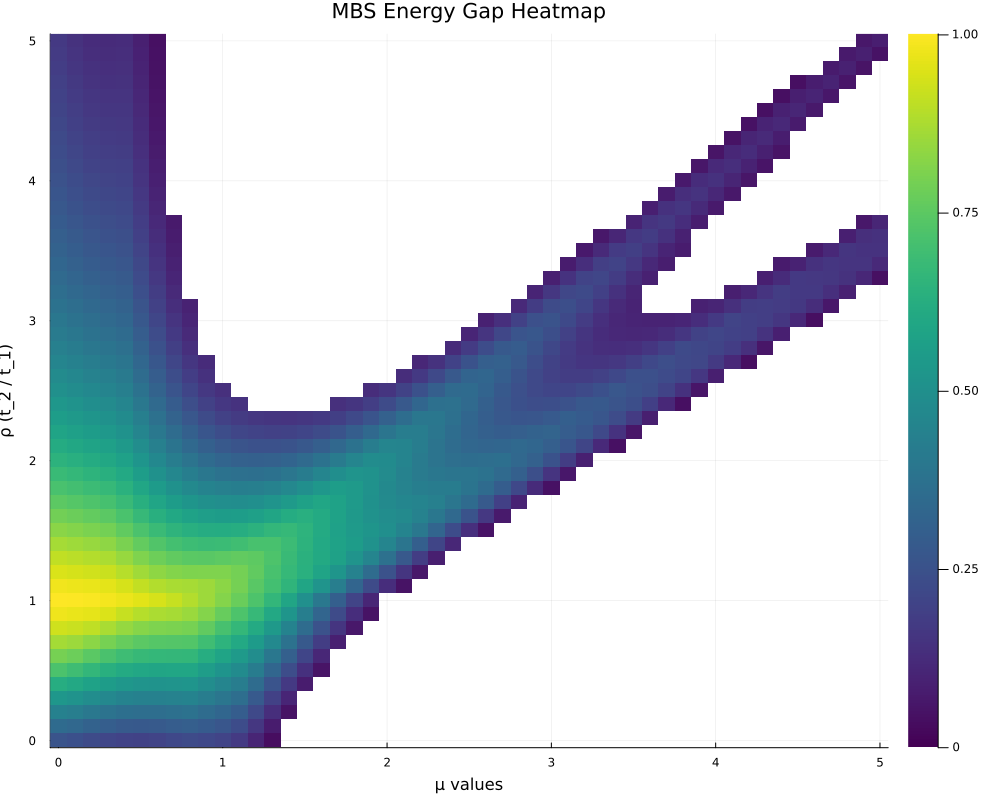

In [21]:
"""
Quickly adjust the tolerance to make new heatmap plots from the above-solved eigenvalues
"""

function calculate_mbs_energy_gap_mu_rho(results::Vector{Dict{String, Any}}, tolerance::Float64)
    """
    Calculates the MBS energy gap for each dictionary in the results structure for data varying in both μ and ρ.

    Parameters:
    results -- Vector of dictionaries containing eigenvalues and corresponding μ and ρ values.
    tolerance -- Float specifying the tolerance for considering eigenvalues to be zero.

    Returns:
    updated_results -- A new vector of dictionaries with an additional key "MBS_energy_gap".
    """
    # updated_results = deepcopy(results)

    @showprogress for (i, result) in enumerate(results)
        eigenvalues = result["eigenvalues"]
        rho = result["rho"]
        mu_t_ratio = result["mu_t_ratio"]

        num_eigenvalues = length(eigenvalues)
        mid_index = div(num_eigenvalues, 2) + 1
        
        if abs(eigenvalues[mid_index - 1]) < tolerance && abs(eigenvalues[mid_index]) < tolerance

            first_excited_state = eigenvalues[mid_index + 1]

            results[i]["MBS_energy_gap"] = abs(first_excited_state)
        else
            results[i]["MBS_energy_gap"] = nothing
        end
    end

    return results
end

function plot_mbs_energy_gap_heatmap(results::Vector{Dict{String, Any}})
    """
    Plots a heatmap of the MBS energy gap as a function of mu/t and rho.

    Parameters:
    results -- Vector of dictionaries containing results with "mu_t_ratio", "rho", and "MBS_energy_gap".
    
    Returns:
    Nothing. Displays the heatmap.
    """

    mu_values = unique([result["mu_values"] for result in results])
    rho_values = unique([result["rho"] for result in results])
    
    mbs_energy_gaps = fill(NaN, length(rho_values), length(mu_values))
    
    for result in results
        mu_index = findfirst(==(result["mu_values"]), mu_values)
        rho_index = findfirst(==(result["rho"]), rho_values)
        
        if result["MBS_energy_gap"] != nothing
            mbs_energy_gaps[rho_index, mu_index] = result["MBS_energy_gap"]
        end
    end

    println(typeof(mbs_energy_gaps))
    
    Plots.heatmap(
        mu_values, rho_values, mbs_energy_gaps,
        xlabel="μ values",
        ylabel="ρ (t_2 / t_1)",
        title="MBS Energy Gap Heatmap",
        color=:viridis,
        clims=(0, maximum(skipmissing(mbs_energy_gaps))),
        colorbar=true,
        size = (1000,800)
    )
end

tolerance_gap_rhomu = 0.01

gap_rhomu_results = calculate_mbs_energy_gap_mu_rho(pre_results_rhomu, tolerance_gap_rhomu)

plot_mbs_energy_gap_heatmap(gap_rhomu_results)

# mu_values_check = [row["rho"] for row in updated_rho_results]
# println(mu_values_check)

In [22]:
function calculate_mp_mu_rho(results::Vector{Dict{String, Any}})
    """
    Calculates the Majorana Polarization (MP) for each dictionary in the results structure
    for data varying in both μ and ρ.

    Parameters:
    results -- Vector of dictionaries containing eigenvectors and corresponding μ and ρ values.

    Returns:
    updated_results -- A new vector of dictionaries with an additional key "MP" containing the 
                       Majorana Polarization for each eigenvector.
    """
    # updated_results = deepcopy(results)

    @showprogress for (i, result) in enumerate(results)
        eigenvectors = result["eigenvectors"]

        mp_values = calculate_majorana_polarisation_individual(eigenvectors)
        
        results[i]["MP"] = mp_values
    end

    return results
end

function plot_mp_heatmaps(results::Vector{Dict{String, Any}})
    """
    Plots two heatmaps: one for the Majorana Polarization (MP) of the middle eigenstate
    and another for the middle + 1 eigenstate, as functions of μ/t and ρ.

    Parameters:
    results -- Vector of dictionaries containing "MP", "mu_t_ratio", and "rho".

    Returns:
    Nothing. Displays the heatmaps.
    """
    # Extract unique μ and ρ values
    mu_values = unique([result["mu_t_ratio"] for result in results])
    rho_values = unique([result["rho"] for result in results])
    
    # Initialize matrices for middle and middle+1 eigenstates
    mp_middle = fill(NaN, length(rho_values), length(mu_values))
    mp_middle_plus_one = fill(NaN, length(rho_values), length(mu_values))
    
    # Find the middle index for MP
    num_eigenvectors = size(results[1]["MP"], 1)
    middle_index = div(num_eigenvectors, 2)
    middle_plus_one_index = middle_index + 1
    
    # Populate the matrices
    for result in results
        mu_index = findfirst(==(result["mu_t_ratio"]), mu_values)
        rho_index = findfirst(==(result["rho"]), rho_values)
        
        if !isnothing(result["MP"])
            mp_values = result["MP"]
            mp_middle[rho_index, mu_index] = real(mp_values[middle_index])
            mp_middle_plus_one[rho_index, mu_index] = real(mp_values[middle_plus_one_index])
        end
    end
    
    # Plot heatmaps
    heatmap1 = Plots.heatmap(
        mu_values, rho_values, mp_middle,
        xlabel="μ/t Ratio",
        ylabel="ρ (t₂ / t₁)",
        title="MP for Middle Eigenstate",
        color=:viridis,
        clims=(minimum(skipmissing(mp_middle)), maximum(skipmissing(mp_middle))),
        colorbar=true,
        size=(800, 600)
    )
    
    heatmap2 = Plots.heatmap(
        mu_values, rho_values, mp_middle_plus_one,
        xlabel="μ/t Ratio",
        ylabel="ρ (t₂ / t₁)",
        title="MP for Middle+1 Eigenstate",
        color=:viridis,
        clims=(minimum(skipmissing(mp_middle_plus_one)), maximum(skipmissing(mp_middle_plus_one))),
        colorbar=true,
        size=(800, 600)
    )
    
    # Combine into a single plot
    Plots.plot(heatmap1, heatmap2, layout=(2, 1), size=(900, 1200))
    # Plots.savefig(heatmap1, "mp_heatmap")
end



results_mp_rhomu = calculate_mp_mu_rho(pre_results_rhomu)

# plot_mp_heatmaps(results_mp_rhomu)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


2601-element Vector{Dict{String, Any}}:
 Dict("mu_t_ratio" => 0.0, "mu_values" => 0.0, "t_n" => [1.0, 0.0], "MBS_energy_gap" => 0.256179409888027, "probabilities" => [6.853602928845728e-12 1.0917025186397991e-27 … 1.0989101308211355e-27 6.85360288532805e-12; 1.1080456138618236e-11 1.585988152045348e-26 … 1.5871631591110257e-26 1.1080456068061927e-11; … ; 3.486352748014803e-15 3.107213491414546e-7 … 3.1072134914166456e-7 3.4863527702634762e-15; 2.3960182288315547e-16 2.1354542882693717e-8 … 2.135454288271976e-8 2.396018244445797e-16], "MP" => ComplexF64[-3.397903818160928e-6 + 0.0im, -5.488341471970288e-14 + 0.0im, -3.388262048177889e-6 + 0.0im, -0.04297187817227493 + 0.0im, -1.1458384130698349e-7 + 0.0im, -1.6402403045882422e-5 + 0.0im, -1.8024469499819102e-18 + 0.0im, -1.6387120593811484e-5 + 0.0im, -8.990435329903935e-12 + 0.0im, -0.04798188451061497 + 0.0im  …  -0.04798188451058941 + 0.0im, -8.990263776290031e-12 + 0.0im, -1.6387120506487927e-5 + 0.0im, -1.3630872805229377e-18 + 0.0

In [23]:
using DataFrames, Plots

function plot_raw_and_discretized_mp(results::Vector{Dict{String, Any}}, tolerance::Float64)
    """
    Plots two heatmaps for the Majorana Polarization (MP) of the middle eigenstate:
    1. The raw MP data.
    2. The discretized MP data with values within -1 ± tolerance set to -1 and others to 0.

    Parameters:
    - results: Vector of dictionaries containing "MP", "mu_t_ratio", and "rho".
    - tolerance: Float value specifying the tolerance for discretization.

    Returns:
    - Nothing. Displays the two heatmaps side by side.
    """

    # Extract unique μ and ρ values
    mu_values = unique([result["mu_values"] for result in results])
    rho_values = unique([result["rho"] for result in results])

    # Initialize matrices for raw and discretized MP
    mp_raw = fill(NaN, length(rho_values), length(mu_values))
    mp_discretized = fill(NaN, length(rho_values), length(mu_values))

    # Find the middle index for MP
    num_eigenvectors = size(results[1]["MP"], 1)
    middle_index = div(num_eigenvectors, 2)

    # Populate the matrices
    for result in results
        mu_index = findfirst(==(result["mu_t_ratio"]), mu_values)
        rho_index = findfirst(==(result["rho"]), rho_values)

        if !isnothing(result["MP"])
            mp_value = real(result["MP"][middle_index])
            mp_raw[rho_index, mu_index] = mp_value
            mp_discretized[rho_index, mu_index] = abs(mp_value + 1) <= tolerance ? -1 : 0
        end
    end

    # # Plot heatmaps
    # heatmap_raw = Plots.heatmap(
    #     mu_values, rho_values, mp_raw,
    #     xlabel="μ/t Ratio",
    #     ylabel="ρ (t₂ / t₁)",
    #     title="Raw MP for Middle Eigenstate",
    #     color=:viridis,
    #     clims=(minimum(skipmissing(mp_raw)), maximum(skipmissing(mp_raw))),
    #     colorbar=true,
    #     size=(800, 600)
    # )

    # heatmap_discretized = Plots.heatmap(
    #     mu_values, rho_values, mp_discretized,
    #     xlabel="μ/t Ratio",
    #     ylabel="ρ (t₂ / t₁)",
    #     title="Discretized MP (Tolerance = $(tolerance))",
    #     colorscale = "Greys",
    #     clims=(-1, 0),
    #     colorbar=true,
    #     size=(800, 600)
    # )

    # # Combine into a single plot
    # Plots.plot(heatmap_raw, heatmap_discretized, layout=(2, 1), size=(900, 1200))
end

# Example usage:
tolerance = 0.01
plot_raw_and_discretized_mp(results_mp_rhomu, tolerance)


ArgumentError: ArgumentError: invalid index: nothing of type Nothing

Percentage area covered by -1 values: 35.90926566705113 %
Weighted percentage according to MBS energy gap size: 14.991987506747897 %
Number of NaN values: 72747


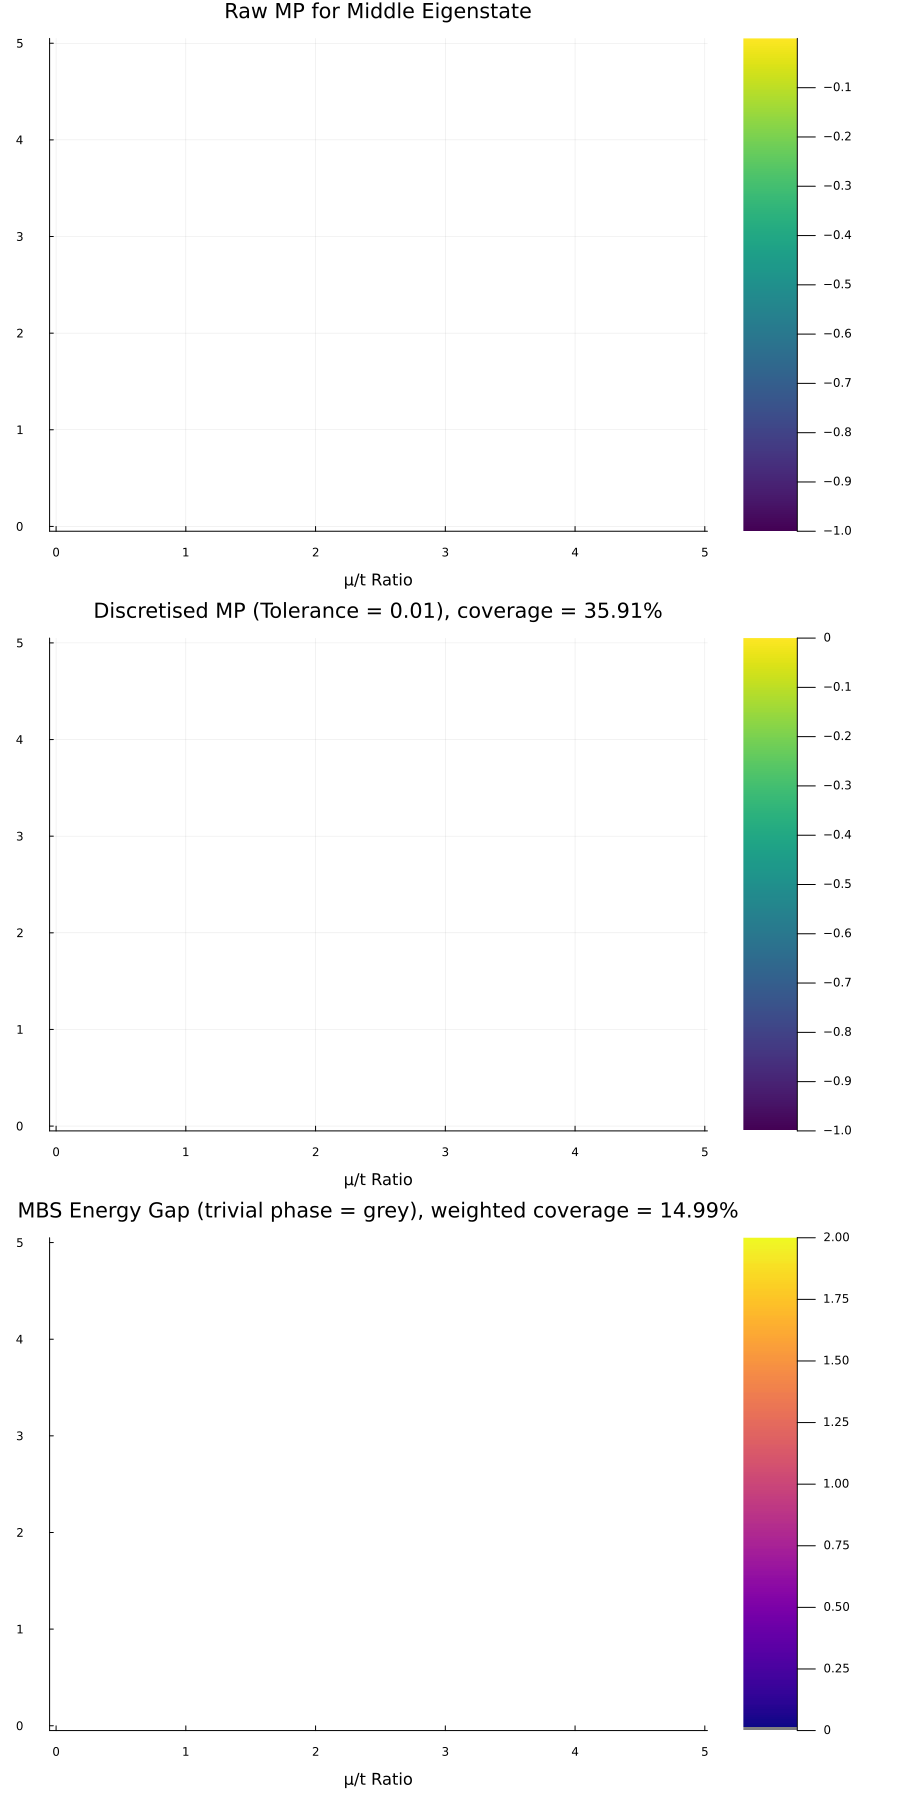

x points not sorted in ascending order
x points not sorted in ascending order
x points not sorted in ascending order
x points not sorted in ascending order
x points not sorted in ascending order
x points not sorted in ascending order
x points not sorted in ascending order
x points not sorted in ascending order
x points not sorted in ascending order


In [25]:
using DataFrames, Plots, Colors, ColorSchemes

function plot_raw_discretized_and_mbs_gap(results::Vector{Dict{String, Any}}, phase_tol::Float64, energ_tol::Float64, filename::String)
    """
    Plots three heatmaps:
    1. The raw MP data for the middle eigenstate.
    2. The discretized MP data with values within -1 ± tolerance set to -1 and others to 0.
    3. The MBS energy gap masked by the discretized MP matrix (only shown where discretized = -1).

    Parameters:
    - results: Vector of dictionaries containing "MP", "mu_t_ratio", "rho", and "eigenvalues".
    - tolerance: Float value specifying the tolerance for discretization and MBS gap calculation.

    Returns:
    - Nothing. Displays the three heatmaps stacked vertically.
    """

    # Extract unique μ and ρ values
    mu_values = unique([result["mu_t_ratio"] for result in results])
    rho_values = unique([result["rho"] for result in results])

    # Initialize matrices
    mp_raw = fill(NaN, length(rho_values), length(mu_values))
    mp_raw_filtered = fill(NaN, length(rho_values), length(mu_values))
    mp_discretized = fill(NaN, length(rho_values), length(mu_values))
    mp_discretized_filtered = fill(NaN, length(rho_values), length(mu_values))
    mbs_energy_gap = fill(NaN, length(rho_values), length(mu_values))

    # Find the middle index for MP
    num_eigenvectors = size(results[1]["MP"], 1)
    middle_index = div(num_eigenvectors, 2) + 1
    # middle_plus_one_index = middle_index + 1

    num_elements = 0.0
    num_minus_ones = 0.0
    total_weighted_gap = 0.0
    # Populate the matrices
    for result in results
        mu_index = findfirst(==(result["mu_t_ratio"]), mu_values)
        rho_index = findfirst(==(result["rho"]), rho_values)

        if !isnothing(result["MP"]) && !isnothing(result["eigenvalues"])
            # MP values
            mp_value = real(result["MP"][middle_index])
            mp_raw[rho_index, mu_index] = mp_value
            
            # # Filtered MP values
            # filtered_value = mp_value > 0.01 ? -1.0 : mp_value
            # mp_raw_filtered[rho_index, mu_index] = filtered_value

            # Filtered MP values based on specified region
            if 0 <= mu_values[mu_index] <= 2.0 && 0 <= rho_values[rho_index] <= 5.0
                filtered_value = -1.0
            else
                filtered_value = mp_value
            end
            mp_raw_filtered[rho_index, mu_index] = filtered_value


            # Discretized MP (raw)
            discretized_value = abs(mp_value + 1) <= phase_tol ? -1 : 0
            mp_discretized[rho_index, mu_index] = discretized_value

            # Discretized MP (filtered)
            discretized_filtered_value = abs(filtered_value + 1) <= phase_tol ? -1 : 0
            mp_discretized_filtered[rho_index, mu_index] = discretized_filtered_value

            # Count -1 values for percentage calculation
            num_elements += 1
            if discretized_value == -1
                num_minus_ones += 1
            end

            # MBS energy gap calculation
            eigenvalues = result["eigenvalues"]
            if abs(eigenvalues[middle_index - 1]) < energ_tol && abs(eigenvalues[middle_index]) < energ_tol
                first_excited_state = eigenvalues[middle_index + 1]
                gap_value = abs(first_excited_state)
                mbs_energy_gap[rho_index, mu_index] = discretized_filtered_value == -1 ? gap_value : NaN # revert to discretized_value for no filter

                # Add to weighted gap sum if -1
                if discretized_filtered_value == -1 # change here as well
                    total_weighted_gap += gap_value
                end

            end
        end
    end

    # Calculate the percentage area covered by -1
    percentage_minus_ones = num_elements == 0 ? NaN : (num_minus_ones / num_elements) * 100
    weighted_percentage = num_elements == 0 ? NaN : (total_weighted_gap / num_elements) * 100 #(num_elements * maximum(skipmissing(mbs_energy_gap)))) * 100

    println("Percentage area covered by -1 values: $percentage_minus_ones %")
    println("Weighted percentage according to MBS energy gap size: $weighted_percentage %")

    
    # Plot heatmaps
    heatmap_raw = Plots.heatmap(
        mu_values, rho_values, mp_raw_filtered, #mp_raw,
        xlabel="μ/t Ratio",
        ylabel="ρ (t₂ / t₁)",
        title="Raw MP for Middle Eigenstate",
        color=:viridis,
        clims=(minimum(skipmissing(mp_raw)), maximum(skipmissing(mp_raw))),
        colorbar=true,
        size=(800, 600)
    )

    heatmap_discretized = Plots.heatmap(
        mu_values, rho_values, mp_discretized_filtered, #mp_discretized,
        xlabel="μ/t Ratio",
        ylabel="ρ (t₂ / t₁)",
        title="Discretised MP (Tolerance = $(phase_tol)), coverage = $(@sprintf("%.2f", percentage_minus_ones))%",
        color=:viridis,
        clims=(-1, 0),
        colorbar=true,
        size=(800, 600)
    )

    # heatmap_mbs_gap = Plots.heatmap(
    #     mu_values, rho_values, mbs_energy_gap,
    #     xlabel="μ/t Ratio",
    #     ylabel="ρ (t₂ / t₁)",
    #     title="MBS Energy Gap (Masked by Discretized MP)",
    #     color=:plasma,
    #     clims=(minimum(skipmissing(mbs_energy_gap)), maximum(skipmissing(mbs_energy_gap))),
    #     colorbar=true,
    #     nan_color=:grey,
    #     size=(800, 600)
    # )
    

    # # Handle NaN values as grey using a custom color scheme
    # c_nan = colorant"grey"
    # # c_inf = colorant"red"
    # m = 16
    # cscheme = palette(ColorScheme([c_nan; ColorSchemes.plasma.colors]), m + 2)#; c_inf]), m + 2)

    # # Replace NaN and Inf for plotting purposes
    # z1, z2 = extrema(x for x in mbs_energy_gap if isfinite(x))
    # dz = (z2 - z1) / m
    # mbs_gap_clean = replace(mbs_energy_gap, NaN => z1 - dz)#, Inf => z2 + dz)

    # Handle NaN values as grey using a custom color scheme
    c_nan = colorant"grey"
    m = 200
    cscheme = palette(ColorScheme([c_nan; ColorSchemes.plasma.colors]), m + 2)

    # Replace NaN values with a value slightly lower than the minimum for plotting
    z1, z2 = extrema(x for x in mbs_energy_gap if isfinite(x))
    dz = (z2 - z1) / 100  # Adjusting dz to ensure NaNs are slightly below the min value
    mbs_gap_clean = replace(mbs_energy_gap, NaN => z1 - dz)

    # check NaNs in MBS matrix
    num_nans = count(isnan, mbs_energy_gap)
    println("Number of NaN values: ", num_nans)

    heatmap_mbs_gap = Plots.heatmap(
        mu_values, rho_values, mbs_gap_clean,
        xlabel="μ/t Ratio",
        ylabel="ρ (t₂ / t₁)",
        title="MBS Energy Gap (trivial phase = grey), weighted coverage = $(@sprintf("%.2f", weighted_percentage))%",
        color= cscheme, #:plasma,
        clims= (0.0, 2.0), #(z1 - dz, z2), #(maximum(mbs_energy_gap), minimum(mbs_energy_gap)), 
        colorbar=true,
        size=(800, 600),
        grid=false
        # nan_color=:lightgray
        # background_color=background_color="#f0f0f0" #:lightgray
        # colorbar_ticks=([z1, z2], ["Min Value", "Max Value"]),  # Set ticks at min and max values of data
        # colorbar_title="MBS Energy Gap",  # Main colorbar title
        # colorbar_labels=("Min", "Max", "NaN"),  # Optional: Labeling the NaN position specifically
        # tickfont=(:black, 10),  # Optional: Customize font for colorbar labels
        # tickdirection=:inward,  # Optional: Adjust tick direction
    )
    # annotate!(N+8, 1, Plots.text("NaN", :white, 9))

    # Combine into a single plot
    Plots.plot(heatmap_raw, heatmap_discretized, heatmap_mbs_gap, layout=(3, 1), size=(900, 1800))
    # Plots.savefig(filename)
end

# Example usage:
filename = "TEST_GQC_N50"
phase_tol = 0.01
energy_gap_tol = 0.1
plot_raw_discretized_and_mbs_gap(results_mp_rhomu, phase_tol, energy_gap_tol, filename)


# Abundance Data and Plotting

## Raw Abundance

In [52]:

Delta = [0.1, 0.2, 0.3, 0.5, 1.0, 2.0]
GQC_abundance = [0.195, 3.2984, 5.3001, 7.909, 11.002, 14.0996]  
SQC_abundance = [0.106, 3.4926, 5.6837, 7.803, 10.728, 13.4178]  
TMQC_abundance = [0.134, 2.868, 4.7242, 7.536, 11.177, 15.74707]  
PQC_sig2_abundance = [0.004, 0.482, 2.986, 4.388, 13.172, 15.946]  
PQC_sig3_abundance = [0.004, 0.09137, 0.669, 4.388, 15.694, 18.461]

Delta_sig4 = [0.1,0.2,0.3]
PQC_sig4_abundance = [0.00393, 0.04843, 0.3240]

Delta_NC = [0.2, 0.3, 0.5]
NC_abundance = [9.786, 9.443, 9.437]

# Logarithmic function with tunable parameters
function log_curve(x, a, b)
    return a * log10.(x) .+ b
end

# Parameters for the logarithmic curve
a = 10      # Scaling factor
b = 10        # Vertical offset
log_x = range(0.1, stop=2.0, length=500)  # Smoother log curve data

# Plot data
Plots.plot(Delta, GQC_abundance, label=L"\textnormal{GQC}", lw=2, marker=:o, xlabel=L"\Delta", ylabel=L"\textnormal{Abundance}", 
           legend=:bottomright, grid=false, size=(800,600), 
           labelfontsize=20, tickfontsize=12, legendfontsize=20,
           left_margin=5mm, bottom_margin=5mm)

Plots.plot!(Delta, SQC_abundance, label=L"\textnormal{SQC}", lw=2, marker=:s)
Plots.plot!(Delta, TMQC_abundance, label=L"\textnormal{TMQC}", lw=2, marker=:d)
Plots.plot!(Delta, PQC_sig2_abundance, label=L"\textnormal{PQC} \ \sigma=2.0", lw=2, marker=:x)
Plots.plot!(Delta, PQC_sig3_abundance, label=L"\textnormal{PQC} \ \sigma=3.0", lw=2, marker=:x)
Plots.plot!(Delta_sig4, PQC_sig4_abundance, label=L"\textnormal{PQC} \ \sigma=4.0", lw=2, marker=:x)
Plots.plot!(Delta_NC, NC_abundance, label=L"\textnormal{NC}", lw=2, marker=:o)

# Add the logarithmic curve
Plots.plot!(log_x, log_curve(log_x, a, b), lw=3, linestyle=:dash, color=:black, label=false) #label=L"\textnormal{Log Curve:} \ a\log_{10}x + b", )

# Save and display
Plots.savefig("/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/abundance/abundance_vs_delta_log_curve_alldata.png")



"/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/abundance/abundance_vs_delta_log_curve_alldata.png"

## Gap-Weighted Abundance

In [51]:
# Example data
Delta = [0.1, 0.2, 0.3, 0.5, 1.0, 2.0]
GQC_abundance = [0.015, 0.6772, 1.36825, 3.083, 8.155, 19.3429]
SQC_abundance = [0.006, 0.74112, 1.49737, 3.283, 8.189, 17.3901]
TMQC_abundance = [0.016, 0.67826, 1.3742, 3.053, 8.130, 21.3167]
PQC_sig2_abundance = [0.000, 0.0716, 0.636, 2.862, 9.620, 20.607]
PQC_sig_3_abundance = [0.000, 0.0079, 0.07645, 0.909, 8.240, 24.276]

Delta_sig4 = [0.1, 0.2, 0.3]
PQC_sig4_abundance = [7.068e-6, 0.002346, 0.0201]

Delta_NC = [0.2, 0.3, 0.5]
NC_abundance = [3.186, 4.477, 7.018]

# Create the plot
Plots.plot(Delta, GQC_abundance, label=L"\textnormal{GQC}", lw=2, marker=:o, xlabel=L"\Delta", ylabel=L"\textnormal{MBS-weighted \ Abundance}", legend=:bottomright, grid=false, 
        size=(800,600),
        labelfontsize = 20,
        tickfontsize = 12,
        legendfontsize = 20,
        left_margin=5mm,
        bottom_margin=5mm        
    )#, color=:blue)
Plots.plot!(Delta, SQC_abundance, label=L"\textnormal{SQC}", lw=2, marker=:s)#, color=:red)
Plots.plot!(Delta, TMQC_abundance, label=L"\textnormal{TMQC}", lw=2, marker=:d)#, color=:green)
Plots.plot!(Delta, PQC_sig2_abundance, label=L"\textnormal{PQC} \ \sigma=2.0", lw=2, marker=:x)#, color=:orange)
Plots.plot!(Delta, PQC_sig_3_abundance, label=L"\textnormal{PQC} \ \sigma=3.0", lw=2, marker=:x)#, color=:orange)
Plots.plot!(Delta_sig4, PQC_sig4_abundance, label=L"\textnormal{PQC} \ \sigma=4.0", lw=2, marker=:x)
Plots.plot!(Delta_NC, NC_abundance, label=L"\textnormal{NC}", lw=2, marker=:o)

# Customize the plot
# xlabel!(L"\Delta")  # X-axis label
# ylabel!("Abundance")  # Y-axis label
# title!(L"Abundance vs Δ for Crystal Types")  # Plot title
# legend(:topright)  # Position the legend
# grid!(true)  # Add grid for readability

# Display the plot
Plots.savefig("/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/abundance/MBS_weighted-abundance_vs_delta_all_data.png")  # Optionally save the plot as an image


"/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/abundance/MBS_weighted-abundance_vs_delta_all_data.png"

# Gap Labelling Theorem

To label the gaps of a QC system first take the DOS, and integrate it, giving the following IDOS quantity called $N(E)$. $N(E)$ is the number of states below a certain energy $E$ as a fraction of the total number of states. Thus it can be calculated as follows
\begin{equation}
    N(E) = \frac{\int_{E_{min}}^E \text{DOS} \ dE}{\int_{E_{min}}^{E_{max}} \text{DOS} \ dE}.
\end{equation}
Then, 
\begin{equation}
    N(E) = \mathbf{p} + \frac{\mathbf{q}}{\tau}
\end{equation}
where $\mathbf{q}$ is the gap labelling integer and $\mathbf{p}$ is another integer set by the condition on $N(E)$ that $0 \leq N(E) \leq 1$. **how find $\tau$**

In [176]:
function eigenvalue_finder_for_seq_generalised(
    N::Int,
    t_n::Vector{Float64},
    sequence::Vector{Int},
    seq_name::String,
    x_values::Vector{Float64},
    Delta::Float64=1.0
)
    """
    Computes the eigenvalues for a list of values of x = mu/t, given a fixed value of either mu or t.
    Returns a vector of dictionaries, one per x.
    """
    results = Vector{Dict{String, Any}}()

    for x in x_values
        H0 = create_normal_hamiltonian_quasi_tn_generalised(N, t_n, x, sequence)
        pairing_matrix = create_pairing_matrix(N, Delta)
        BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)

        eigenvalues, _ = solve_bdg_hamiltonian(BdG)

        push!(results, Dict(
            "sequence" => seq_name,
            "mu_values" => x,
            "t_n" => t_n,
            "eigenvalues" => eigenvalues
        ))
    end

    return results
end



# Define parameters
N_gap = 610
t_list_gap = [1.0, 2.0]
mu_values_gap = [0.5] #collect(range(0.0, 3.0, 4))
Delta_gap = 1.0
sequence_gap = normal_sequence

# gap_labelling_results = eigenvalue_finder_for_mu_tn_generalised(N_gap, t_list_gap, sequence_gap, mu_values_gap, Delta_gap)


# # Dictionary of sequences
# sequence_dict = Dict(
#     "NC" => normal_sequence,
#     "GQC" => golden_sequence,
#     "SQC" => silver_sequence,
#     "TMQC" => thue_morse_sequence,
#     "PQC" => plastic_sequence
# )


all_results = Vector{Dict{String, Any}}()

# # @showprogress for (seq_name, seq) in sequence_dict
# #     result = eigenvalue_finder_for_seq_generalised(N_gap, t_list_gap, seq, seq_name, mu_values_gap, Delta_gap)
# #     append!(all_results, result)
# # end
seq_name = "NC"
result = eigenvalue_finder_for_seq_generalised(N_gap, t_list_gap, sequence_gap, seq_name, mu_values_gap, Delta_gap)
append!(all_results, result)


1-element Vector{Dict{String, Any}}:
 Dict("mu_values" => 0.5, "eigenvalues" => [-2.4999946986700063, -2.499978794753101, -2.4999522884682017, -2.499915180180225, -2.4998674704000625, -2.499809159784585, -2.499740249136651, -2.499660739405119, -2.4995706316848554, -2.499469927216754  …  2.4994699272167544, 2.499570631684856, 2.499660739405119, 2.499740249136652, 2.4998091597845855, 2.499867470400063, 2.4999151801802255, 2.499952288468202, 2.4999787947531016, 2.4999946986700072], "sequence" => "NC", "t_n" => [1.0, 2.0])

In [78]:
function plot_single_seq_eigenvalues(results::Vector{Dict{String, Any}}, fileindex::Int, N::Int, Delta::Float64, t_list::Vector{Float64}, variable::String = "mu_t_ratio", eigenvalues_column::String = "eigenvalues")
    """
    Plots eigenvalues as a function of mu.

    Parameters:
    results             -- Vector of dictionaries containing results.
    variable            -- String: The variable used for the x-axis (mu_t_ratio).
    eigenvalues_column  -- String: The column containing eigenvalues.
    """

    plt = Plots.scatter(
        legend=false, 
        xlabel=L"\mu/t_A", 
        ylabel=L"E", 
        # title="PQC, N=$N, Delta=$Delta, rho=$(t_list[2])", 
        grid=false,
        # size=(800, 600),
        # labelfontsize = 40,
        # tickfontsize = 30,
        # left_margin=10mm,
        # bottom_margin=5mm,
        # # top_margin=5mm
    )
    
    x_values = [result[variable] for result in results]
    all_eigenvalues = [result[eigenvalues_column] for result in results]
    
    num_eigenvalues = length(all_eigenvalues[1])
    
    for i in 1:num_eigenvalues
        eigenvalue_line = [eigenvalues[i] for eigenvalues in all_eigenvalues]
        
        plot!(x_values, eigenvalue_line, lw=1.0)#, marker=:circle, ms=2, alpha=0.7)
    end
    # ylims!(-4.0, 4.0)

    display(plt)

    # filename = "/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/NC_eigs_$fileindex.png"
    # Plots.savefig(plt, filename)
end

plot_single_seq_eigenvalues(all_results, 0, N_gap, Delta_gap, t_list_gap, "mu_t_ratio", "eigenvalues")

KeyError: KeyError: key "mu_t_ratio" not found

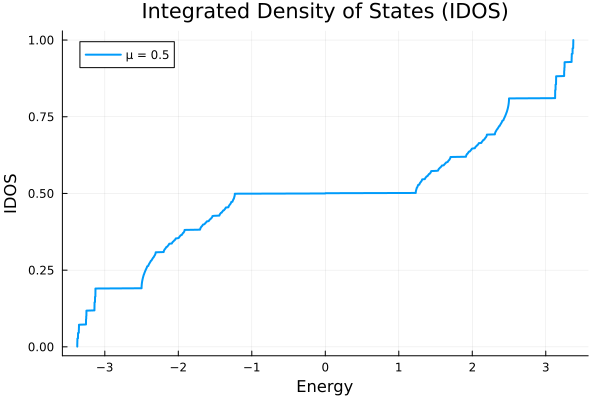

In [151]:
function compute_idos(eigenvalue_sets::Vector{Dict{String, Any}})
    idos_results = []

    for data in eigenvalue_sets
        eigenvalues = data["eigenvalues"]
        # seq_name = data["sequence"]
        sorted_vals = sort(real(eigenvalues))  # Ensure eigenvalues are real
        N = length(sorted_vals)

        # Compute IDOS: (index) / N
        idos = collect(1:N) ./ N

        push!(idos_results, Dict(
            # "sequence" => seq_name,
            "mu_values" => data["mu_values"],
            "eigenvalues" => sorted_vals,
            "idos" => idos
        ))
    end

    return idos_results
end

# Optional: Function to plot IDOS
function plot_idos(idos_results)
    plt = Plots.plot(title="Integrated Density of States (IDOS)", xlabel="Energy", ylabel="IDOS")

    # for result in idos_results
    #     Plots.plot!(result["eigenvalues"], result["idos"], label="μ = $(result["mu_values"])", lw=2)
    # end

    result = idos_results[1]
    Plots.plot!(result["eigenvalues"], result["idos"], label="μ = $(result["mu_values"])", lw=2)

    # xlims_range = (-3.04, -3.0)
    # ylims_range = (0.0, 0.25)

    # xlims!(plt, xlims_range)
    # ylims!(plt, ylims_range)

    display(plt)
end

function plot_idos_seq_comp(idos_results::Vector{Any}, mu_value::Float64)
    plt = Plots.plot(title="IDOS Comparison at μ = $mu_value", xlabel="Energy", ylabel="IDOS", legend=:bottomright)

    # Filter results for the specified mu value
    filtered = filter(r -> isapprox(r["mu_values"], mu_value; atol=1e-6), idos_results)

    if isempty(filtered)
        println("No data found for μ = $mu_value")
        return
    end

    for result in filtered
        sequence = result["sequence"]
        energy = result["eigenvalues"]
        idos = result["idos"]

        Plots.plot!(plt, energy, idos, label=sequence, lw=2)
    end

    display(plt)
end


# Example usage:
idos_data = compute_idos(all_results)
plot_idos(idos_data)

# plot_idos_seq_comp(idos_data, 0.0)


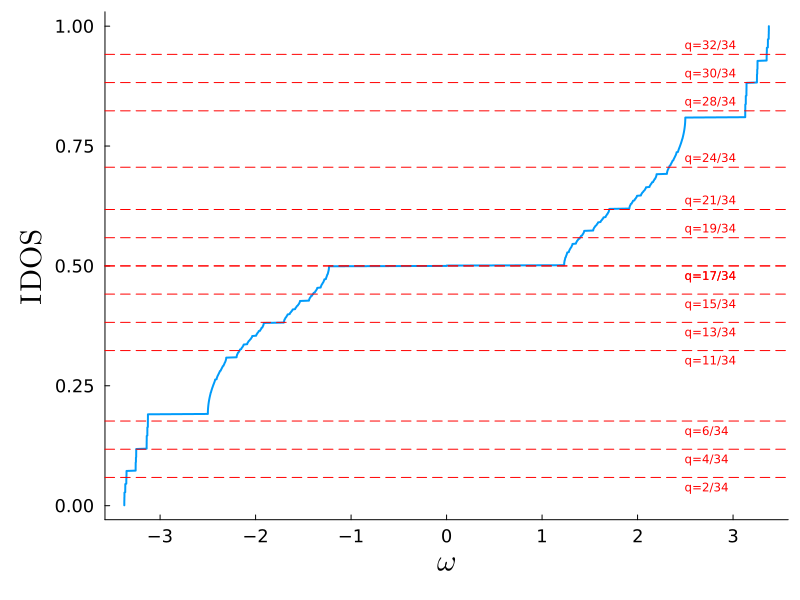

In [126]:
using Statistics, Plots

"""
    compute_idos(eigenvalue_sets)

Given a vector of dictionaries each containing "eigenvalues", compute and return
IDOS (normalized eigenvalue indices).
"""
function compute_idos(eigenvalue_sets::Vector{Dict{String, Any}})
    idos_results = []

    for data in eigenvalue_sets
        eigenvalues = sort(real(data["eigenvalues"]))
        N = length(eigenvalues)
        idos = collect(1:N) ./ N

        push!(idos_results, Dict(
            # "mu_t_ratio" => data["mu_t_ratio"],
            "mu_values" => data["mu_values"],
            "eigenvalues" => eigenvalues,
            "idos" => idos
        ))
    end

    return idos_results
end

"""
    detect_gaps(eigenvalues; threshold=0.05)

Given sorted eigenvalues, return index pairs (i, i+1) where the energy gap exceeds the threshold.
"""
function detect_gaps(eigenvalues::Vector{Float64}; threshold=1.0)
    gaps = Int[]
    for i in 1:length(eigenvalues)-1
        if eigenvalues[i+1] - eigenvalues[i] > threshold
            push!(gaps, i)
        end
    end
    
    return gaps
end

"""
    label_gaps(idos_values, gaps, t; tolerance=0.01)

Attempt to label IDOS values at gaps as fractions q/t, returning (q, actual_idos, approx_idos).
"""
function label_gaps(idos_values::Vector{Float64}, gaps::Vector{Int}, t::Int; tolerance=0.05)
    labels = []

    for i in gaps
        idos_val = (i + 0.5) / length(idos_values)  # midpoint between i and i+1
        closest_q = round(Int, idos_val * t)
        approx_idos = closest_q / t

        if abs(idos_val - approx_idos) < tolerance
            push!(labels, (q=closest_q, actual_idos=idos_val, approx_idos=approx_idos))
        end
    end

    return labels
end

"""
    plot_idos_with_labels(result, labels, t)

Plot IDOS curve and overlay vertical lines at labeled gap positions.
"""
function plot_idos_with_labels(result::Dict{String, Any}, labels, t::Int)
    ev = result["eigenvalues"]
    idos = result["idos"]

    # s1 = L"\mu = "
    # s2 = "$(result["mu_values"])"
    # label = "$(s1) $(s2)"

    plt = Plots.plot(
        ev, 
        idos, 
        xlabel=L"\omega", 
        ylabel=L"\textnormal{IDOS}", 
        lw=2,
        legend = false, #:outerbottomleft,
        grid = false,
        size = (800, 600),
        labelfontsize = 20,
        tickfontsize = 12,
        legendfontsize = 20,
        left_margin = 5mm,
        bottom_margin = 5mm,
    )
    # for label in labels
    #     i_gap = Int(round(label.actual_idos * length(ev)))
    #     x_pos = ev[min(i_gap, end)]
    #     annotate!(x_pos, label.actual_idos,
    #         Plots.text("q=$(label.q)/$t", :red, 8, :left))
    #     hline!([x_pos], label="", lc=:red, ls=:dash, lw=1)
    # end

    for label in labels
        y_pos = label.approx_idos
        offset = 0.02  # vertical offset for better visibility
    
        # Choose vertical shift based on position
        y_annot = y_pos + (y_pos > 0.5 ? offset : -offset)
    
        # Safer horizontal position (e.g., 80% of energy range)
        x_index = Int(round(0.8 * length(ev)))
        x_pos = ev[x_index]
    
        # Plot horizontal line
        hline!([y_pos], label="", lc=:red, ls=:dash, lw=1)
    
        # Annotate just above or below the line
        annotate!(x_pos, y_annot, Plots.text("q=$(label.q)/$t", :red, 8, :left))
    end

    display(plt)
end



# ========== Example Usage ==========
# Assume `data_vector` is your input (4-element Vector{Dict})
# and α ≈ p′/t is your rational approximant

function run_gap_labelling_analysis(data_vector::Vector{Dict{String, Any}}, t::Int; gap_threshold=0.05)
    idos_data = compute_idos(data_vector)

    for result in idos_data
        eigenvalues = result["eigenvalues"]
        idos = result["idos"]

        gaps = detect_gaps(eigenvalues; threshold=gap_threshold)
        labels = label_gaps(idos, gaps, t; tolerance=1.0)

        println("μ = $(result["mu_values"]): Found $(length(labels)) gaps.")
        for l in labels
            println("  Gap at IDOS ≈ $(round(l.actual_idos, digits=4)) labelled as q=$(l.q)/$t")
        end

        plot_idos_with_labels(result, labels, t)
    end
end

# Example call:
t=34
run_gap_labelling_analysis(all_results, t)


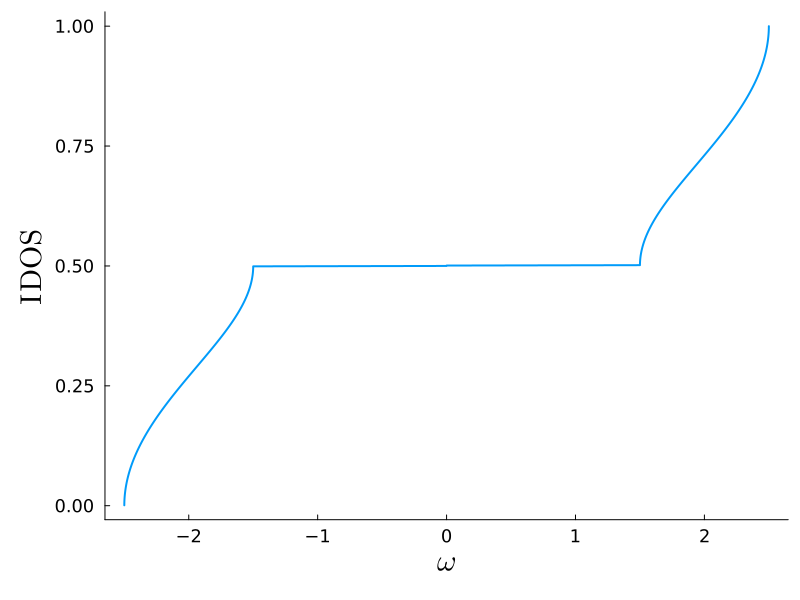

In [190]:
using Statistics, Plots

"""
    compute_idos(eigenvalue_sets)

Given a vector of dictionaries each containing "eigenvalues", compute and return
IDOS (normalized eigenvalue indices).
"""
function compute_idos(eigenvalue_sets::Vector{Dict{String, Any}})
    idos_results = []

    for data in eigenvalue_sets
        eigenvalues = sort(real(data["eigenvalues"]))
        N = length(eigenvalues)
        idos = collect(1:N) ./ N

        push!(idos_results, Dict(
            # "mu_t_ratio" => data["mu_t_ratio"],
            "mu_values" => data["mu_values"],
            "eigenvalues" => eigenvalues,
            "idos" => idos
        ))
    end

    return idos_results
end

"""
    detect_gaps(eigenvalues; threshold=0.05)

Given sorted eigenvalues, return index pairs (i, i+1) where the energy gap exceeds the threshold.
"""
function detect_gaps(eigenvalues::Vector{Float64}; threshold=1.0)
    gaps = Int[]
    for i in 1:length(eigenvalues)-1
        if eigenvalues[i+1] - eigenvalues[i] > threshold
            push!(gaps, i)
        end
    end
    
    return gaps
end

"""
    label_gaps(idos_values, gaps, t; tolerance=0.01)

Attempt to label IDOS values at gaps as fractions q/t, returning (q, actual_idos, approx_idos).
"""
function label_gaps_fractional(idos_values::Vector{Float64}, gaps::Vector{Int}, τ::Float64, q_max::Int; tolerance=0.01)
    labels = []

    for i in gaps
        idos_val = (i + 0.5) / length(idos_values)  # midpoint
        # Solve for q such that N(E) ≈ p + q/τ
        # We try a range of integer q values and pick the best match
        best_q = 0
        best_p = 0
        min_error = Inf

        for q_candidate in -q_max:q_max
            p_candidate = round(Int, idos_val - q_candidate / τ)
            approx_val = p_candidate + q_candidate / τ
            error = abs(idos_val - approx_val)

            if error < min_error && 0 ≤ approx_val ≤ 1
                min_error = error
                best_q = q_candidate
                best_p = p_candidate
            end
        end

        if min_error < tolerance
            push!(labels, (p=best_p, q=best_q, actual_idos=idos_val, approx_idos=best_p + best_q/τ))
        end
    end

    return labels
end


"""
    plot_idos_with_labels(result, labels, t)

Plot IDOS curve and overlay vertical lines at labeled gap positions.
"""
function plot_idos_with_labels(result::Dict{String, Any}, labels, τ::Float64, filepath::String)
    ev = result["eigenvalues"]
    idos = result["idos"]

    plt = Plots.plot(
        ev,
        idos,
        xlabel=L"\omega",
        ylabel=L"\textnormal{IDOS}",
        lw=2,
        legend=false,
        grid=false,
        size=(800, 600),
        labelfontsize=20,
        tickfontsize=12,
        legendfontsize=20,
        left_margin=5mm,
        bottom_margin=5mm,
    )
    #  # Plot all labels
    # for label in labels
    #     y_pos = label.approx_idos
    #     offset = 0.02
    #     y_annot = y_pos + (y_pos > 0.5 ? offset : -offset)

    #     x_index = Int(round(0.8 * length(ev)))
    #     x_pos = ev[x_index]

    #     hline!([y_pos], label="", lc=:red, ls=:dash, lw=1)
    #     annotate!(x_pos, y_annot, Plots.text("{$(label.p), $(label.q)}", :red, 8, :left))
    # end

    # # Plot half labels
    # for label in labels
    #     y_pos = label.approx_idos
    #     if y_pos > 0.5
    #         offset = 0.02
    #         y_annot = y_pos + offset  # Only annotate above line since y_pos > 0.5
    
    #         x_index = Int(round(0.8 * length(ev)))
    #         x_pos = ev[x_index]
    
    #         hline!([y_pos], label="", lc=:red, ls=:dash, lw=1)
    #         annotate!(x_pos, y_annot, Plots.text("{$(label.p), $(label.q)}", :red, 8, :left))
    #     end
    # end
    

    Plots.savefig(plt, filepath)
    display(plt)
end



# ========== Example Usage ==========
# Assume `data_vector` is your input (4-element Vector{Dict})
# and α ≈ p′/t is your rational approximant

function run_gap_labelling_analysis(data_vector::Vector{Dict{String, Any}}, t::Float64, q_max::Int, filepath::String; gap_threshold=0.05)
    idos_data = compute_idos(data_vector)

    for result in idos_data
        eigenvalues = result["eigenvalues"]
        idos = result["idos"]

        gaps = detect_gaps(eigenvalues; threshold=gap_threshold)
        labels = label_gaps_fractional(idos, gaps, t, q_max; tolerance=0.1)

        # println("μ = $(result["mu_values"]): Found $(length(labels)) gaps.")
        # for l in labels
        #     println("  Gap at IDOS ≈ $(round(l.actual_idos, digits=4)) labelled as q=$(l.q)/$t")
        # end

        plot_idos_with_labels(result, labels, t, filepath)
    end
end

# Example call:
t=2.0 #(1 + sqrt(5))/2
q_max = 5
gap_threshold = 0.05
filename = "NC_N610_no_labels"
filepath = "/Users/Will/Documents/FINAL_PROJECT/simulations/report_plots/gap_labelling/$(filename)"
run_gap_labelling_analysis(all_results, t, q_max, filepath, gap_threshold=gap_threshold)
